# Machine Learning Engineer Nanodegree


## Capstone Project: House Prices - Advanced Regression Techniques

The real estate domain encompasses buying, selling and renting of property and houses. Whenever we buy or sell a house, we often need a real estate agent to quote a price for the same since they know which factors are important and how much they affect the house’s price, in other words domain knowledge. This project aims to build a model that can help the estate agent explain and the consumer understand the factors or features that affect house prices the most, and also the price itself. The paper [Modeling Home Prices Using Realtor Data](http://ww2.amstat.org/publications/jse/v16n2/datasets.pardoe.html) is an example of predicting house prices using 12 features extracted from realtor data. In this project we try to solve a similar ongoing [kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), but with a much larger [feature set](http://www.amstat.org/publications/jse/v19n3/decock.pdf). The motivation of this project is feature engineering.

In [176]:
# Import libraries necessary for this project
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
from IPython.display import display # Allows the use of display() for DataFrames

from time import time

from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

# Pretty display for notebooks
%matplotlib inline

All the import statements go into the above cell.

### Data Exploration

**In this section we will have preliminary insights about the dataset.**

In [177]:
# Read the training and testing set to pandas dataframes.
try:
    train_data = pd.read_csv("train.csv")
    test_data = pd.read_csv("test.csv")
    print("Training set has {} samples with {} features each.".format(*train_data.shape))
    print("Testing set has {} samples with {} features each.".format(*test_data.shape))
except Exception as e:
    print("Dataset could not be loaded. Error: {}".format(e))
    print("Please make sure the training and the testing set is present")

Training set has 1460 samples with 81 features each.
Testing set has 1459 samples with 80 features each.


**Let's have a glance at our training and testing data.**

In [178]:
display(train_data.head())
display(test_data.head())

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...               120        0    NaN  MnPrv   
1         Lvl    AllPub      ...                 0        0    NaN    NaN   
2         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
3         Lvl    AllPub      ...                 0        0    NaN    NaN   
4         HLS    AllPub      ...               144        0    NaN    NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0      6    2010        WD         Normal  
1        Gar2   12500      6    2010        WD         Normal  
2         NaN       0      3    2010        WD         Normal  
3         NaN       0      6    2010        WD         Normal  
4         NaN       0      1    2010        WD         Normal  

[5 rows x 80 columns]

As expected the target variable `'SalePrice'` is not present in the testing set. The dataset has missing values for `'LotArea'`, `'Alley'`, `'PoolQC'` etc. Also since the dataset has an explicit `'Id'` feature let's set that as the index for both the dataframes.

In [179]:
train_data.set_index('Id', inplace=True)
test_data.set_index('Id', inplace=True)
display(train_data.head())
display(test_data.tail())

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
Id                                    ...                             
1          Lvl    AllPub    Inside    ...            0    NaN   NaN   
2          Lvl    AllPub       FR2    ...            0    NaN   NaN   
3          Lvl    AllPub    Inside    ...            0    NaN   NaN   
4          Lvl    AllPub    Corner    ...            0    NaN   NaN   
5          Lvl    AllPub       FR2    ...            0    NaN   NaN   

   MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                         
1          NaN       0      2    2008        WD         Normal     208500  
2          NaN       0      5    2007        WD         Normal     181500  
3          NaN       0      9    2008        WD         Normal     223500  
4          NaN       0      2    2006        WD        Abnorml     140000  
5          NaN       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2915         160       RM         21.0     1936   Pave   NaN      Reg   
2916         160       RM         21.0     1894   Pave   NaN      Reg   
2917          20       RL        160.0    20000   Pave   NaN      Reg   
2918          85       RL         62.0    10441   Pave   NaN      Reg   
2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2915         Lvl    AllPub    Inside      ...                 0        0   
2916         Lvl    AllPub    Inside      ...                 0        0   
2917         Lvl    AllPub    Inside      ...                 0        0   
2918         Lvl    AllPub    Inside      ...                 0        0   
2919         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
Id                                                                 
2915    NaN    NaN         NaN       0       6    2006        WD   
2916    NaN    NaN         NaN       0       4    2006        WD   
2917    NaN    NaN         NaN       0       9    2006        WD   
2918    NaN  MnPrv        Shed     700       7    2006        WD   
2919    NaN    NaN         NaN       0      11    2006        WD   

      SaleCondition  
Id                   
2915         Normal  
2916        Abnorml  
2917        Abnorml  
2918         Normal  
2919         Normal  

[5 rows x 79 columns]

**Let's see how many missing values are present in our training and testing data.**

In [180]:
# Add the total number of  missing values for each feature in the training and testing set.
missing_train = train_data.isnull().sum().sum()
missing_test = test_data.isnull().sum().sum()
print("There are a total of {} missing values out of {} in the training set.".format(missing_train, train_data.shape[0] * train_data.shape[1]))
print("There are a total of {} missing values out of {} in the testing set.".format(missing_test, test_data.shape[0] * test_data.shape[1]))

There are a total of 6965 missing values out of 116800 in the training set.
There are a total of 7000 missing values out of 115261 in the testing set.


In the coming sections we will handle the above missing data.

**Numerical vs. Categorical**

In [181]:
numerical_features = train_data.select_dtypes(include="number").columns
categorical_features = train_data.select_dtypes(include="object").columns
print("There are a total of {} numerical features in the training set.".format(numerical_features.size))
print("There are a total of {} categorical features in the training set.".format(categorical_features.size))

There are a total of 37 numerical features in the training set.
There are a total of 43 categorical features in the training set.


Contrary to the above, there are a few categorical features that has some order/ranking in them, example `'Utilities'`. These will addressed later in the **Preprocessing** section. Also in the coming section namely **Feature Reduction**, we will perform Exploratory Data Analysis (EDA) in detail.

**Let's have some insights about the target variable** `'SalePrice'`.

In [182]:
train_data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The above suggests that the target variable `'SalePrice'` is skewed. **Let's see a distribution of the same.**

Feature: SalePrice, Skewness: 1.8829
Feature: SalePrice, Kurtosis: 6.5363


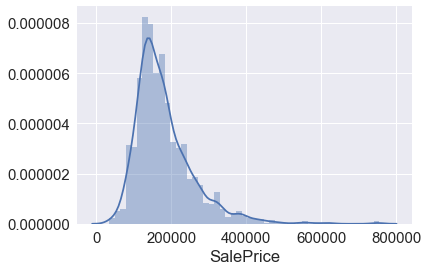

In [183]:
sns.distplot(train_data.SalePrice)
print("Feature: SalePrice, Skewness: {:.4f}".format(train_data.SalePrice.skew()))
print("Feature: SalePrice, Kurtosis: {:.4f}".format(train_data.SalePrice.kurt()))

As depicted from the above, the target variable `'SalePrice'` is skewed consisting almost all houses in the range of [ 34900, 400000 ]. A higher kurtosis also suggest the presence of outliers.

### Preprocessing: Handling Missing Data

**In this section we will handle missing data in the dataset.** Values can be filled based on the mean/median/mode of the feature or the most plausible value based on domain knowledge.

> Note: Care should be taken when filling values, that is, we should only use the value based on the training set. For example if mode is chosen to fill missing values in a given feature `'f'`, the mode of the training set should be used instead of the combination of both training and testing set.

**Let's combine the training and testing set and handle missing data simultaneously.** Since we need to drop `'SalePrice'` from the training set for successful concatenation, let's see if there are any missing values in the same.

In [184]:
# Add the total number of missing values for SalePrice feature.
print("There are {} missing values for SalePrice feature.".format(train_data.SalePrice.isnull().sum()))

There are 0 missing values for SalePrice feature.


In [185]:
# Concatenate training and testing set.
combined_data = pd.concat([train_data.drop('SalePrice', axis=1), test_data])
print("The combined training and testing set has {} samples with {} features each.".format(*combined_data.shape))
display(combined_data.head())

The combined training and testing set has 2919 samples with 79 features each.


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig      ...       ScreenPorch PoolArea PoolQC  \
Id                                      ...                                     
1          Lvl    AllPub    Inside      ...                 0        0    NaN   
2          Lvl    AllPub       FR2      ...                 0        0    NaN   
3          Lvl    AllPub    Inside      ...                 0        0    NaN   
4          Lvl    AllPub    Corner      ...                 0        0    NaN   
5          Lvl    AllPub       FR2      ...                 0        0    NaN   

   Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                     
1    NaN         NaN       0       2    2008        WD         Normal  
2    NaN         NaN       0       5    2007        WD         Normal  
3    NaN         NaN       0       9    2008        WD         Normal  
4    NaN         NaN       0       2    2006        WD        Abnorml  
5    NaN         NaN       0      12    2008        WD         Normal  

[5 rows x 79 columns]

**Let's see missing values information for each feature.**

In [186]:
missing_data_count = combined_data.isnull().sum().sort_values(ascending=False)
missing_data_percent = (combined_data.isnull().sum()*100.0 / combined_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_data_count, missing_data_percent], keys=['Count', 'Percent'], axis=1)
missing_data = missing_data[missing_data.Count > 0]
print("There are a total of {} features with missing data as shown below.".format(*missing_data.shape))
display(missing_data)

There are a total of 34 features with missing data as shown below.


Count    Percent
PoolQC         2909  99.657417
MiscFeature    2814  96.402878
Alley          2721  93.216855
Fence          2348  80.438506
FireplaceQu    1420  48.646797
LotFrontage     486  16.649538
GarageCond      159   5.447071
GarageQual      159   5.447071
GarageYrBlt     159   5.447071
GarageFinish    159   5.447071
GarageType      157   5.378554
BsmtCond         82   2.809181
BsmtExposure     82   2.809181
BsmtQual         81   2.774923
BsmtFinType2     80   2.740665
BsmtFinType1     79   2.706406
MasVnrType       24   0.822199
MasVnrArea       23   0.787941
MSZoning          4   0.137033
BsmtHalfBath      2   0.068517
Utilities         2   0.068517
Functional        2   0.068517
BsmtFullBath      2   0.068517
BsmtFinSF2        1   0.034258
BsmtFinSF1        1   0.034258
Exterior2nd       1   0.034258
BsmtUnfSF         1   0.034258
TotalBsmtSF       1   0.034258
Exterior1st       1   0.034258
SaleType          1   0.034258
Electrical        1   0.034258
KitchenQual       1   0.034258
GarageArea        1   0.034258
GarageCars        1   0.034258

**Let's see a plot of the same.**

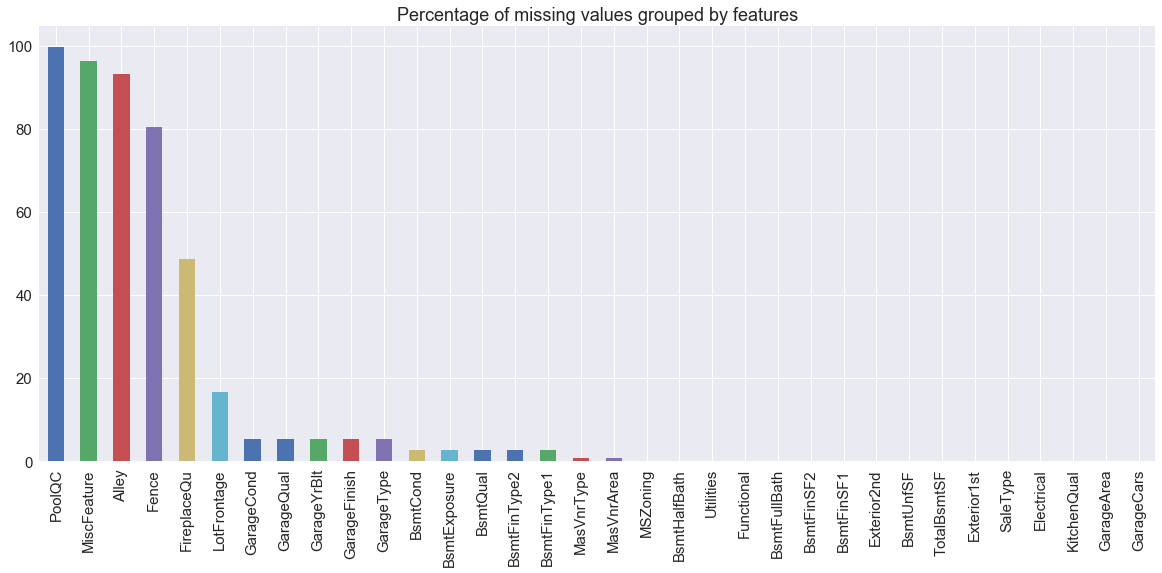

In [187]:
missing_data.Percent.plot(kind='bar', title="Percentage of missing values grouped by features", fontsize=15, figsize=(20, 8))

Features with more than 95 percent missing values, namely `'PoolQC'` and `'MiscFeature'` can be considered a candidate for feature reduction and will be covered in the same section. However features with 1 or 2 missing values can be handled by removing the data points itself, if and only if those data points lie in the training set and number of those data points is less than or equal to 3. **Let's check the latter first.**

In [188]:
# Find features with 2 or less missing values.
low_missing_data_features = missing_data[missing_data.Count <= 2 ].index
print("Features with 2 or less missing values: {}".format(low_missing_data_features.tolist()))
print("-" * 100)
indexes = combined_data.loc[combined_data[low_missing_data_features].isnull().any(axis=1)].index
print("There are {} data points which contain missing values for the above features: {}".format(indexes.size, indexes.tolist()))

Features with 2 or less missing values: ['BsmtHalfBath', 'Utilities', 'Functional', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtFinSF1', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'Exterior1st', 'SaleType', 'Electrical', 'KitchenQual', 'GarageArea', 'GarageCars']
----------------------------------------------------------------------------------------------------
There are 11 data points which contain missing values for the above features: [1380L, 1556L, 1916L, 1946L, 2121L, 2152L, 2189L, 2217L, 2474L, 2490L, 2577L]


Since there are more than 3 data points which contain missing values for the features with 2 or less missing values, we cannot delete those points. Additionally out of the above data points there is only one data point in the training set. Now that we have identified features with missing values, we should start filling those. **Let's have a sample of 10 data points to determine the methodology for filling missing values for each feature.**

In [189]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 99):
    display(combined_data[missing_data.index].sample(10))

PoolQC MiscFeature Alley  Fence FireplaceQu  LotFrontage GarageCond  \
Id                                                                         
2299    NaN         NaN   NaN    NaN          Ex         99.0         TA   
2402    NaN         NaN   NaN  MnPrv         NaN         80.0         TA   
2886    NaN         NaN   NaN    NaN          Gd         78.0         TA   
39      NaN         NaN   NaN    NaN         NaN         68.0         TA   
444     NaN         NaN   NaN    NaN          Gd         53.0         TA   
354     NaN         NaN   NaN    NaN         NaN         60.0         TA   
282     NaN         NaN  Pave    NaN         NaN         60.0         TA   
2593    NaN         NaN   NaN    NaN          Gd         68.0         TA   
1405    NaN         NaN  Grvl  MnPrv         NaN         60.0         TA   
1571    NaN         NaN   NaN  MnPrv          TA         50.0         TA   

     GarageQual  GarageYrBlt GarageFinish GarageType BsmtCond BsmtExposure  \
Id                                                                           
2299         TA       2004.0          RFn    BuiltIn       TA           Av   
2402         TA       1955.0          Fin     Attchd       TA           No   
2886         TA       1950.0          Fin     Attchd       TA           No   
39           TA       1953.0          Unf     Detchd       TA           No   
444          TA       2007.0          Fin     Attchd       TA           Av   
354          TA       2005.0          Unf     Detchd       TA           No   
282          TA       2006.0          Fin     Attchd       TA           No   
2593         TA       2207.0          RFn     Attchd       TA           Av   
1405         TA       1998.0          Unf     Detchd       TA           No   
1571         Fa       1947.0          Unf     Detchd       Fa           No   

     BsmtQual BsmtFinType2 BsmtFinType1 MasVnrType  MasVnrArea MSZoning  \
Id                                                                        
2299       Gd          Unf          Unf    BrkFace       502.0       RL   
2402       TA          Unf          BLQ    BrkFace       176.0       RL   
2886       Gd          Unf          GLQ    BrkFace       405.0       RL   
39         TA          Unf          GLQ       None         0.0       RL   
444        Ex          Unf          Unf    BrkFace        72.0       RL   
354        TA          Unf          Unf       None         0.0       RM   
282        Gd          Unf          GLQ      Stone        68.0       FV   
2593       Gd          Unf          GLQ        NaN         NaN       RL   
1405       TA          Unf          Unf       None         0.0       RL   
1571       TA          Unf          LwQ       None         0.0       RL   

      BsmtHalfBath Utilities Functional  BsmtFullBath  BsmtFinSF2  BsmtFinSF1  \
Id                                                                              
2299           0.0    AllPub        Typ           0.0         0.0         0.0   
2402           0.0    AllPub        Typ           1.0         0.0       368.0   
2886           0.0    AllPub        Typ           1.0         0.0       760.0   
39             0.0    AllPub        Typ           1.0         0.0       731.0   
444            0.0    AllPub        Typ           0.0         0.0         0.0   
354            0.0    AllPub        Typ           0.0         0.0         0.0   
282            0.0    AllPub        Typ           0.0         0.0       905.0   
2593           0.0    AllPub        Typ           0.0         0.0       583.0   
1405           0.0    AllPub        Typ           0.0         0.0         0.0   
1571           0.0    AllPub        Typ           0.0         0.0       192.0   

     Exterior2nd  BsmtUnfSF  TotalBsmtSF Exterior1st SaleType Electrical  \
Id                                                                         
2299     VinylSd     1706.0       1706.0     VinylSd       WD      SBrkr   
2402     HdBoard      710.0       1078.0     HdBoard 

**With all the above features with 10 sample values for each, let's start filling missing values for the same.**

In [190]:
# Fill missing values for Functional. A NaN value signifies Typical by default.
combined_data.Functional = combined_data.Functional.fillna("Typ")

# Fill missing values for PoolQC, MiscFeature, Alley, Fence, FireplaceQu, MasVnrType, Exterior2nd.
# A NaN value signifies None for the respective feature.
for feature in [ 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType', 'Exterior2nd' ]:
    combined_data[feature] = combined_data[feature].fillna("None")

# Fill missing values for GarageCond, GarageQual, GarageYrBlt, GarageFinish, GarageType.
# A NaN value signifies no Garage.
for feature in [ 'GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish', 'GarageType' ]:
    combined_data[feature] = combined_data[feature].fillna("None")

# Fill missing values for BsmtCond, BsmtExposure, BsmtQual, BsmtFinType2, BsmtFinType1.
# A NaN value signifies no Basement.
for feature in [ 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1' ]:
    combined_data[feature] = combined_data[feature].fillna("None")

# Fill missing values for BsmtHalfBath, BsmtFullBath, BsmtFinSF2, BsmtFinSF1, BsmtUnfSF, TotalBsmtSF.
# A NaN value signifies no Basement. Hence 0 for the respective feature.
for feature in [ 'BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF' ]:
    combined_data[feature] = combined_data[feature].fillna(0)

# Fill missing values for MasVnrArea, GarageArea, GarageCars. A NaN value signifies 0 for the respective feature.
for feature in [ 'MasVnrArea', 'GarageArea', 'GarageCars' ]:
    combined_data[feature] = combined_data[feature].fillna(0)

# Fill missing values for LotFrontage. Should be filled with mean.
combined_data.LotFrontage = combined_data.LotFrontage.fillna(train_data.LotFrontage.mean())

# Fill missing values for MSZoning, Utilities, Exterior1st, SaleType, Electrical, KitchenQual. Should be filled with mode.
for feature in [ 'MSZoning', 'Utilities', 'Exterior1st', 'SaleType', 'Electrical', 'KitchenQual' ]:
    combined_data[feature] = combined_data[feature].fillna(train_data[feature].mode()[0])

# Verify that there are no missing values.
missing = combined_data.isnull().sum().sum()
print("There are {} missing values remaining in the combined dataset.".format(missing))

There are 0 missing values remaining in the combined dataset.


**Let's reconstruct our training and testing data.** Remember that our combined dataset does not contain `'SalePrice'` feature and therefore it needs to be added for reconstructed training set.

In [191]:
# Separate training and testing data based on the number of samples in the respective set.
train_data_sans_missing = pd.concat([combined_data[:train_data.shape[0]], pd.DataFrame(train_data.SalePrice)], axis=1)
test_data_sans_missing = combined_data[train_data.shape[0]:]
display(train_data_sans_missing.head())
display(test_data_sans_missing.head())

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave  None      Reg   
2           20       RL         80.0     9600   Pave  None      Reg   
3           60       RL         68.0    11250   Pave  None      IR1   
4           70       RL         60.0     9550   Pave  None      IR1   
5           60       RL         84.0    14260   Pave  None      IR1   

   LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
Id                                    ...                             
1          Lvl    AllPub    Inside    ...            0   None  None   
2          Lvl    AllPub       FR2    ...            0   None  None   
3          Lvl    AllPub    Inside    ...            0   None  None   
4          Lvl    AllPub    Corner    ...            0   None  None   
5          Lvl    AllPub       FR2    ...            0   None  None   

   MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                         
1         None       0      2    2008        WD         Normal     208500  
2         None       0      5    2007        WD         Normal     181500  
3         None       0      9    2008        WD         Normal     223500  
4         None       0      2    2006        WD        Abnorml     140000  
5         None       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave  None      Reg   
1462          20       RL         81.0    14267   Pave  None      IR1   
1463          60       RL         74.0    13830   Pave  None      IR1   
1464          60       RL         78.0     9978   Pave  None      IR1   
1465         120       RL         43.0     5005   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
1461         Lvl    AllPub    Inside      ...               120        0   
1462         Lvl    AllPub    Corner      ...                 0        0   
1463         Lvl    AllPub    Inside      ...                 0        0   
1464         Lvl    AllPub    Inside      ...                 0        0   
1465         HLS    AllPub    Inside      ...               144        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
Id                                                                 
1461   None  MnPrv        None       0       6    2010        WD   
1462   None   None        Gar2   12500       6    2010        WD   
1463   None  MnPrv        None       0       3    2010        WD   
1464   None   None        None       0       6    2010        WD   
1465   None   None        None       0       1    2010        WD   

      SaleCondition  
Id                   
1461         Normal  
1462         Normal  
1463         Normal  
1464         Normal  
1465         Normal  

[5 rows x 79 columns]

### Preprocessing: Outlier Analysis

**In this section we will analyze outliers and remove them if necessary.** We will perform Interquartile Range (IQR) to detect outliers. Additionally the [Author of the dataset](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) advises to remove any house with `'GrLivArea'` greater than 4000 square feet to eliminate all potential outliers.

> Note: Since IQR works with continuous numerical features, we should be careful when selecting the same.

**Let's perform Interquartile Range (IQR) on the training set for all the numerical features which are continuous.**

In [192]:
continuous_numerical_features = [ 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                                    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                                                    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice' ]

# Append the outliers of each feature in a dataframe for further analysis.
columns = ["feature", "count", "indices"]
outliers_dataframe = pd.DataFrame(columns=columns)
for feature in continuous_numerical_features:
    Q1 = np.percentile(train_data_sans_missing[feature], 25)
    Q3 = np.percentile(train_data_sans_missing[feature], 75)
    step = (Q3-Q1)*1.5
    lower_bound = Q1 - step
    upper_bound = Q3 + step
    feature_outliers = train_data_sans_missing[~((train_data_sans_missing[feature] >= lower_bound) & (train_data_sans_missing[feature] <= upper_bound))]
    outliers_dataframe = outliers_dataframe.append({ "feature": feature, "count": feature_outliers.shape[0], "indices": feature_outliers.index.tolist() }, ignore_index=True)

**Let's plot the Number of Outliers per feature using the above process.**

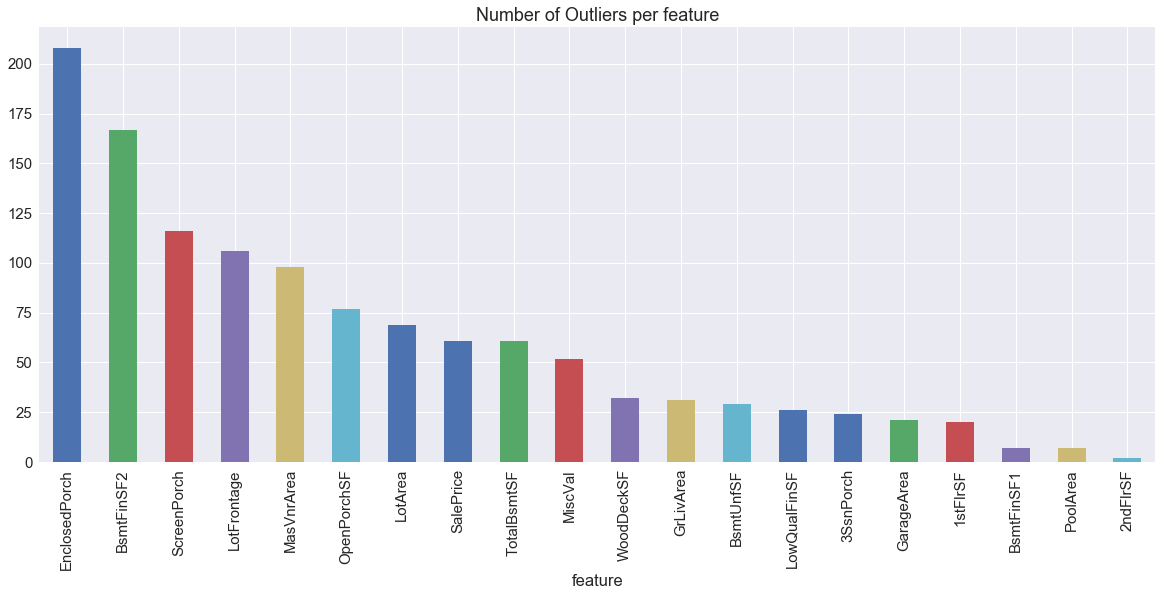

In [193]:
outliers_dataframe.sort_values(by="count", ascending=False).plot(x="feature", y="count", kind="bar", title="Number of Outliers per feature",
                                                                                                             fontsize=15, figsize=(20, 8), legend=False)

Since there are large number of outliers present for each feature, we need to select ones which affects most features. **Let's see 15 outliers and their respective feature count.**

In [194]:
# Find outliers which affect most features.
display(pd.DataFrame(outliers_dataframe.indices.sum(), columns=["feature_count"]).feature_count.value_counts().nlargest(15).to_frame())

feature_count
1299             10
524               8
1183              8
692               7
198               7
225               6
497               6
186               6
179               6
804               6
770               6
665               5
1387              5
441               5
1170              5

As depicted from the above if we choose to remove outliers that affects at least 6 features we would be removing 11 data points which seems a lot considering we originally performed IQR on 20 features. However, there are only 5 data points when we consider outlier that affects at least 7 features, which become our final outliers.

In [195]:
outliers_indices = [1299, 524, 1183, 692, 198]

Let's see how our results compare to the author's suggestion of removing data points with `'GrLivArea'` greater than 4000.

In [196]:
# Find houses with GrLivArea greater than 4000.
display(train_data_sans_missing.loc[(train_data_sans_missing.GrLivArea > 4000), ["GrLivArea", "SalePrice"]])

GrLivArea  SalePrice
Id                        
524        4676     184750
692        4316     755000
1183       4476     745000
1299       5642     160000

IQR did a good job of finding the outliers since it contains all the data points that has GrLivArea greater than 4000 which is inline with the author's suggestion. **Let's remove the outliers.**

In [197]:
print("Pre Outlier removal: There are {} samples in the training set.".format(*train_data_sans_missing.shape))
train_data_sans_missing.drop(train_data_sans_missing.loc[outliers_indices].index, inplace=True)
print("Post Outlier removal: There are {} samples in the training set.".format(*train_data_sans_missing.shape))

Pre Outlier removal: There are 1460 samples in the training set.
Post Outlier removal: There are 1455 samples in the training set.


**Save the updated training and testing set to disk.**

In [198]:
# Save the updated training set to file
filename = "chkp01_train.csv"
is_present = glob.glob(filename)
if not is_present:
    train_data_sans_missing.to_csv(filename, index=True)
    print("Updated training set written to file: {}".format(filename))
else:
    print("File: {} already present. Make sure to delete the same when running the whole notebook.".format(filename))

# Save the updated testing set to file
filename = "chkp01_test.csv"
is_present = glob.glob(filename)
if not is_present:
    test_data_sans_missing.to_csv(filename, index=True)
    print("Updated testing set written to file: {}".format(filename))
else:
    print("File: {} already present. Make sure to delete the same when running the whole notebook.".format(filename))

Updated training set written to file: chkp01_train.csv
Updated testing set written to file: chkp01_test.csv


### Checkpoint 01

This checkpoint serves the updated training and testing set with no missing values and outliers removed.

**Load the updated dataset.**

In [199]:
# Read the training and testing set to pandas dataframes.
try:
    train_data = pd.read_csv("chkp01_train.csv")
    test_data = pd.read_csv("chkp01_test.csv")
    train_data.set_index('Id', inplace=True)
    test_data.set_index('Id', inplace=True)
    print("Training set has {} samples with {} features each.".format(*train_data.shape))
    print("Testing set has {} samples with {} features each.".format(*test_data.shape))
except Exception as e:
    print("Dataset could not be loaded. Error: {}".format(e))
    print("Please make sure the training and the testing set is present")

Training set has 1455 samples with 80 features each.
Testing set has 1459 samples with 79 features each.


### Preprocessing: Handling Numerical and Categorical data.

**In this section we will convert feature values to their correct data types: Categorical (Ordinal and Nominal) and Numerical (Discrete and Continuous).**

**Let's combine the training and testing dataset as before to handle it simultaneously.** Since `'SalePrice'` will be dropped from the training set for successful concatenation let's see if it's data type is correct.

In [200]:
train_data.SalePrice.dtype

dtype('int64')

Should be float64 but that can be done while reading in the data next time.

In [201]:
# Concatenate training and testing set.
combined_data = pd.concat([train_data.drop('SalePrice', axis=1), test_data])
print("The combined training and testing set has {} samples with {} features each.".format(*combined_data.shape))

The combined training and testing set has 2914 samples with 79 features each.


**Now that we have our combined dataset, let's map feature values.**

In [202]:
mapped = {
    "Street": { "Grvl" : 1, "Pave" : 2 },
    "Alley" : { "None" : 0, "Grvl" : 1, "Pave" : 2 },
    "LotShape" : { "IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4 },
    "Utilities": { "ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4 },
    "LandSlope": { "Sev" : 1, "Mod" : 2, "Gtl" : 3 },
    "ExterQual" : { "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "ExterCond" : { "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "BsmtQual": { "None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "BsmtCond" : { "None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "BsmtExposure" : { "None" : 0, "No" : 1, "Mn" : 2, "Av" : 3, "Gd" : 4 },
    "BsmtFinType1" : { "None" : 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6 },
    "BsmtFinType2" : { "None" : 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6 },
    "HeatingQC" : { "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "CentralAir" : { "N" : 0, "Y" : 1 },
    "KitchenQual" : { "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "Functional": { "Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod" : 5, "Min2" : 6, "Min1" : 7, "Typ" : 8 },
    "FireplaceQu" : { "None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "GarageFinish" : { "None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3 },
    "GarageQual" : { "None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "GarageCond" : { "None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "PavedDrive": { "N" : 0, "P" : 1, "Y" : 2 },
    "PoolQC" : { "None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5 },
    "Fence" : { "None" : 0, "MnWw" : 1, "GdWo" : 2, "MnPrv" : 3, "GdPrv" : 4 },
}

combined_data = combined_data.replace(mapped)

# For some reason GarageYrBlt is read with a decimal point.
# Since it's a string type object because of some "None" values, we need to apply a string method to remove the trailing ".0"
combined_data.GarageYrBlt = combined_data.GarageYrBlt.str.replace("\.0", "")

**Let's reconstruct our training and testing data.** Remember that our combined dataset does not contain `'SalePrice'` feature and therefore it needs to be added for reconstructed training set.

In [203]:
# Separate training and testing data based on the number of samples in the respective set.
train_data_correct_dtypes = pd.concat([combined_data[:train_data.shape[0]], pd.DataFrame(train_data.SalePrice)], axis=1)
test_data_correct_dtypes = combined_data[train_data.shape[0]:]

**Save the updated training and testing set to disk.**

In [204]:
# Save the updated training set to file
filename = "chkp02_train.csv"
is_present = glob.glob(filename)
if not is_present:
    train_data_correct_dtypes.to_csv(filename, index=True)
    print("Updated training set written to file: {}".format(filename))
else:
    print("File: {} already present. Make sure to delete the same when running the whole notebook.".format(filename))

# Save the updated testing set to file
filename = "chkp02_test.csv"
is_present = glob.glob(filename)
if not is_present:
    test_data_correct_dtypes.to_csv(filename, index=True)
    print("Updated testing set written to file: {}".format(filename))
else:
    print("File: {} already present. Make sure to delete the same when running the whole notebook.".format(filename))

Updated training set written to file: chkp02_train.csv
Updated testing set written to file: chkp02_test.csv


### Checkpoint 02

This checkpoint serves the updated training and testing set with feature values mapped to their correct data types.

**Load the updated dataset.** Additionally this time we will explicitly mention the dtypes of the column while reading the dataset.

In [205]:
column_types = {
    'MSSubClass' : np.int64, 'MSZoning' : np.object, 'LotFrontage' : np.float64, 'LotArea' : np.float64, 'Street' : np.int64,
    'Alley' : np.int64, 'LotShape' : np.int64, 'LandContour' : np.object, 'Utilities' : np.int64, 'LotConfig' : np.object,
    'LandSlope' : np.int64, 'Neighborhood' : np.object, 'Condition1' : np.object, 'Condition2' : np.object, 'BldgType' : np.object,
    'HouseStyle' : np.object, 'OverallQual' : np.int64, 'OverallCond' : np.int64, 'YearBuilt' : np.int64, 'YearRemodAdd' : np.int64,
    'RoofStyle' : np.object, 'RoofMatl' : np.object, 'Exterior1st' : np.object, 'Exterior2nd' : np.object, 'MasVnrType' : np.object,
    'MasVnrArea' : np.float64, 'ExterQual' : np.int64, 'ExterCond' : np.int64, 'Foundation' : np.object, 'BsmtQual' : np.int64,
    'BsmtCond' : np.int64, 'BsmtExposure' : np.int64, 'BsmtFinType1' : np.int64, 'BsmtFinSF1' : np.float64, 'BsmtFinType2' : np.int64,
    'BsmtFinSF2' : np.float64, 'BsmtUnfSF' : np.float64, 'TotalBsmtSF' : np.float64, 'Heating' : np.object, 'HeatingQC' : np.int64,
    'CentralAir' : np.int64, 'Electrical' : np.object, '1stFlrSF' : np.float64, '2ndFlrSF' : np.float64, 'LowQualFinSF' : np.float64,
    'GrLivArea' : np.float64, 'BsmtFullBath' : np.int64, 'BsmtHalfBath' : np.int64, 'FullBath' : np.int64, 'HalfBath' : np.int64,
    'BedroomAbvGr' : np.int64, 'KitchenAbvGr' : np.int64, 'KitchenQual' : np.int64, 'TotRmsAbvGrd' : np.int64, 'Functional' : np.int64,
    'Fireplaces' : np.int64, 'FireplaceQu' : np.int64, 'GarageType' : np.object, 'GarageYrBlt' : np.object, 'GarageFinish' : np.int64,
    'GarageCars' : np.int64, 'GarageArea' : np.float64, 'GarageQual' : np.int64, 'GarageCond' : np.int64, 'PavedDrive' : np.int64,
    'WoodDeckSF' : np.float64, 'OpenPorchSF' : np.float64, 'EnclosedPorch' : np.float64, '3SsnPorch' : np.float64, 'ScreenPorch' : np.float64,
    'PoolArea' : np.float64, 'PoolQC' : np.int64, 'Fence' : np.int64, 'MiscFeature' : np.object, 'MiscVal' : np.float64,
    'MoSold' : np.int64, 'YrSold' : np.int64, 'SaleType' : np.object, 'SaleCondition' : np.object, 'SalePrice' : np.float64
}

# Read the training and testing set to pandas dataframes.
try:
    train_data = pd.read_csv("chkp02_train.csv", dtype=column_types)
    test_data = pd.read_csv("chkp02_test.csv", dtype=column_types)
    train_data.set_index('Id', inplace=True)
    test_data.set_index('Id', inplace=True)
    print("Training set has {} samples with {} features each.".format(*train_data.shape))
    print("Testing set has {} samples with {} features each.".format(*test_data.shape))
except Exception as e:
    print("Dataset could not be loaded. Error: {}".format(e))
    print("Please make sure the training and the testing set is present")

Training set has 1455 samples with 80 features each.
Testing set has 1459 samples with 79 features each.


**Let's have a glance at our training and testing data.**

In [206]:
display(train_data.head())
display(test_data.head())

MSSubClass MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                       
1           60       RL         65.0   8450.0       2      0         4   
2           20       RL         80.0   9600.0       2      0         4   
3           60       RL         68.0  11250.0       2      0         3   
4           70       RL         60.0   9550.0       2      0         3   
5           60       RL         84.0  14260.0       2      0         3   

   LandContour  Utilities LotConfig    ...      PoolArea PoolQC Fence  \
Id                                     ...                              
1          Lvl          4    Inside    ...           0.0      0     0   
2          Lvl          4       FR2    ...           0.0      0     0   
3          Lvl          4    Inside    ...           0.0      0     0   
4          Lvl          4    Corner    ...           0.0      0     0   
5          Lvl          4       FR2    ...           0.0      0     0   

   MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                         
1         None     0.0      2    2008        WD         Normal   208500.0  
2         None     0.0      5    2007        WD         Normal   181500.0  
3         None     0.0      9    2008        WD         Normal   223500.0  
4         None     0.0      2    2006        WD        Abnorml   140000.0  
5         None     0.0     12    2008        WD         Normal   250000.0  

[5 rows x 80 columns]

MSSubClass MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                         
1461          20       RH         80.0  11622.0       2      0         4   
1462          20       RL         81.0  14267.0       2      0         3   
1463          60       RL         74.0  13830.0       2      0         3   
1464          60       RL         78.0   9978.0       2      0         3   
1465         120       RL         43.0   5005.0       2      0         3   

     LandContour  Utilities LotConfig      ...        ScreenPorch PoolArea  \
Id                                         ...                               
1461         Lvl          4    Inside      ...              120.0      0.0   
1462         Lvl          4    Corner      ...                0.0      0.0   
1463         Lvl          4    Inside      ...                0.0      0.0   
1464         Lvl          4    Inside      ...                0.0      0.0   
1465         HLS          4    Inside      ...              144.0      0.0   

     PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold  SaleType  \
Id                                                                 
1461      0     3        None      0.0       6    2010        WD   
1462      0     0        Gar2  12500.0       6    2010        WD   
1463      0     3        None      0.0       3    2010        WD   
1464      0     0        None      0.0       6    2010        WD   
1465      0     0        None      0.0       1    2010        WD   

      SaleCondition  
Id                   
1461         Normal  
1462         Normal  
1463         Normal  
1464         Normal  
1465         Normal  

[5 rows x 79 columns]

### Feature Reduction (I)

**In this section we will perform feature reduction to identify most relevant features for model building.** Since we have large number of features, subset of feature set is created that are closely related to each other subject to domain knowledge. We can choose to remove unimportant features from each subset and still account for aggregation of the same. Below are subset of the features set.

In [207]:
feature_set_sale = [ 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition' ]
feature_set_position = [ 'Neighborhood', 'Condition1', 'Condition2' ]
feature_set_dwelling = [ 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType' ]
feature_set_living_area = [ '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea' ]
feature_set_basement = [ 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF' ]
feature_set_rooms_kitchen_bathrooms = [ 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd' ]
feature_set_amenities = [ 'Utilities', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Fireplaces', 'FireplaceQu', 'PoolArea', 'PoolQC', 'MiscFeature' ]
feature_set_garage = [ 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond' ]
feature_set_porch = [ 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch' ]
feature_set_exterior_finish = [ 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond' ]
feature_set_lot = [ 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig' ]
feature_set_miscellaneous = [ 'PavedDrive', 'Street', 'Alley', 'Fence', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'Functional',
                                                 'MasVnrArea', 'MasVnrType', 'LandContour', 'LandSlope' ]

reduced_feature_set = []
candidate_feature_removal = []

**Let's have a look at features that are closely related to Sale of the House.**

In [208]:
print("feature_set_sale: {}".format(feature_set_sale))

feature_set_sale: ['MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


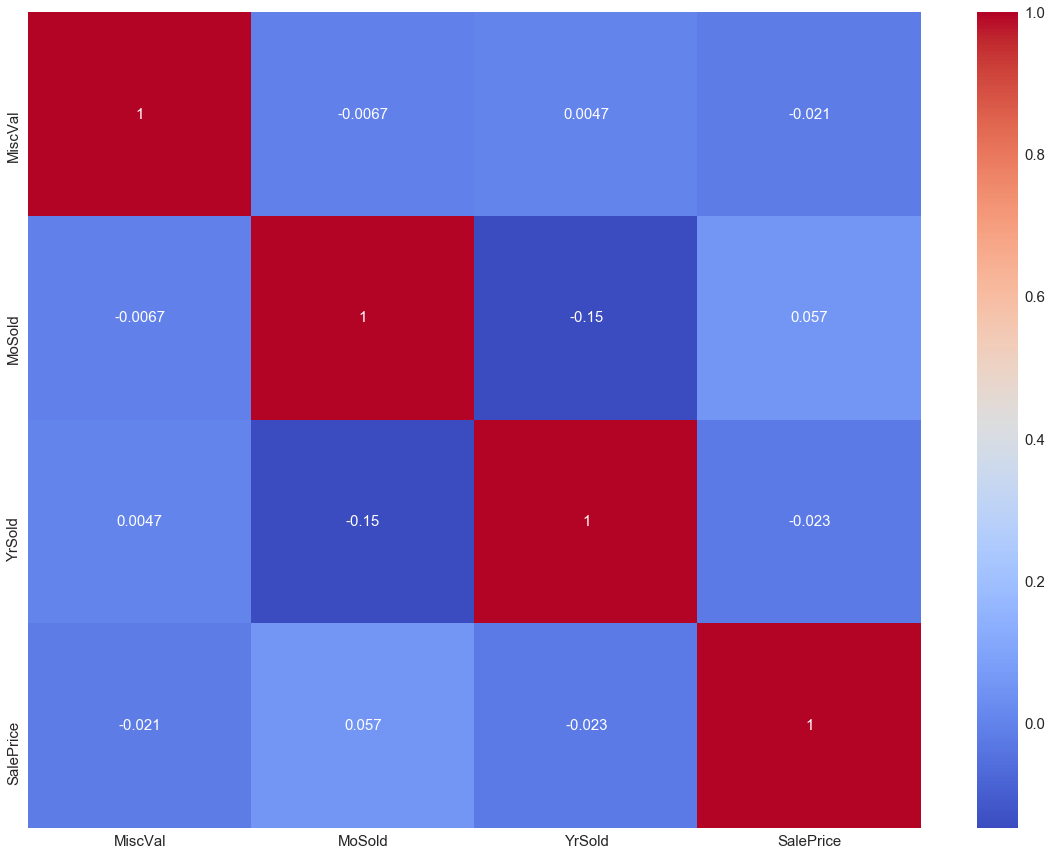

In [209]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_sale:
    feature_set_sale.append("SalePrice")
correlation = train_data[feature_set_sale].corr()
plt.subplots(figsize=(20, 15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

**Let's take a look at some plots.**

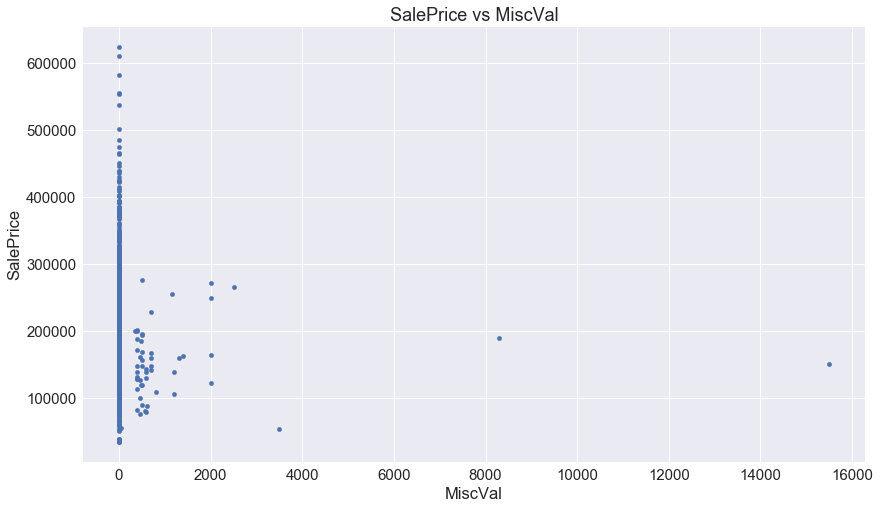

In [210]:
train_data.loc[:, ["MiscVal", "SalePrice"]].plot(x="MiscVal", y="SalePrice", kind="scatter", title="SalePrice vs MiscVal", fontsize=15, figsize=(14, 8))

`'MiscValue'` seems like a good candidate for feature removal.

In [211]:
candidate_feature_removal.append("MiscValue")

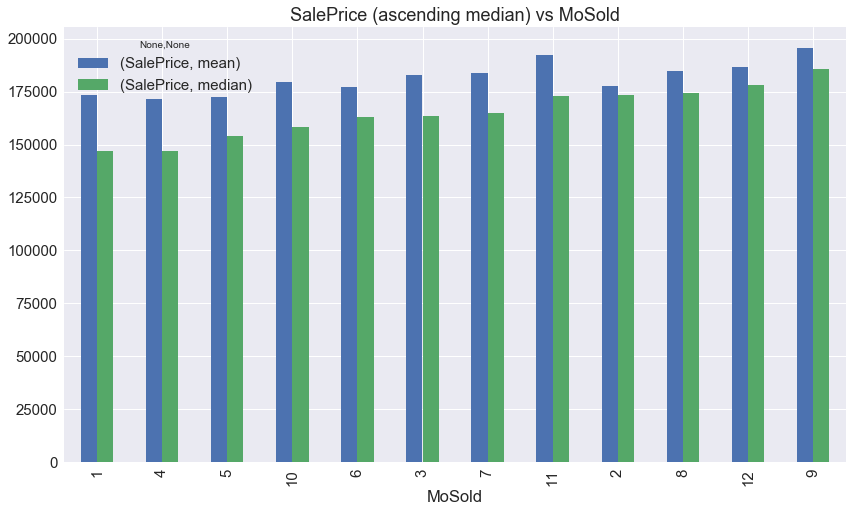

In [212]:
t = train_data.loc[:, ["MoSold", "SalePrice"]].groupby("MoSold").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs MoSold", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs MoSold", fontsize=15, figsize=(14, 8))

`'MoSold'` is slightly correlated to `'SalePrice'`.

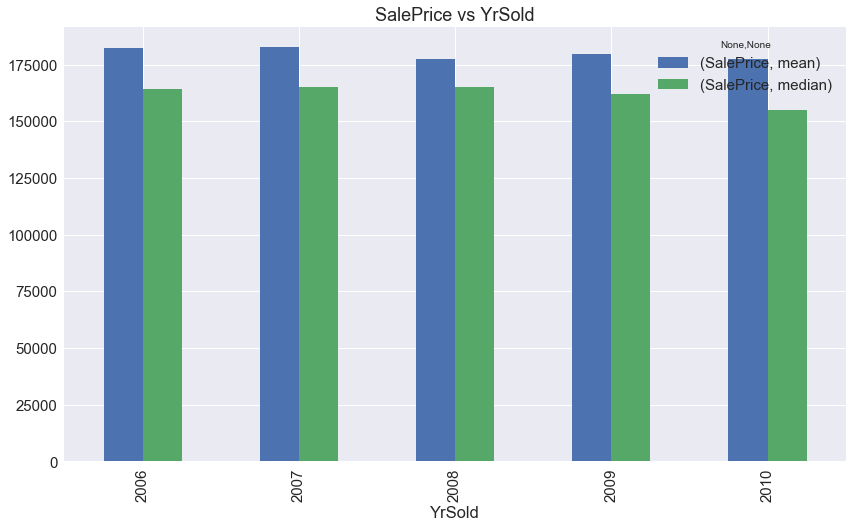

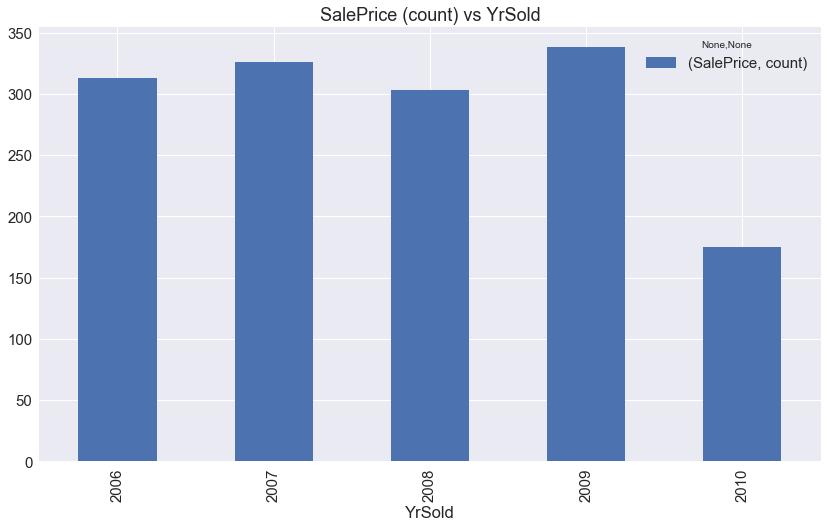

In [213]:
t = train_data.loc[:, ["YrSold", "SalePrice"]].groupby("YrSold").agg(["mean", "median", "count"])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice vs YrSold", fontsize=15, figsize=(14, 8))
t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs YrSold", fontsize=15, figsize=(14, 8))

`'YrSold'` can be removed from the feature set.

In [214]:
candidate_feature_removal.append("YrSold")

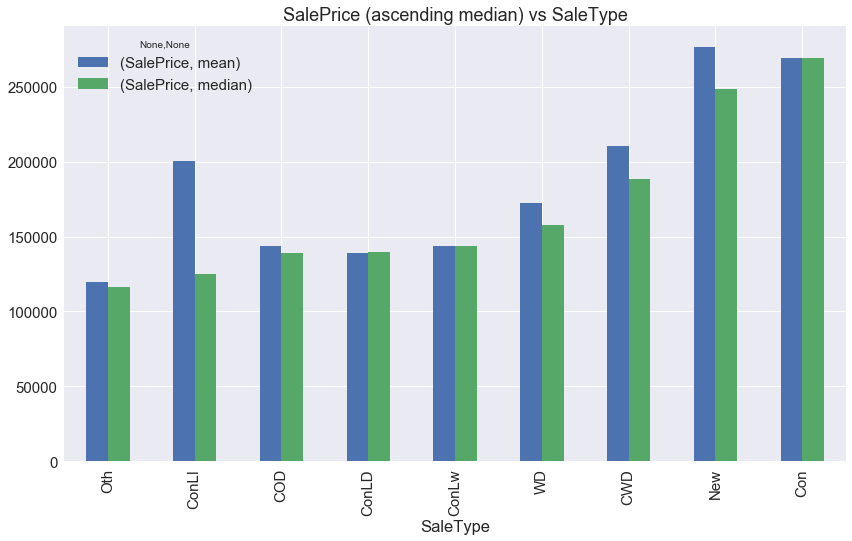

In [215]:
t = train_data.loc[:, ["SaleType", "SalePrice"]].groupby("SaleType").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs SaleType", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs SaleType", fontsize=15, figsize=(14, 8))

`'SaleType'` should not be removed.

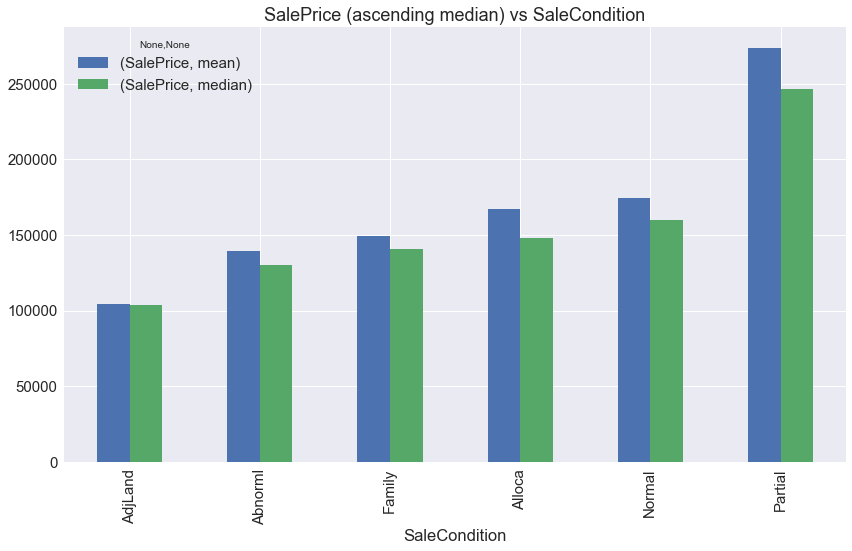

In [216]:
t = train_data.loc[:, ["SaleCondition", "SalePrice"]].groupby("SaleCondition").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs SaleCondition", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs SaleCondition", fontsize=15, figsize=(14, 8))

`'SaleCondition'` should not be removed.

In [217]:
reduced_feature_set.extend([ 'MoSold', 'SaleType', 'SaleCondition' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition']


**Let's have a look at features that are closely related to Position of the House.**

In [218]:
print("feature_set_position: {}".format(feature_set_position))

feature_set_position: ['Neighborhood', 'Condition1', 'Condition2']


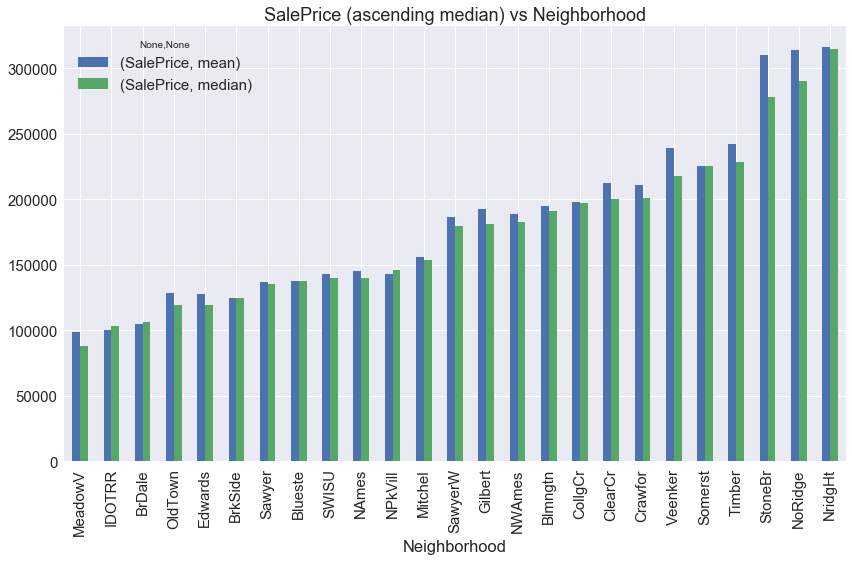

In [219]:
t = train_data.loc[:, ["Neighborhood", "SalePrice"]].groupby("Neighborhood").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Neighborhood", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Neighborhood", fontsize=15, figsize=(14, 8))

`'Neighborhood'` should not be removed.

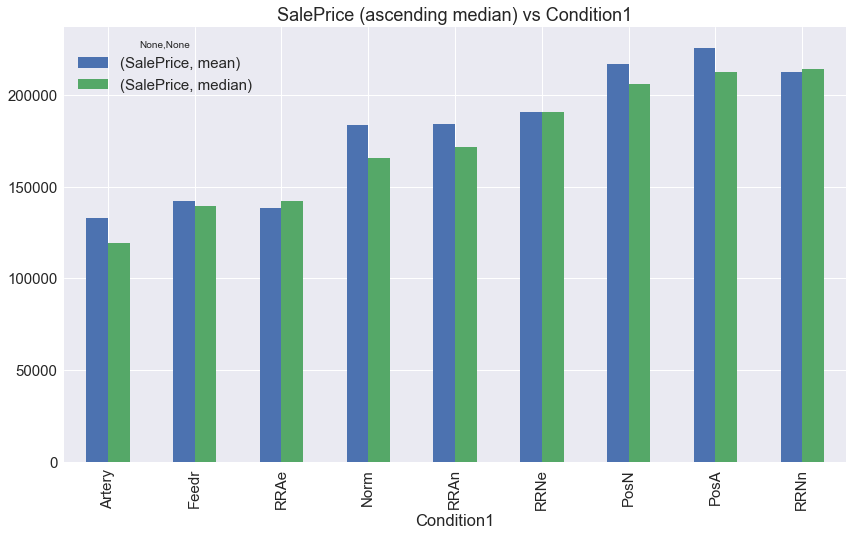

In [220]:
t = train_data.loc[:, ["Condition1", "SalePrice"]].groupby("Condition1").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Condition1", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Condition1", fontsize=15, figsize=(14, 8))

`'Condition1'` should not be removed.

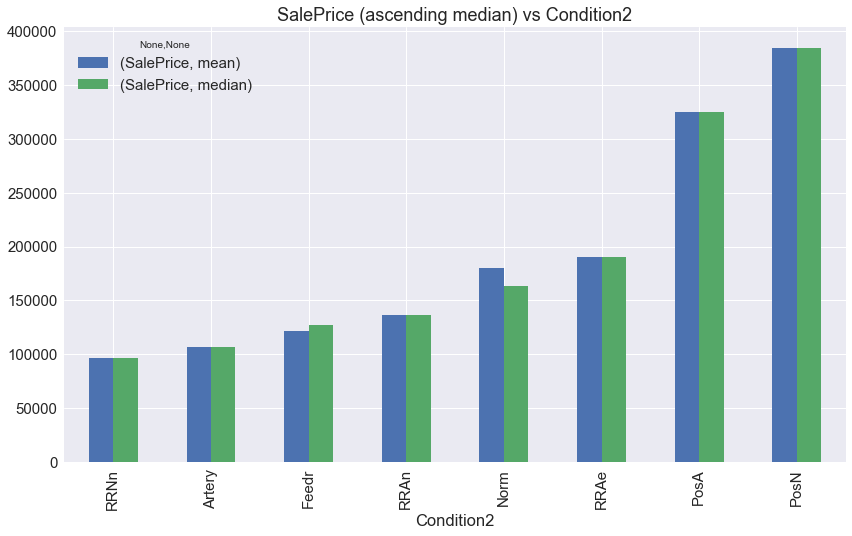

In [221]:
t = train_data.loc[:, ["Condition2", "SalePrice"]].groupby("Condition2").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Condition2", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Condition2", fontsize=15, figsize=(14, 8))

`'Condition2'` should not be removed.

All the features in `'feature_set_position'` are kept in the `'reduced_feature_set'`.

In [222]:
reduced_feature_set.extend([ 'Neighborhood', 'Condition1', 'Condition2' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2']


**Let's have a look at features that are closely related to Dwelling of the House.**

In [223]:
print("feature_set_dwelling: {}".format(feature_set_dwelling))

feature_set_dwelling: ['MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType']


In [224]:
# Since there is only one numerical feature we can directly see the correlation with the target variable.
correlation = train_data["MSSubClass"].corr(train_data["SalePrice"])
print("Correlation between MSSubClass and SalePrice: {:.4f}".format(correlation))

Correlation between MSSubClass and SalePrice: -0.0884


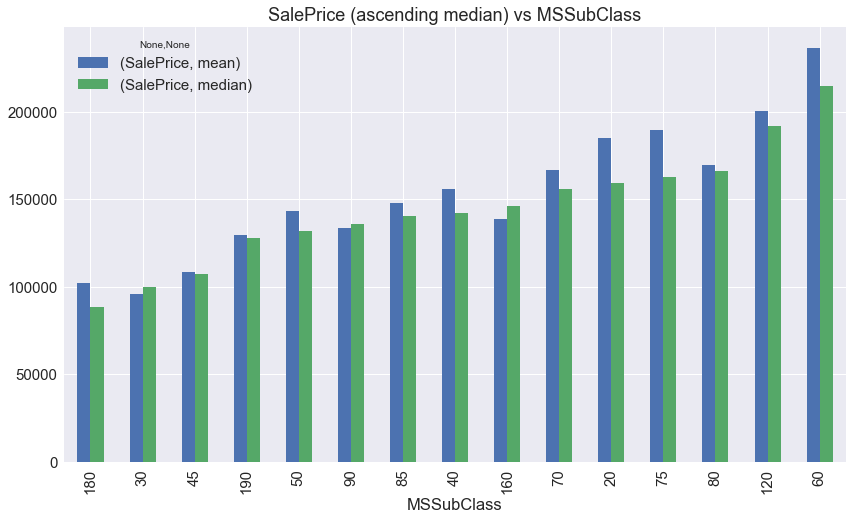

In [225]:
t = train_data.loc[:, ["MSSubClass", "SalePrice"]].groupby("MSSubClass").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs MSSubClass", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs MSSubClass", fontsize=15, figsize=(14, 8))

`'MSSubClass'` should not be removed.

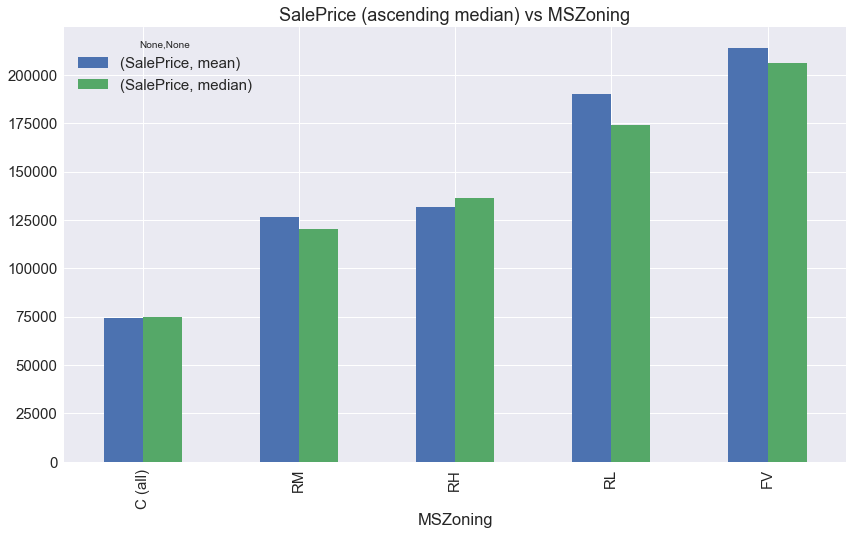

In [226]:
t = train_data.loc[:, ["MSZoning", "SalePrice"]].groupby("MSZoning").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs MSZoning", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs MSZoning", fontsize=15, figsize=(14, 8))

`'MSZoning'` should not be removed.

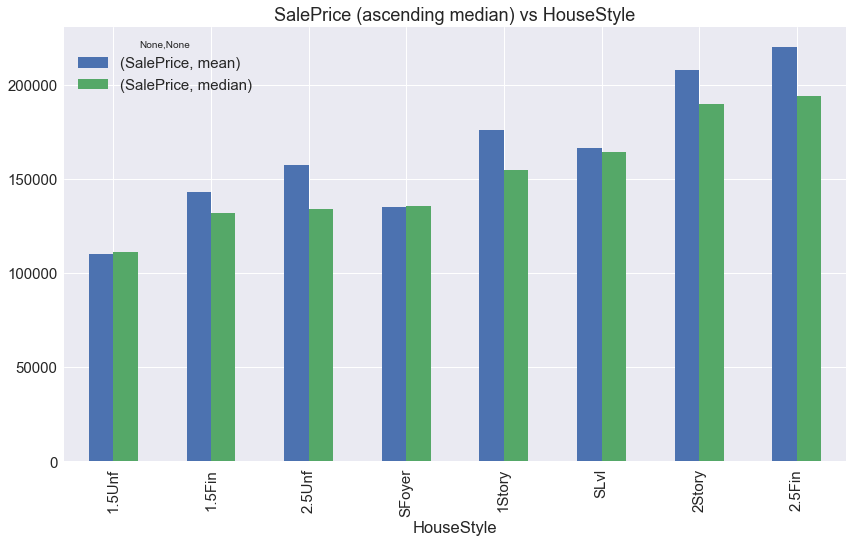

In [227]:
t = train_data.loc[:, ["HouseStyle", "SalePrice"]].groupby("HouseStyle").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs HouseStyle", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs HouseStyle", fontsize=15, figsize=(14, 8))

`'HouseStyle'` should not be removed.

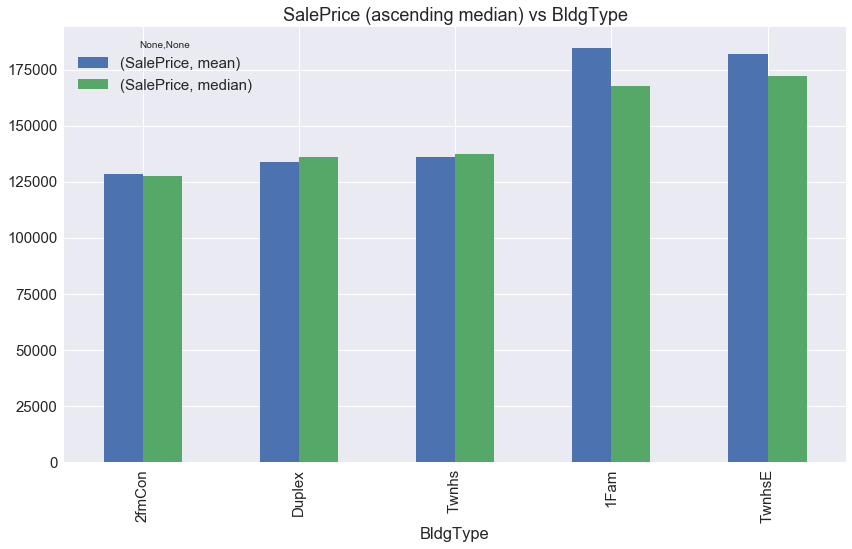

In [228]:
t = train_data.loc[:, ["BldgType", "SalePrice"]].groupby("BldgType").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs BldgType", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs BldgType", fontsize=15, figsize=(14, 8))

`'BldgType'` should not be removed.

All the features in `'feature_set_dwelling'` are kept in the `'reduced_feature_set'`.

In [229]:
reduced_feature_set.extend([ 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType']


**Let's have a look at features that are closely related to the Living Area of the House.**

In [230]:
print("feature_set_living_area: {}".format(feature_set_living_area))

feature_set_living_area: ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']


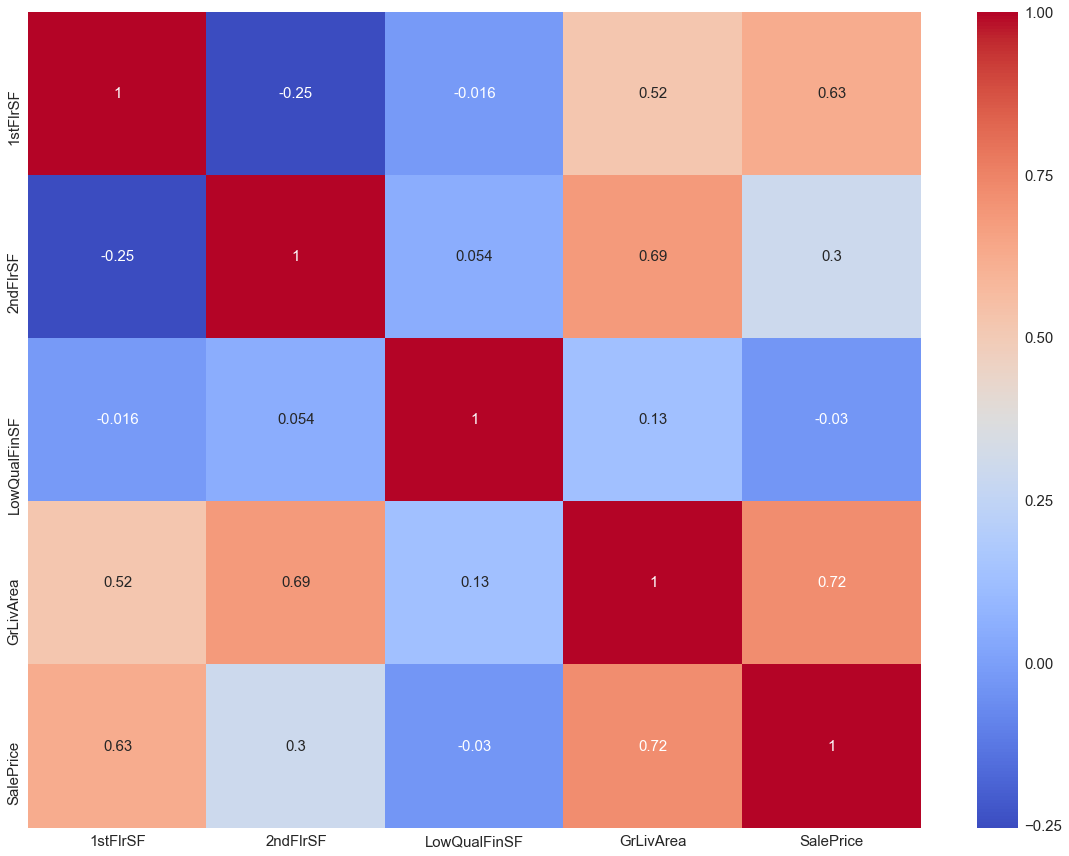

In [231]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_living_area:
    feature_set_living_area.append("SalePrice")
correlation = train_data[feature_set_living_area].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

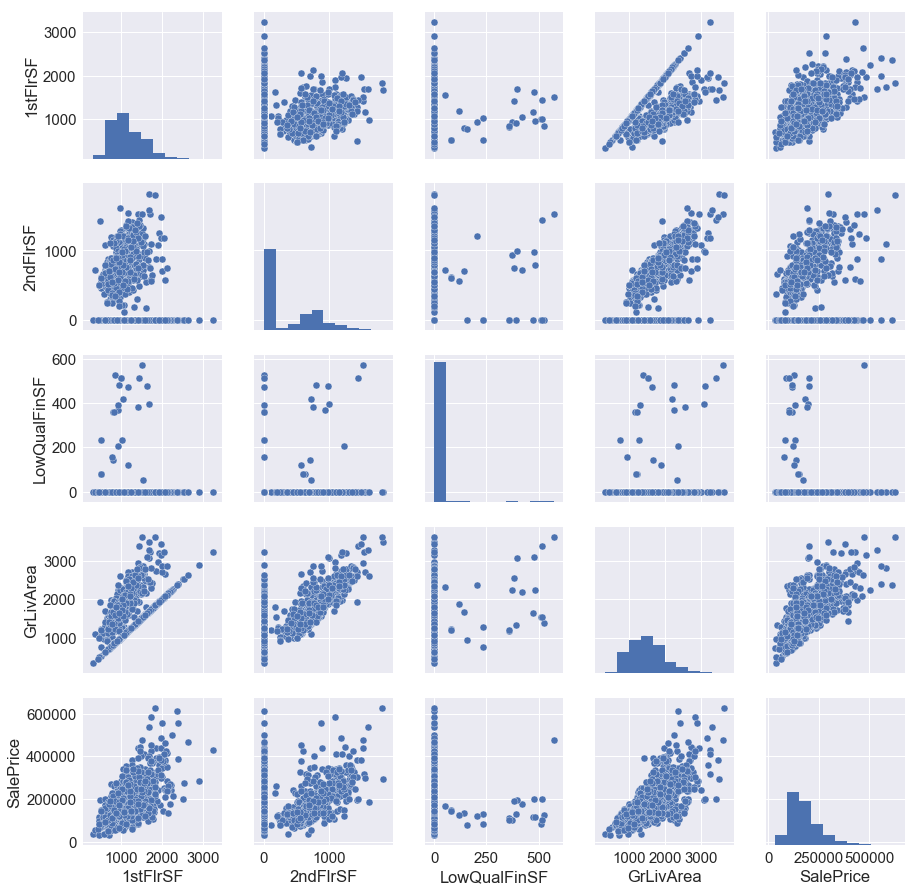

In [232]:
sns.pairplot(train_data[feature_set_living_area])

Using the above correlation and scatter mattrix, we can say that `'GrLivArea'` is a very important feature when it comes to predicting `'SalePrice'`. `'1stFlrSF'` and `'2ndFlrSF'` show high correlation with `'GrLivArea'` and thus can be removed. However, since `'1stFlrSF'` itself shows comparable correlation with `'SalePrice'` it is advisable to keep it. `'LowQualFinSF'` shows very low correlation with `'SalePrice'` and thus can be removed. Therefore, considering the above feature, our final candidate for feature removal are `'2ndFlrSF'` and `'LowQualFinSF'`.

In [233]:
candidate_feature_removal.extend([ '2ndFlrSF', 'LowQualFinSF' ])

In [234]:
reduced_feature_set.extend([ '1stFlrSF', 'GrLivArea' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea']


**Let's have a look at features that are closely related to the Basement of the House.**

In [235]:
print("feature_set_basement: {}".format(feature_set_basement))

feature_set_basement: ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']


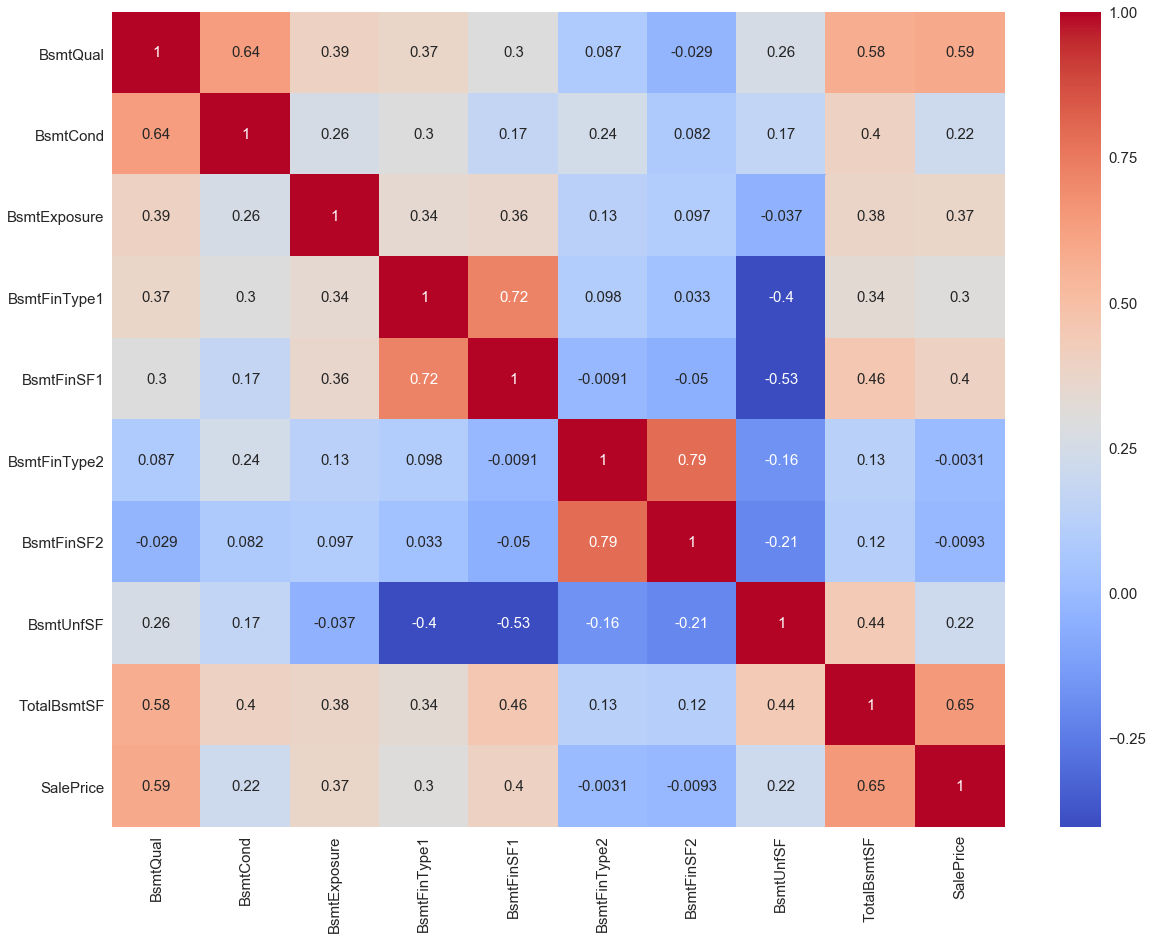

In [236]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_basement:
    feature_set_basement.append("SalePrice")
correlation = train_data[feature_set_basement].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

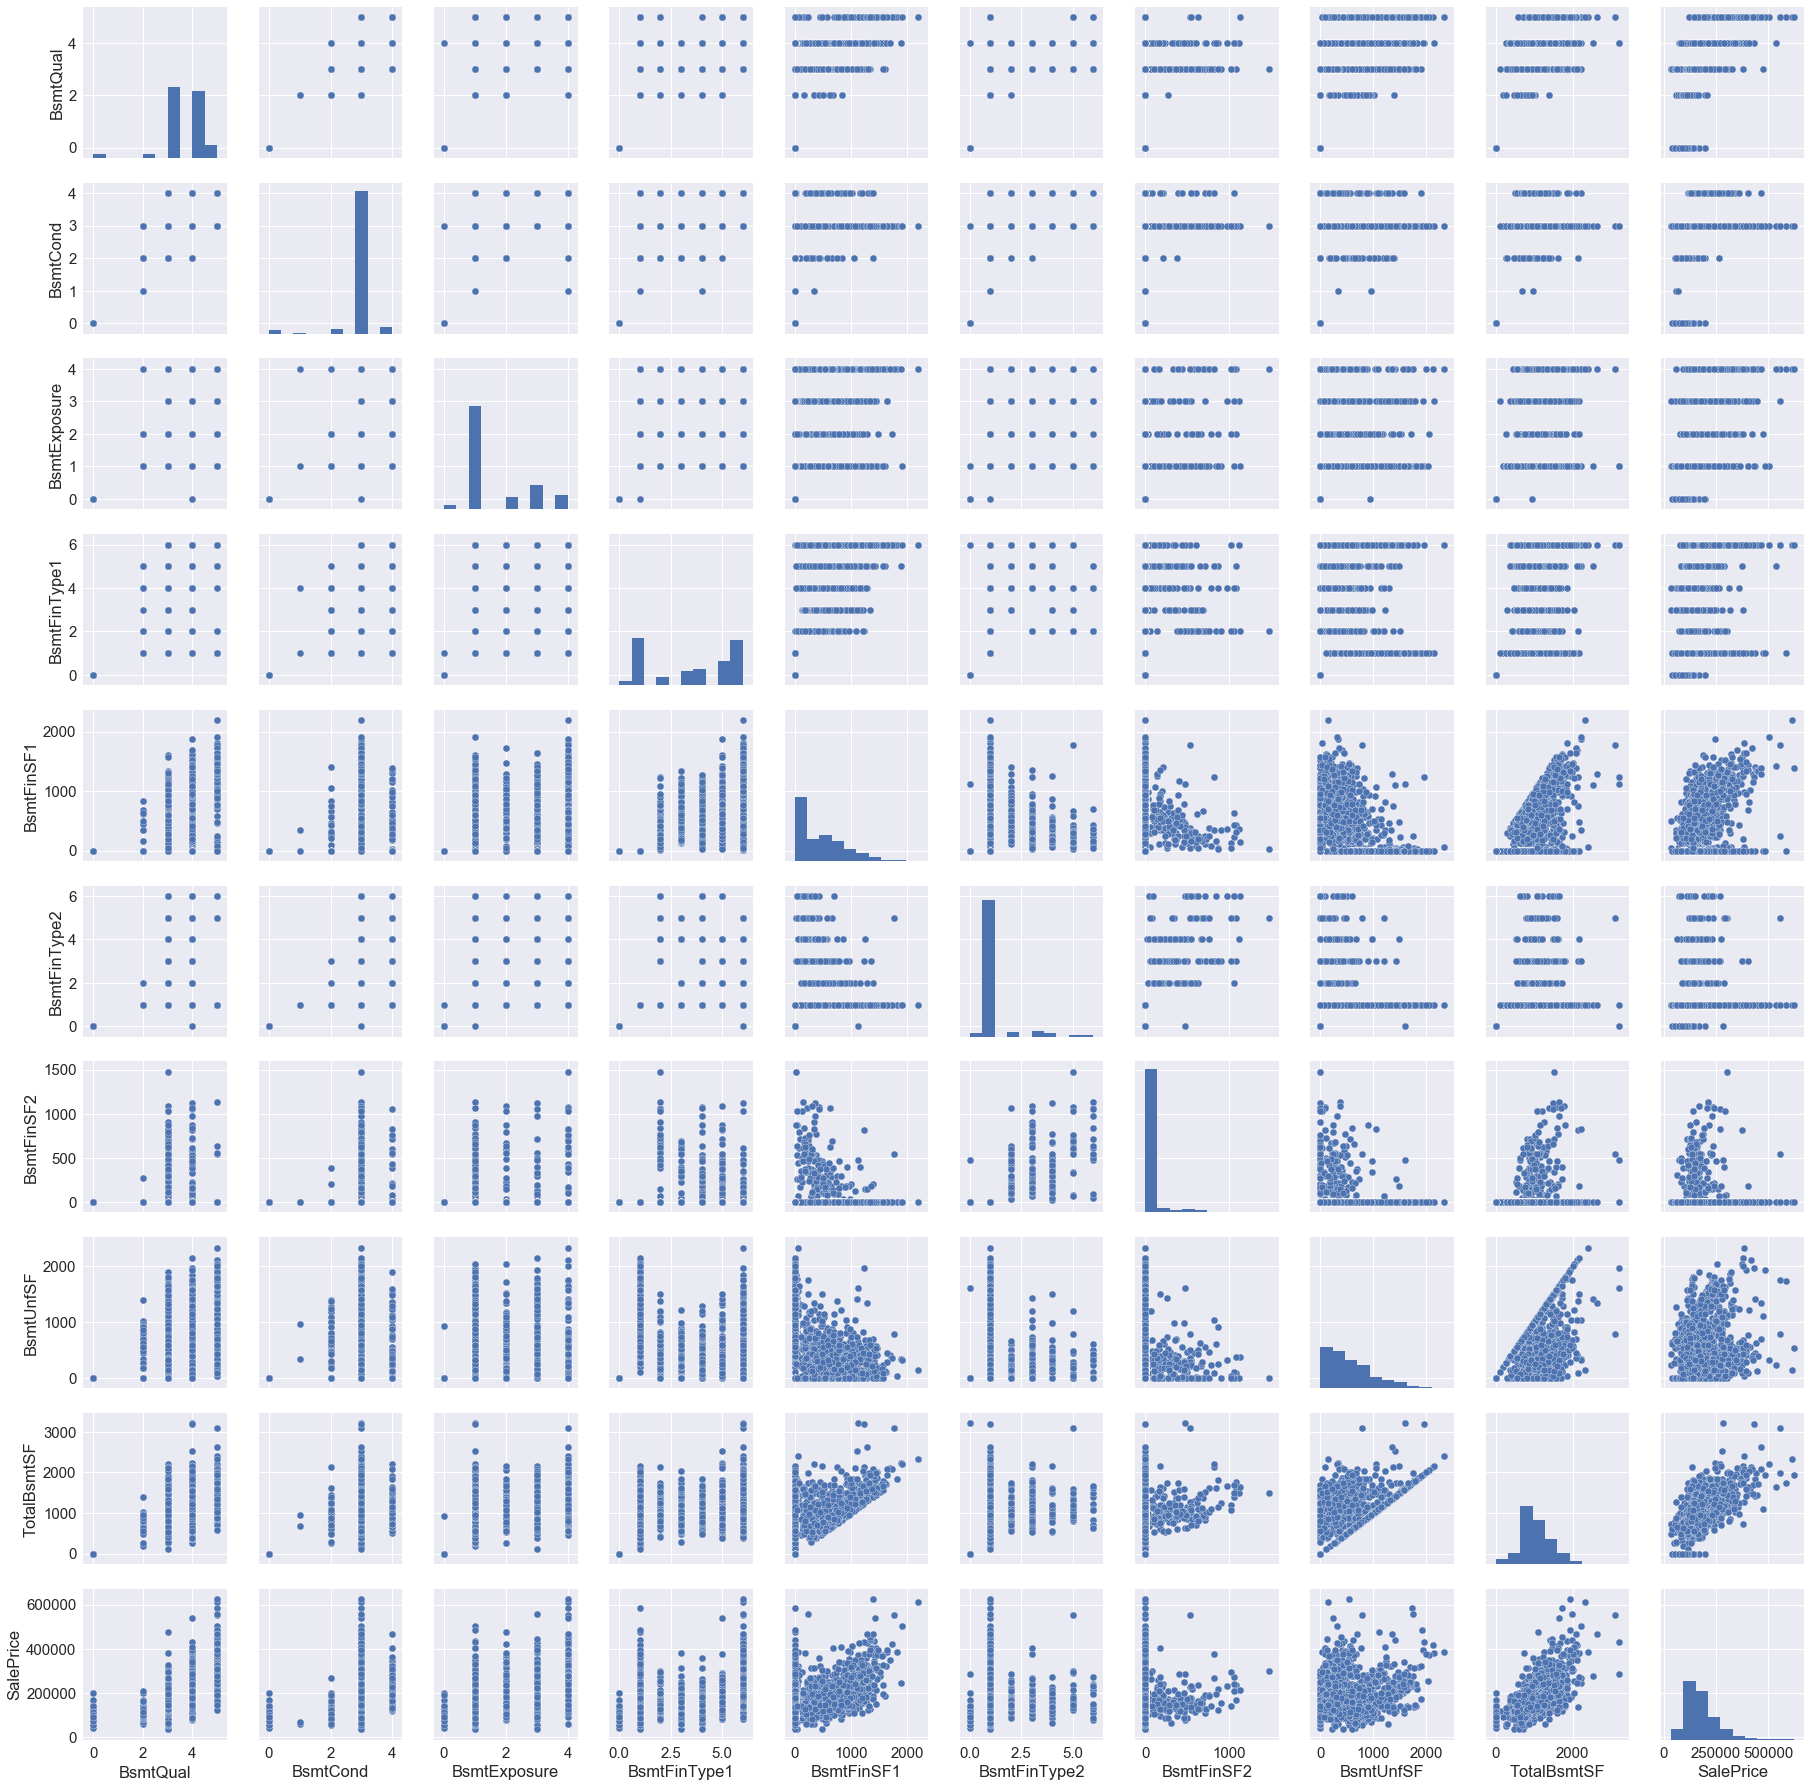

In [237]:
sns.pairplot(train_data[feature_set_basement])

From the above correlation and scatter matrix, this feature set shows many pairs that are correlated. The pairs (`'BsmtCond'`, `'BsmtQual'`), (`'TotalBsmtSF'`, `'BsmtQual'`), (`'BsmtFinSF1'`, `'BsmtFinType1'`) and (`'BsmtFinSF2'`, `'BsmtFinType2'`) are highly correlated while `'TotalBsmtSF'` shows resonable correlation with most of the features. Additionally when we look at the scatter matrix we see that there is a clear boundary with `'TotalBsmtSF'` and (`'BsmtFinSF1'`, `'BsmtUnfSF1'`). Also the nature of those features suggest that they can be combined. Let's take a look at some samples to see if we can create a new feature out of the current feature set.

In [238]:
display(train_data[feature_set_basement].sample(10))

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
Id                                                                 
674          3         3             1             6      1186.0   
720          4         3             4             5       523.0   
391          3         4             1             3       241.0   
713          4         3             2             6       767.0   
1433         3         3             1             1         0.0   
11           3         3             1             3       906.0   
1345         4         3             1             1         0.0   
792          4         3             3             5       539.0   
87           4         3             3             1         0.0   
345          4         3             1             3       129.0   

      BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  SalePrice  
Id                                                                 
674              1         0.0      291.0       1477.0   257500.0  
720              1         0.0      448.0        971.0   128500.0  
391              4       391.0      229.0        861.0   119000.0  
713              1         0.0      461.0       1228.0   189000.0  
1433             1         0.0      656.0        656.0    64500.0  
11               1         0.0      134.0       1040.0   129500.0  
1345             1         0.0      728.0        728.0   155835.0  
792              1         0.0      490.0       1029.0   146800.0  
87               1         0.0      684.0        684.0   174000.0  
345              4       232.0      175.0        536.0    85000.0

The table above shows that `'TotalBsmtSF'` is indeed split into three features namely `'BsmtFinSF1'`, `'BsmtFinSF2'` and `'BsmtUnfSF'` where `'TotalBsmtSF'` is the total of the three. We can remove those three features. Additionally `'BsmtCond'` can be removed since it's highly correlated with `'BsmtQual'`. Although `BsmtQual` is highly correlated with `'TotalBsmtSF'` it should not be removed since it's a measure of the overall Basement and also has high correlation with `'SalePrice'` itself. Regarding `'BsmtFinType1'`, we should keep it in the `'reduced_feature_set'` since we have already removed it's correlated paired feature `'BsmtFinSF1'`. However we can remove `'BsmtFinType2'` because it shows negligible correlation with the target variable `'SalePrice'`.

In [239]:
candidate_feature_removal.extend([ 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType2', 'BsmtUnfSF' ])

In [240]:
reduced_feature_set.extend([ 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF']


**Let's have a look at features that are closely related to the Rooms, Kitchens and Bathrooms of the House.**

In [241]:
print("feature_set_rooms_kitchen_bathrooms: {}".format(feature_set_rooms_kitchen_bathrooms))

feature_set_rooms_kitchen_bathrooms: ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd']


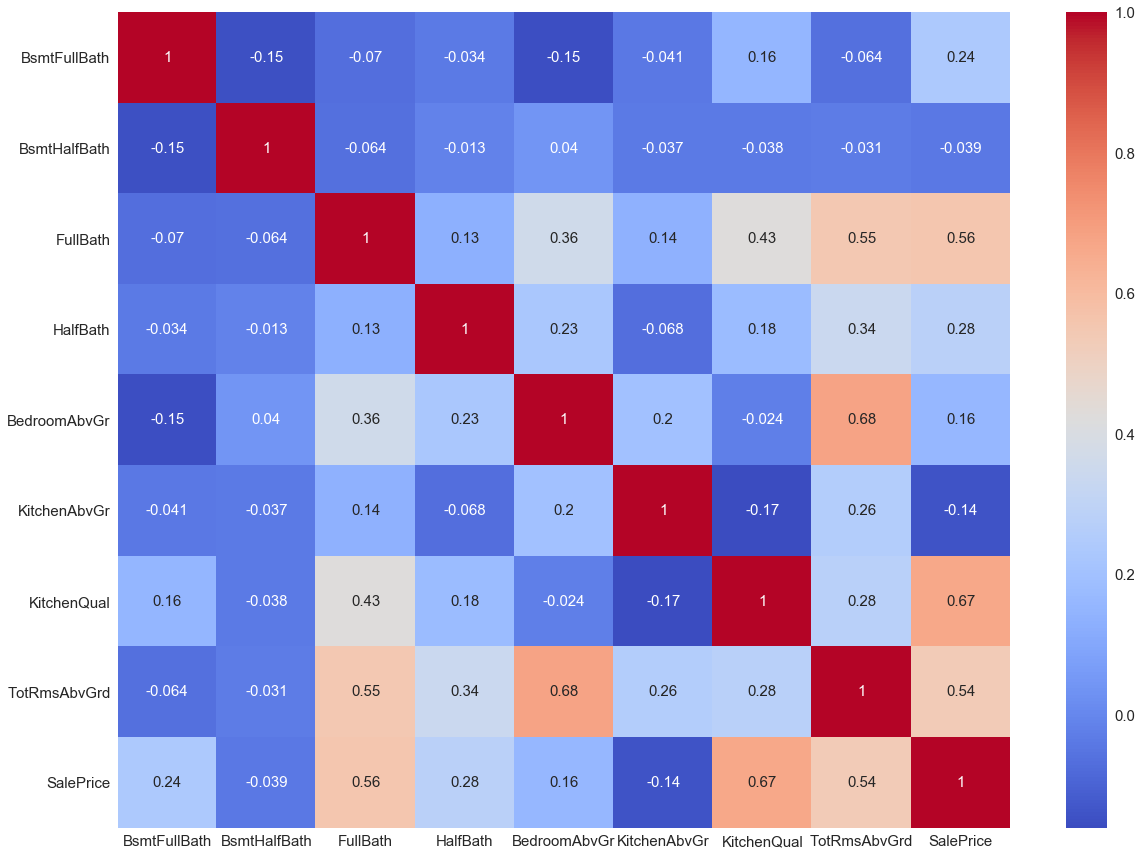

In [242]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_rooms_kitchen_bathrooms:
    feature_set_rooms_kitchen_bathrooms.append("SalePrice")
correlation = train_data[feature_set_rooms_kitchen_bathrooms].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

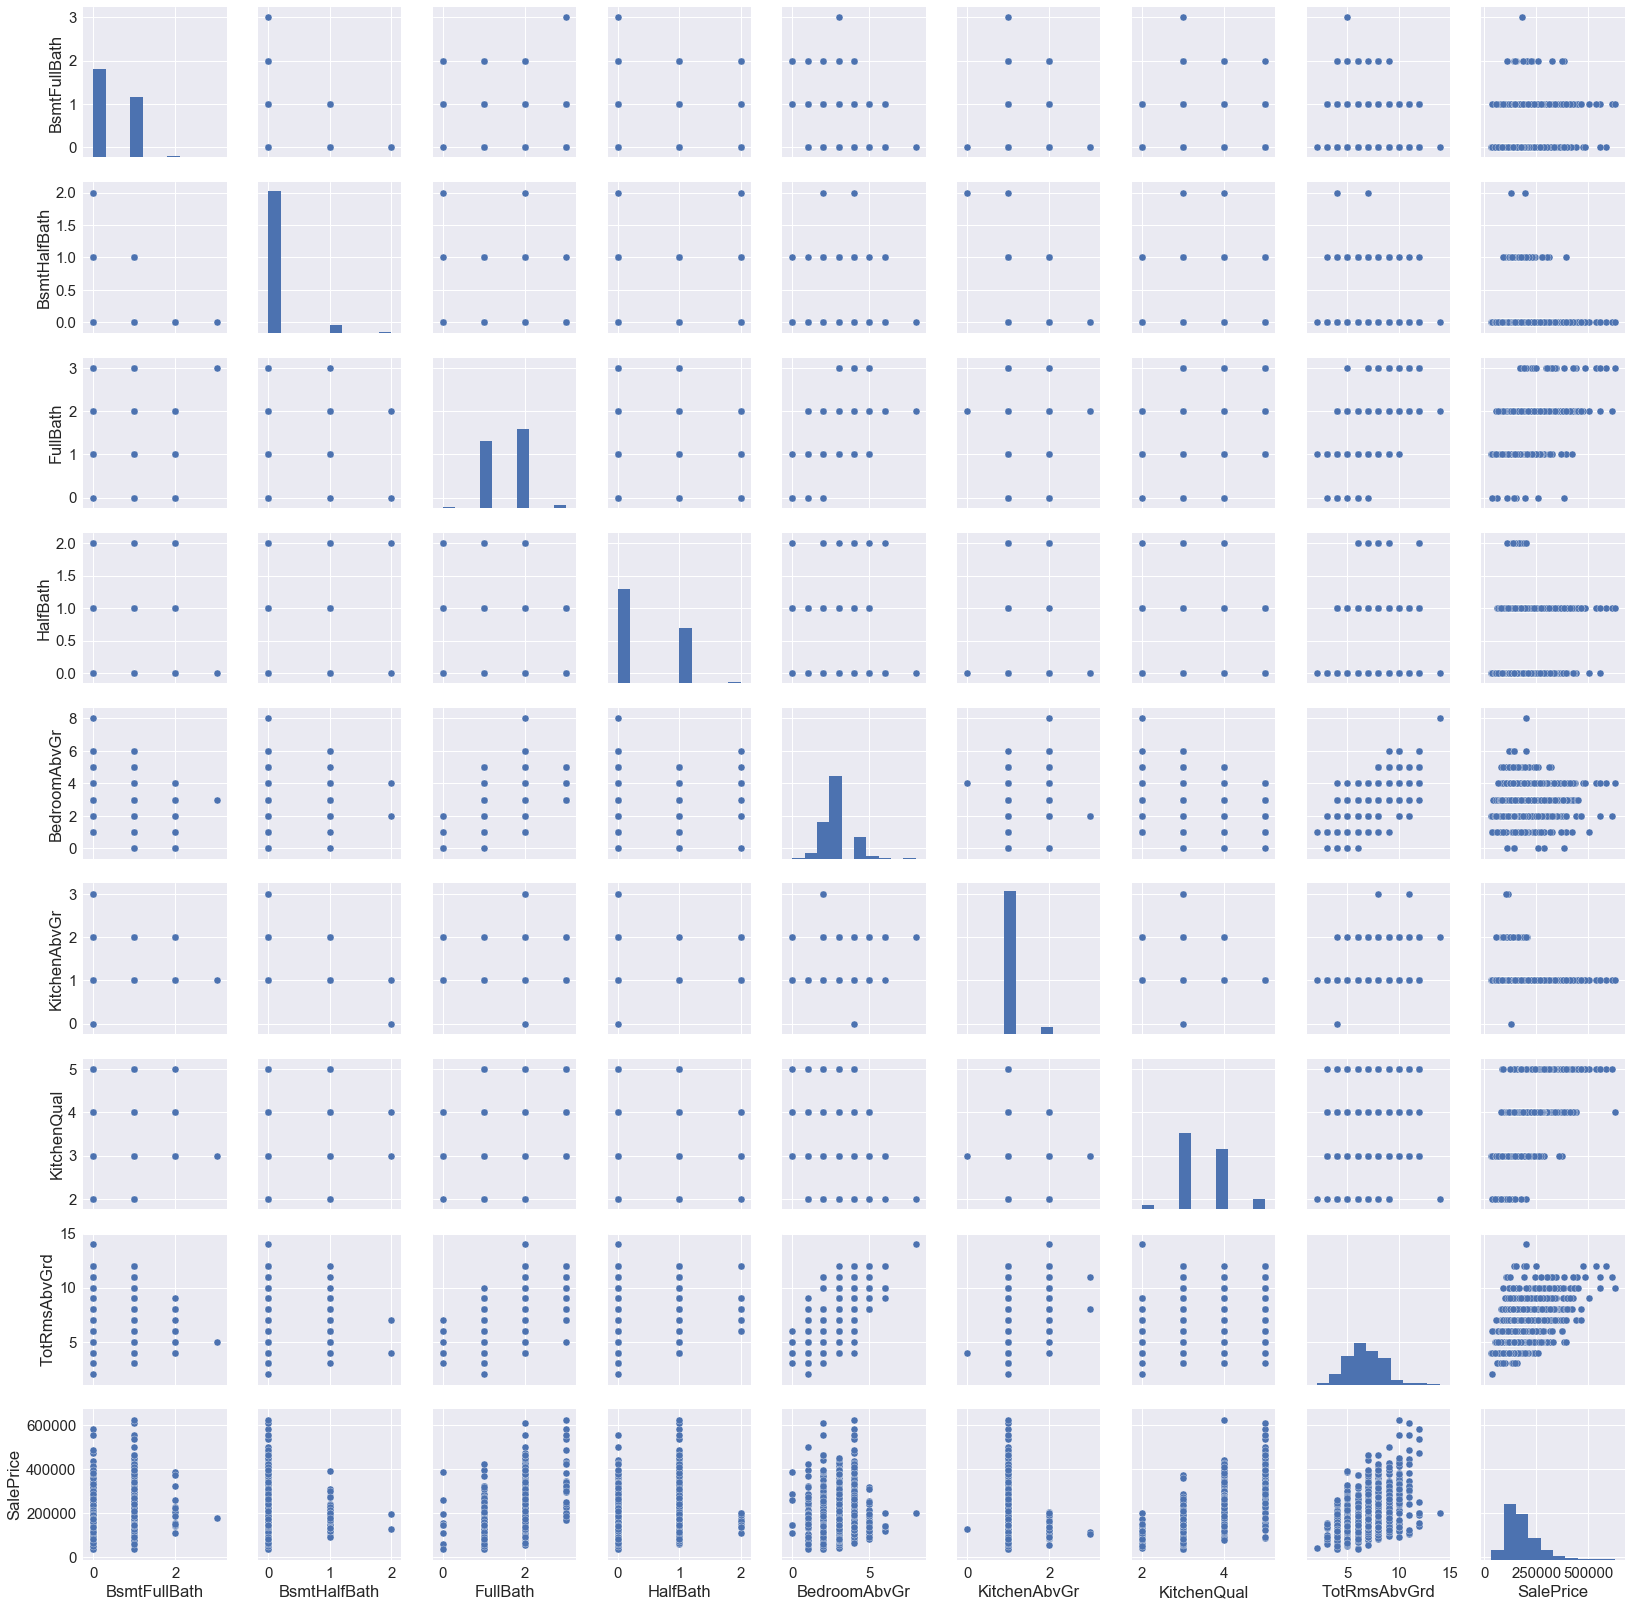

In [243]:
sns.pairplot(train_data[feature_set_rooms_kitchen_bathrooms])

`'TotRmsAbvGrd'` shows high correlation with `'FullBath'` and `'BedroomAbvGr'`. We can remove `'BedroomAbvGr'`. `'FullBath'` is kept for now since `'TotRmsAbvGrd'` does not include bathrooms according to the data description. `'BsmtHalfBath'` shows negligible correlation with the target variable `'SalePrice'` and thus can be removed. `'KitchenQual'` is an important feature when predicting `'SalePrice'`.

In [244]:
candidate_feature_removal.extend([ 'BedroomAbvGr', 'BsmtHalfBath' ])

In [245]:
reduced_feature_set.extend([ 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd']


**Let's have a look at features that are closely related to the Amenities of the House.**

In [246]:
print("feature_set_amenities: {}".format(feature_set_amenities))

feature_set_amenities: ['Utilities', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Fireplaces', 'FireplaceQu', 'PoolArea', 'PoolQC', 'MiscFeature']


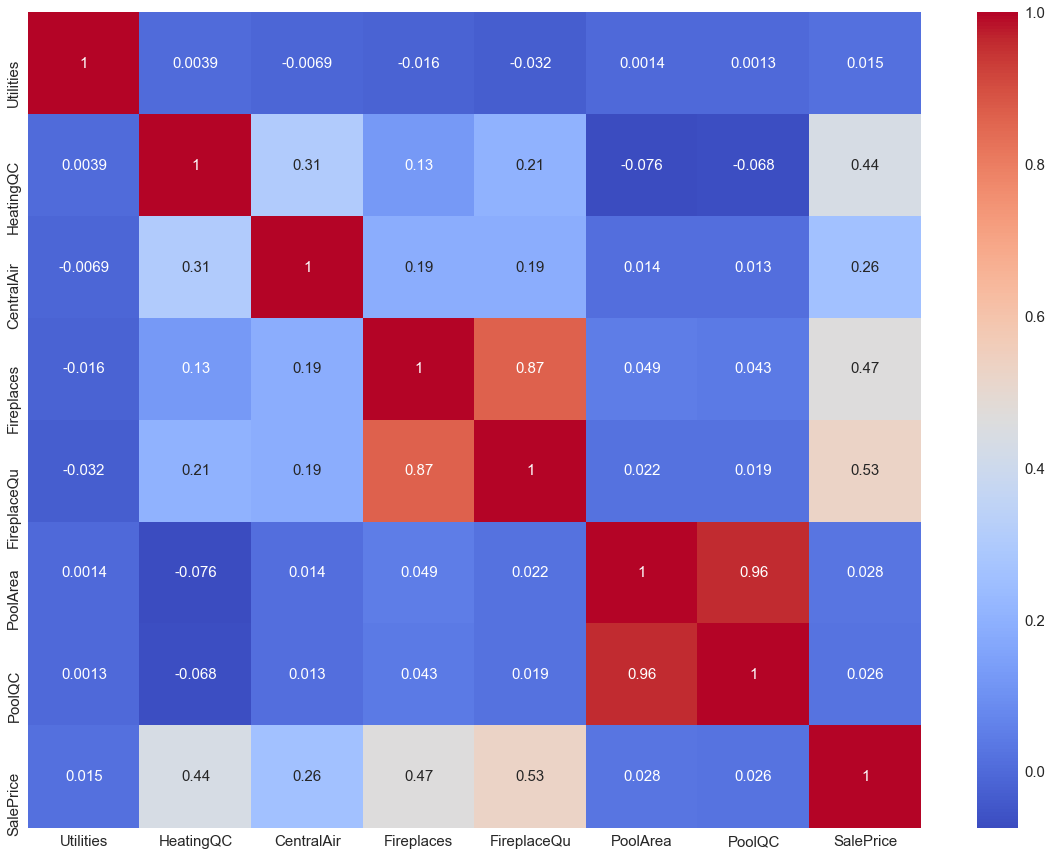

In [247]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_amenities:
    feature_set_amenities.append("SalePrice")
correlation = train_data[feature_set_amenities].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

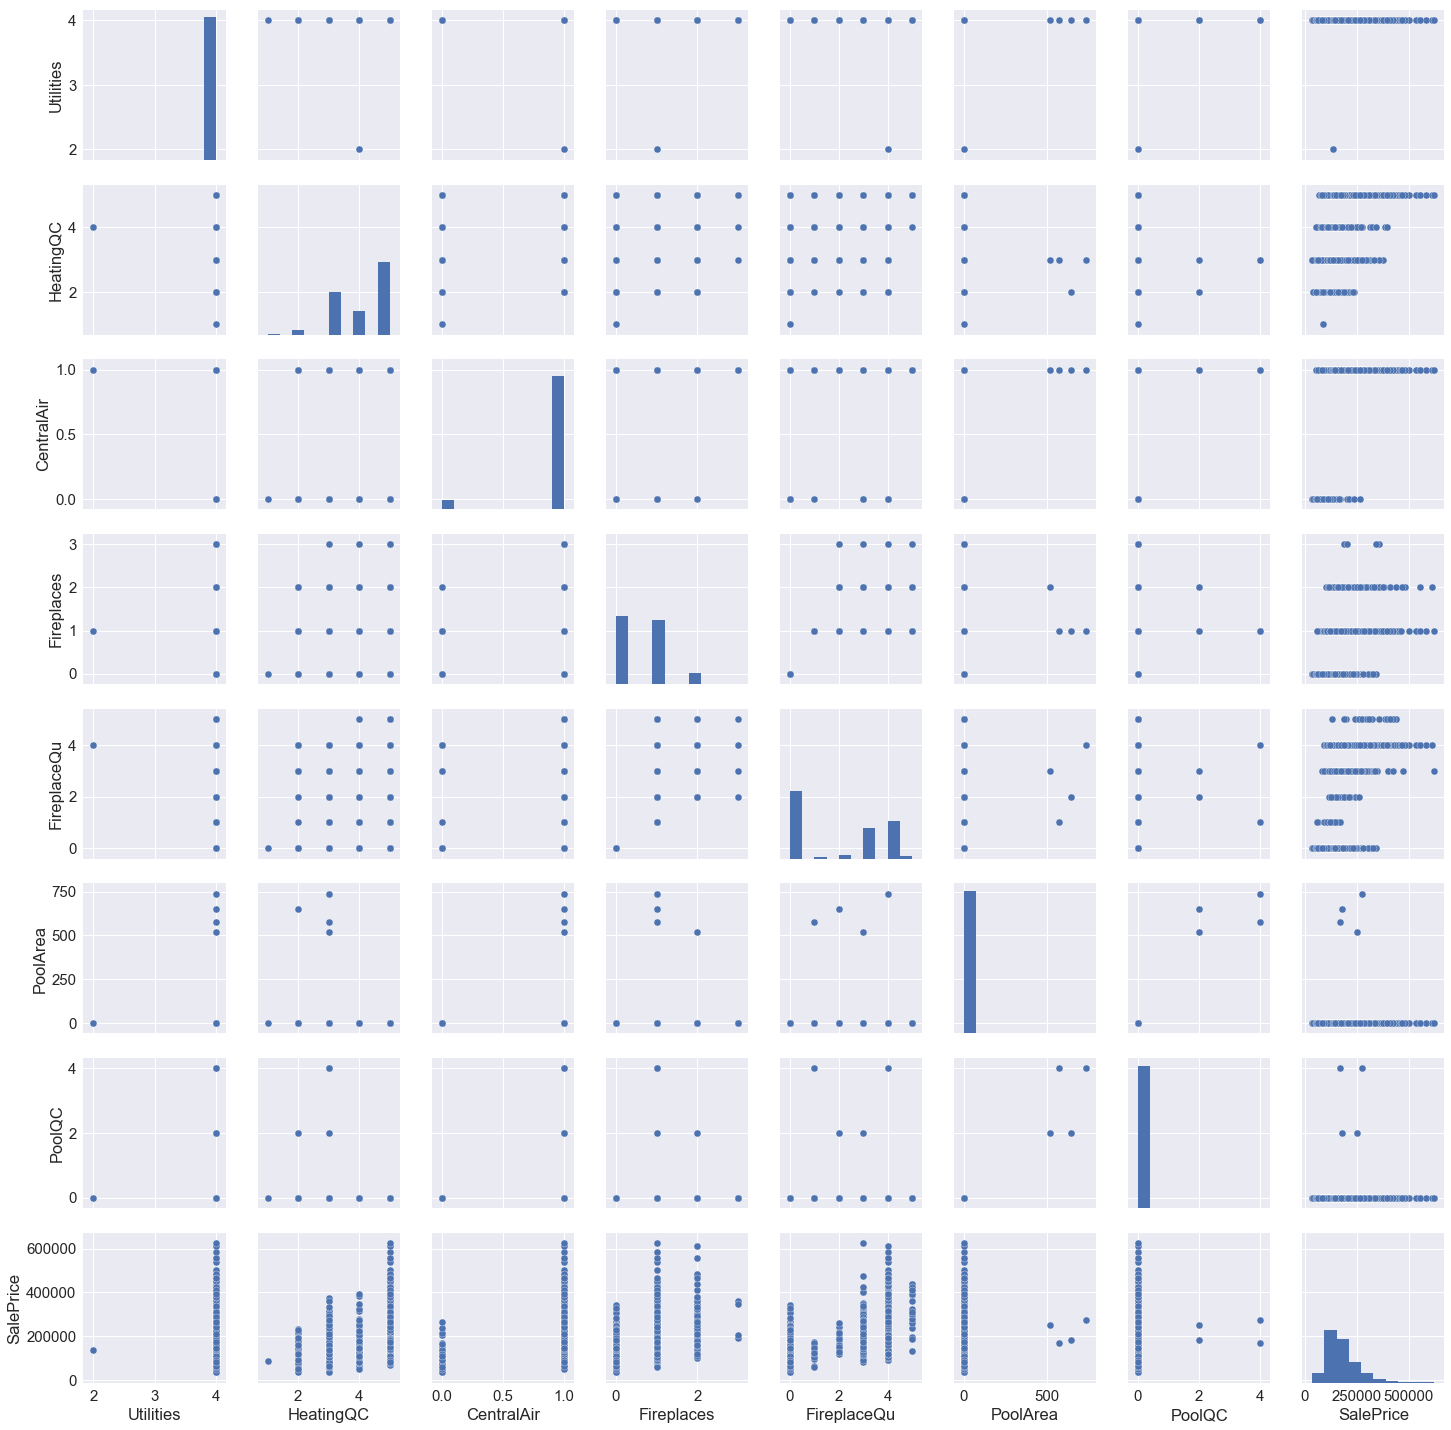

In [248]:
sns.pairplot(train_data[feature_set_amenities])

From the above correlation and scatter matrix, we can see that (`'FireplaceQu'`, `'Fireplaces'`) and (`'PoolQC'`, `'PoolArea'`) show very high correlation. We should therefore remove `'Fireplaces'` and `'PoolQC'`. Additionally we can remove `'Utilities'` since it shows very little correlation with `'SalePrice'` probably because it is the most skewed variable in the feature set. **Let's see how the remaining categorical (nominal) features affect house prices.**

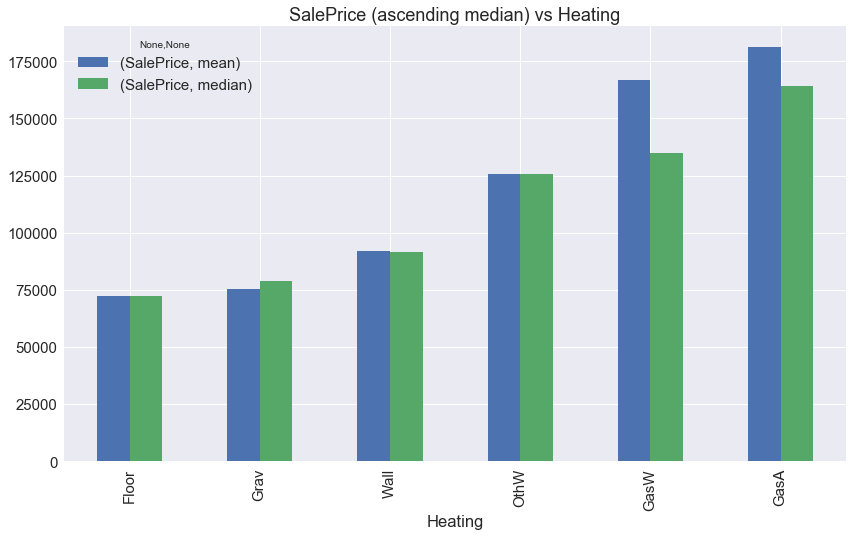

In [249]:
t = train_data.loc[:, ["Heating", "SalePrice"]].groupby("Heating").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Heating", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Heating", fontsize=15, figsize=(14, 8))

`'Heating'` should not be removed.

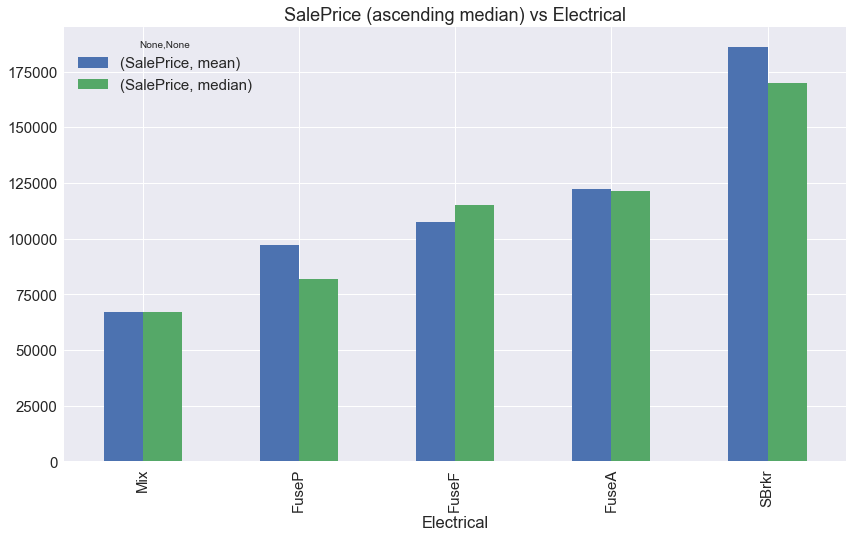

In [250]:
t = train_data.loc[:, ["Electrical", "SalePrice"]].groupby("Electrical").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Electrical", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Electrical", fontsize=15, figsize=(14, 8))

`'Electrical'` should not be removed.

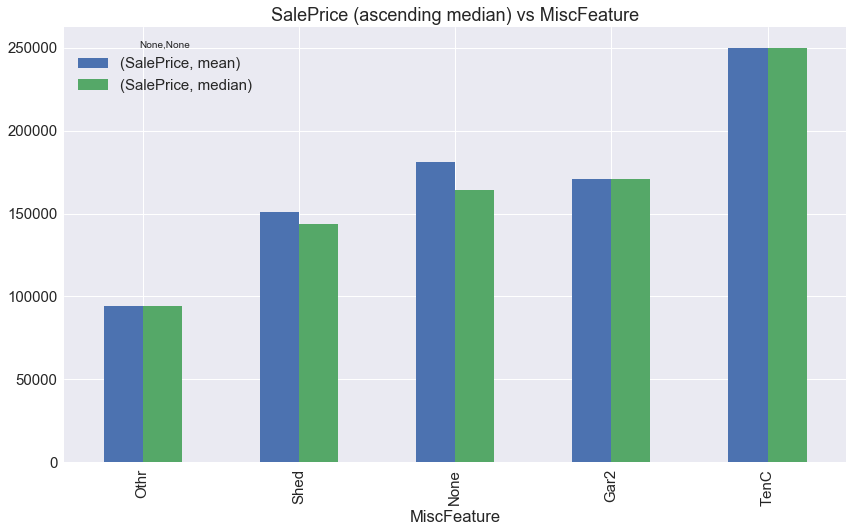

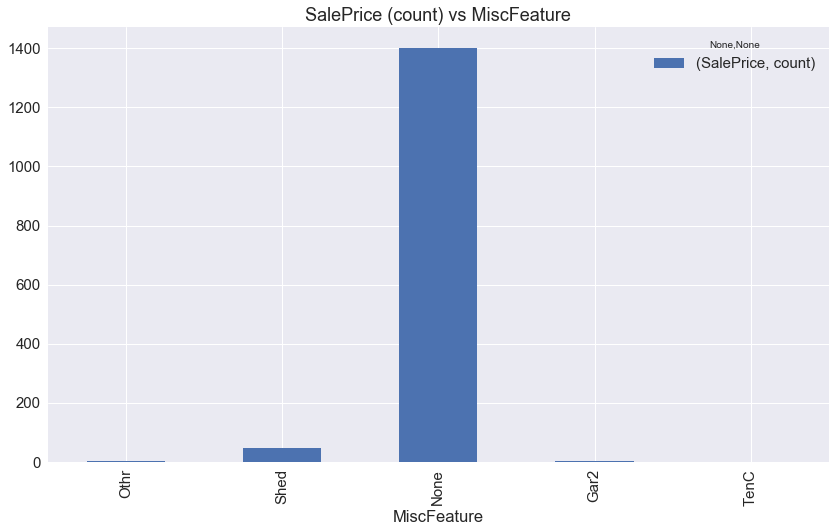

In [251]:
t = train_data.loc[:, ["MiscFeature", "SalePrice"]].groupby("MiscFeature").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs MiscFeature", fontsize=15, figsize=(14, 8))
t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs MiscFeature", fontsize=15, figsize=(14, 8))

Remember that `'MiscFeature'` had a lot of missing values and therefore should be removed.

In [252]:
candidate_feature_removal.extend([ 'Utilities', 'Fireplaces', 'PoolQC', 'MiscFeature' ])

In [253]:
reduced_feature_set.extend([ 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea']


**Let's have a look at features that are closely related to the Garage of the House.**

In [254]:
print("feature_set_garage: {}".format(feature_set_garage))

feature_set_garage: ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']


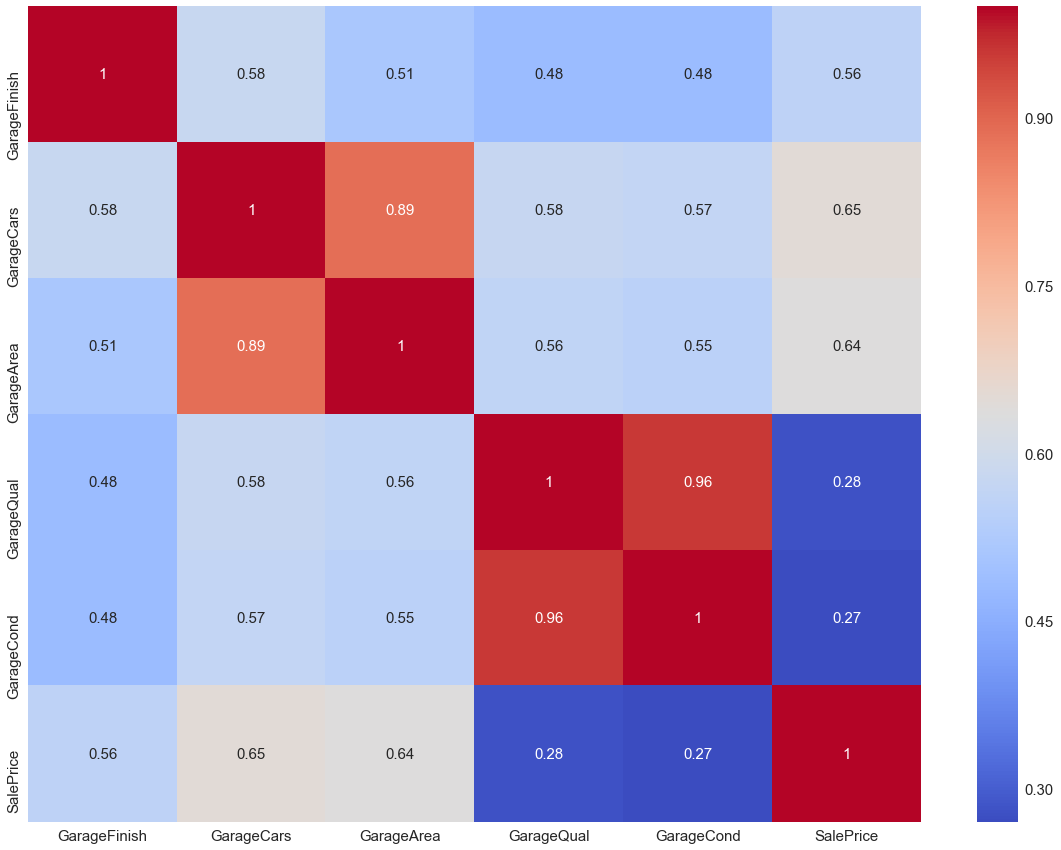

In [255]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_garage:
    feature_set_garage.append("SalePrice")
correlation = train_data[feature_set_garage].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

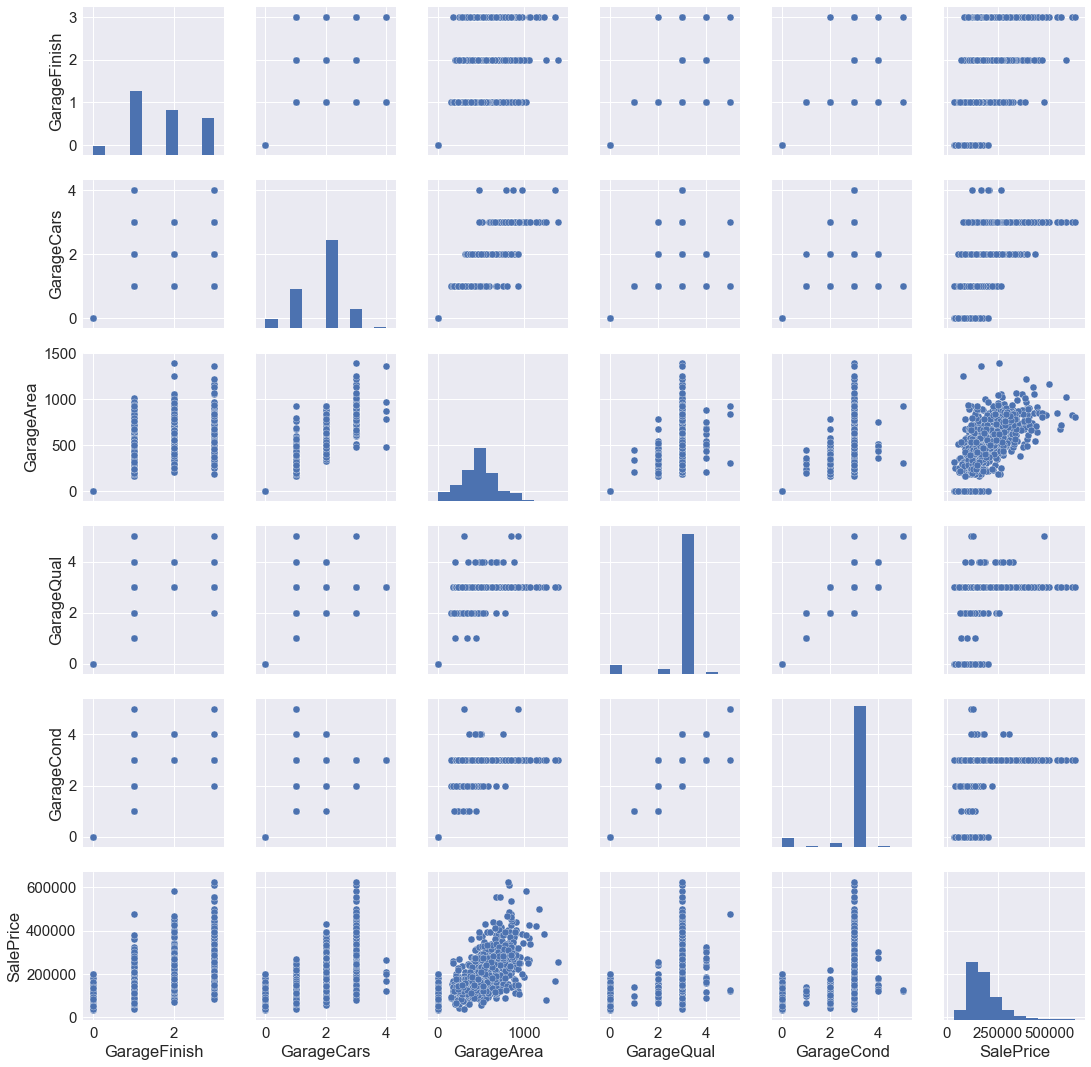

In [256]:
sns.pairplot(train_data[feature_set_garage])

From the above correlation and scatter matrix we see that (`'GarageArea'`, `'GarageCars'`) and (`'GarageCond'`, `'GarageQual'`) show high correlation. We should therefore remove `'GarageArea'` and `'GarageCond'` from the feature set. **Let's see how the remaining categorical (nominal) feature affect house prices.**

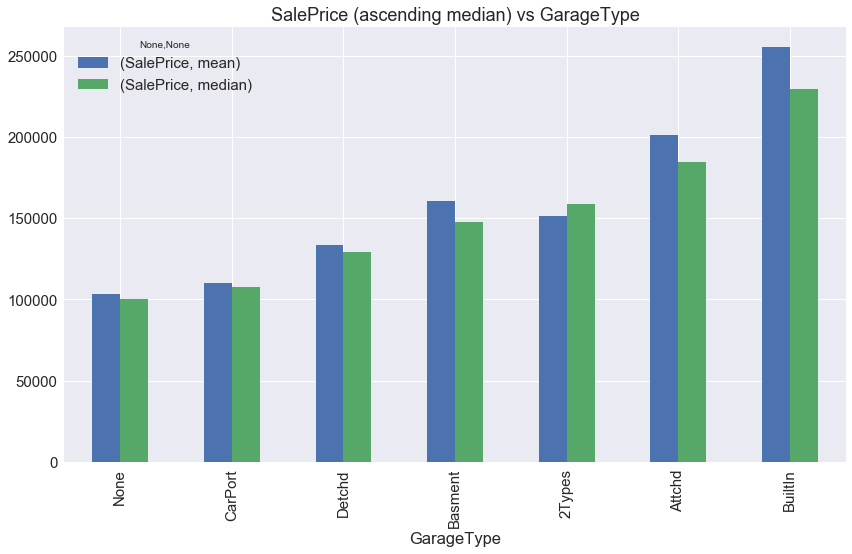

In [257]:
t = train_data.loc[:, ["GarageType", "SalePrice"]].groupby("GarageType").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs GarageType", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs GarageType", fontsize=15, figsize=(14, 8))

`'GarageType'` should not be removed.

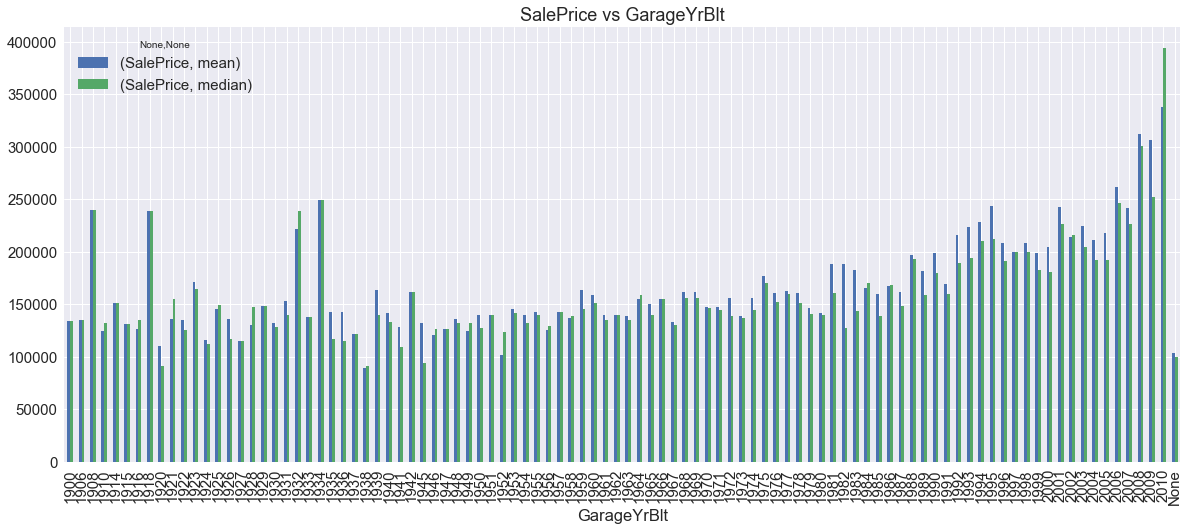

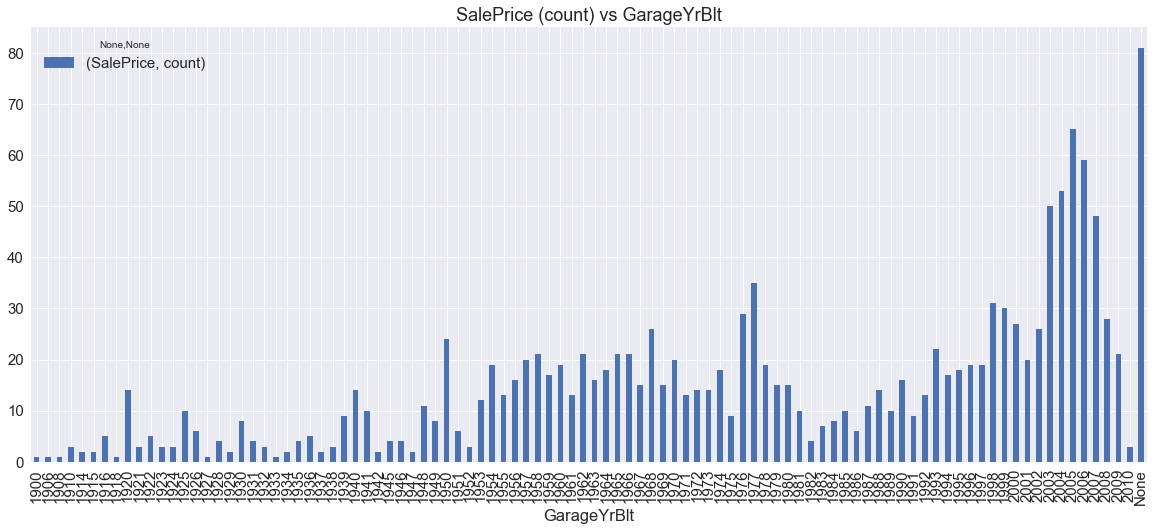

In [258]:
t = train_data.loc[:, ["GarageYrBlt", "SalePrice"]].groupby("GarageYrBlt").agg(["mean", "median", "count"])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice vs GarageYrBlt", fontsize=15, figsize=(20, 8))
t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs GarageYrBlt", fontsize=15, figsize=(20, 8))

Houses with recent Garages built have higher prices. This might also be true since the houses itself are built recently. Since there were few houses with no garages the data type for the same was an object. However if we remove those houses we can find the correlation between `'GarageYrBlt'` and `'YearBuilt'`. Let's remove the houses with no garages and see the correlation with `'YearBuilt'`.

In [259]:
# Remove houses with no Garage.
houses_with_garages = train_data.loc[:, ["GarageYrBlt", "YearBuilt", "SalePrice"]].loc[train_data.GarageYrBlt != "None"]
# Make it numerical so that correlation succeeds.
houses_with_garages.GarageYrBlt = houses_with_garages.GarageYrBlt.astype(int)
# Find correlation.
correlation = houses_with_garages.corr()
display(correlation)

GarageYrBlt  YearBuilt  SalePrice
GarageYrBlt     1.000000   0.824710   0.501583
YearBuilt       0.824710   1.000000   0.522118
SalePrice       0.501583   0.522118   1.000000

As suspected (`'GarageYrBlt'`, `'YearBuilt'`) has high correlation, with `'YearBuilt'` having higher correlation with `'SalePrice'`. Therefore we should remove `'GarageYrBlt'` from the feature set.

In [260]:
candidate_feature_removal.extend([ 'GarageYrBlt', 'GarageArea', 'GarageCond' ])

In [261]:
reduced_feature_set.extend([ 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual']


**Let's have a look at features that are closely related to the Porch of the House.**

In [262]:
print("feature_set_porch: {}".format(feature_set_porch))

feature_set_porch: ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']


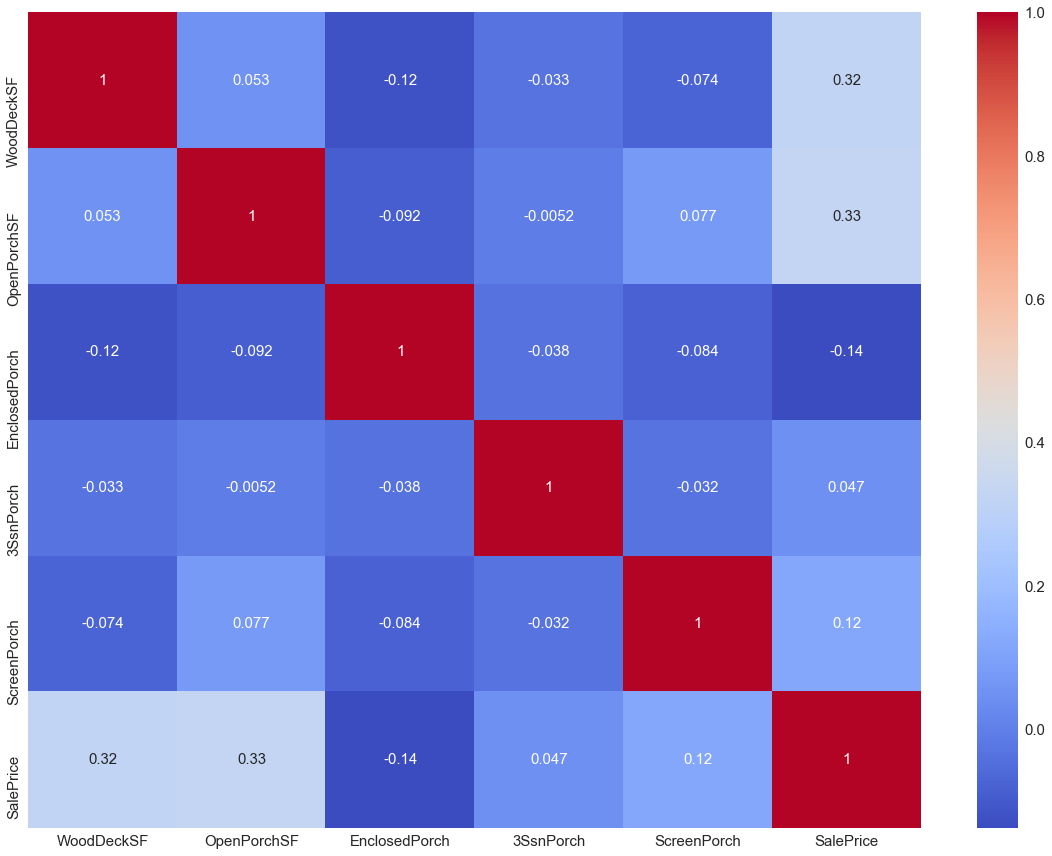

In [263]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_porch:
    feature_set_porch.append("SalePrice")
correlation = train_data[feature_set_porch].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

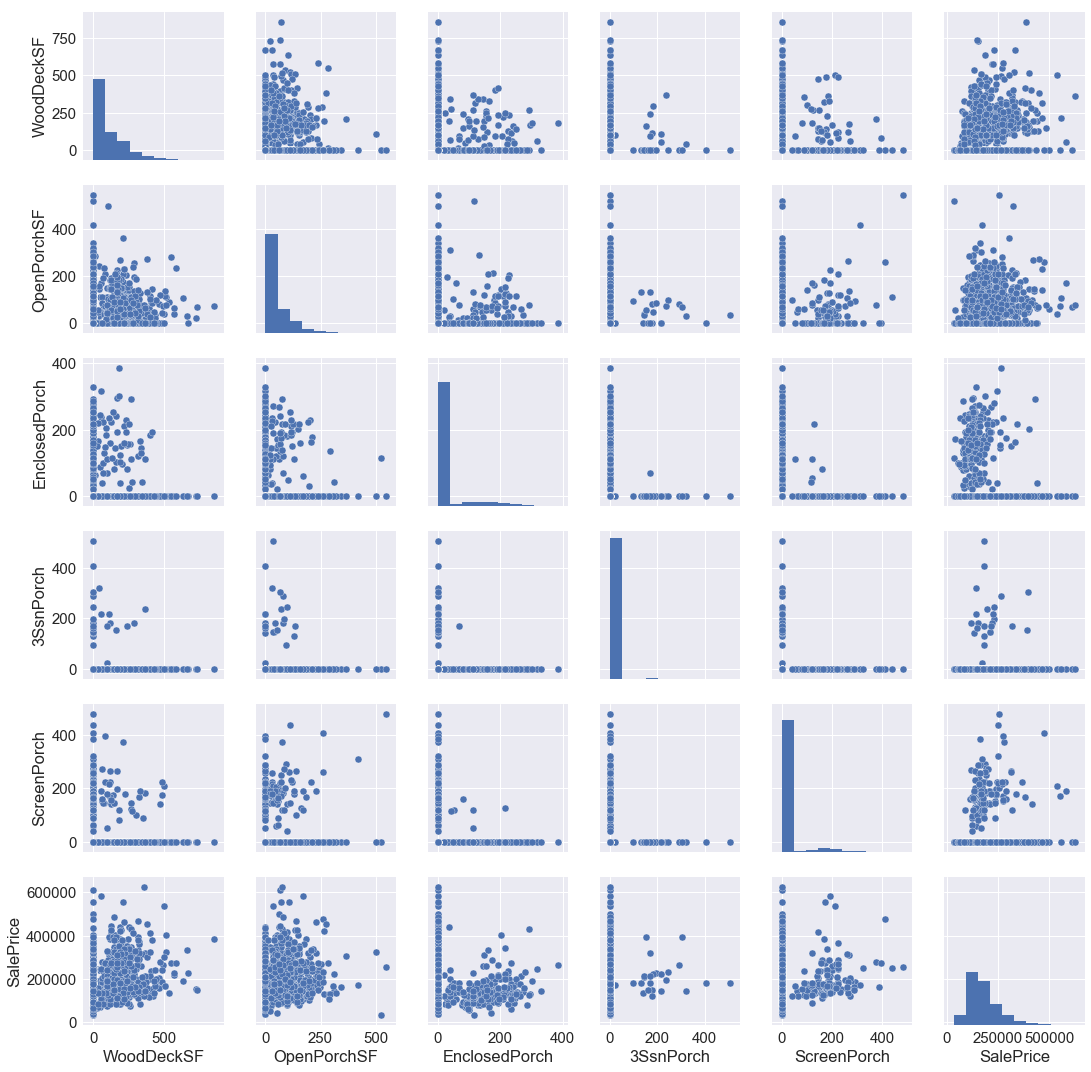

In [264]:
sns.pairplot(train_data[feature_set_porch])

From the above correlation and scatter matrix, we find that features in this set are fairly independent and show negligible correlation among themselves. However with respect to the target variable `'SalePrice'` we see that `'WoodDeckSF'` and `'OpenPorchSF'` show reasonable correlation whereas `'EnclosedPorch'` and `'ScreenPorch'` show low negative and low positive correlation respectively. `'3SsnPorch'` seems irrelevant when predicting house prices and therefore can be removed.

In [265]:
candidate_feature_removal.append('3SsnPorch')

In [266]:
reduced_feature_set.extend([ 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


**Let's have a look at features that are closely related to the Exterior finish of the House.**

In [267]:
print("feature_set_exterior_finish: {}".format(feature_set_exterior_finish))

feature_set_exterior_finish: ['OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond']


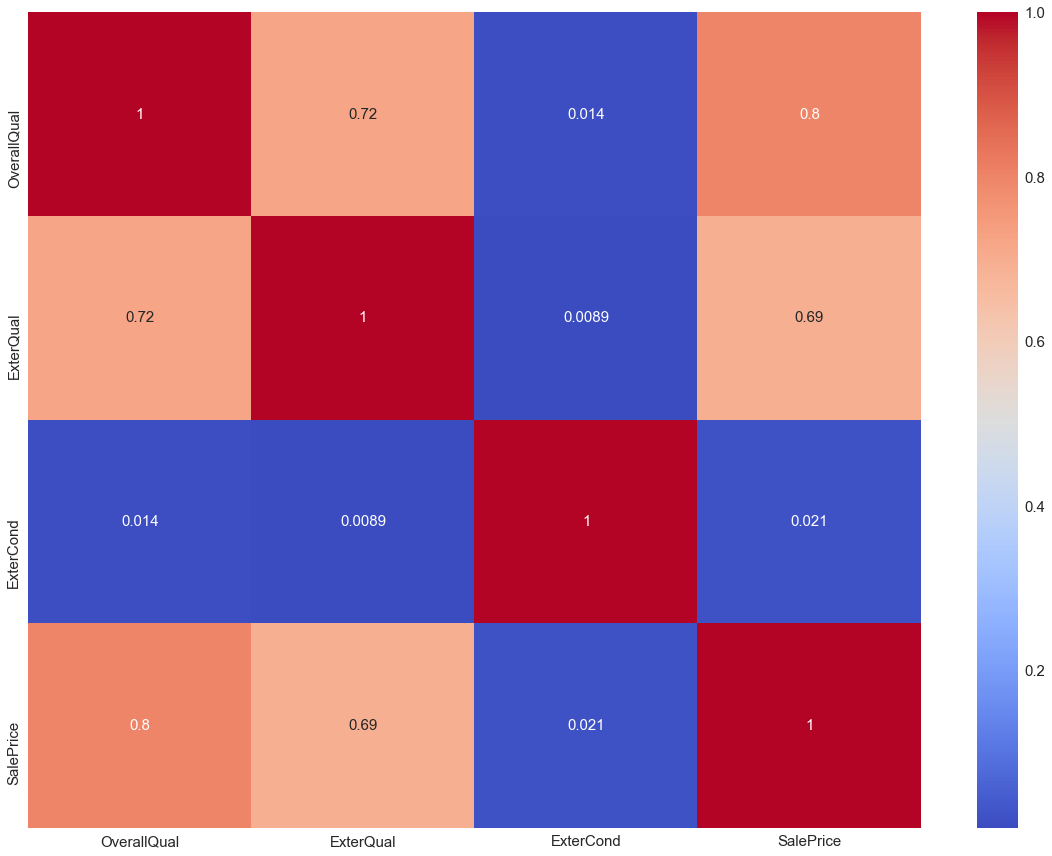

In [268]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_exterior_finish:
    feature_set_exterior_finish.append("SalePrice")
correlation = train_data[feature_set_exterior_finish].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

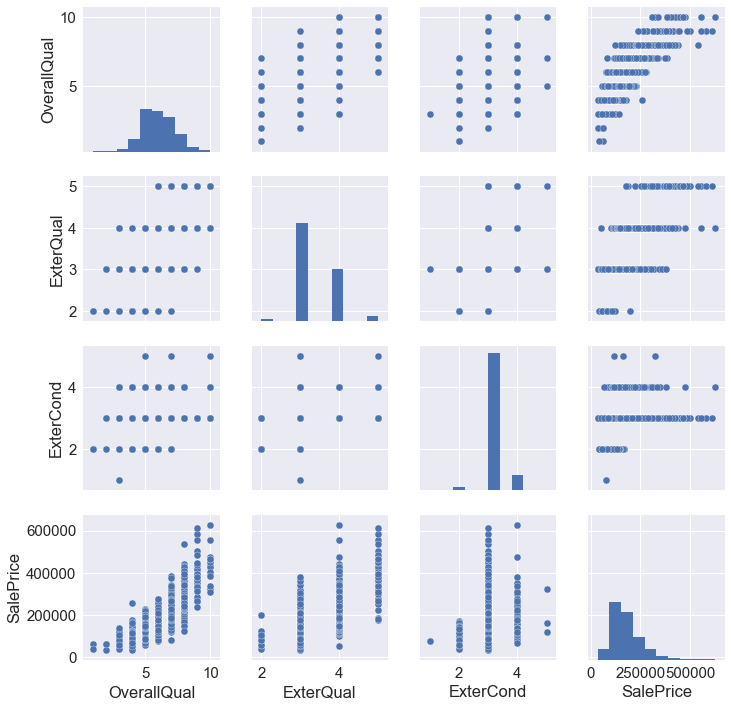

In [269]:
sns.pairplot(train_data[feature_set_exterior_finish])

From the above correlation and scatter matrix we can see that although `'ExterQual'` and `'OverallQual'` has high correlation, we should keep `'ExterQual'` since it's correlation with the target variable `'SalePrice'` is comparable to `'OverallQual'`. `'ExterCond'` and `'ExterQual'` does not have a high correlation which is surprising. `'ExterCond'` relationship with the target variable `'SalePrice'` doesn't seem linear. We see peaks for average houses w.r.t. `'ExterCond'`. **Let's see how the categorical (nominal) features affect house prices.**

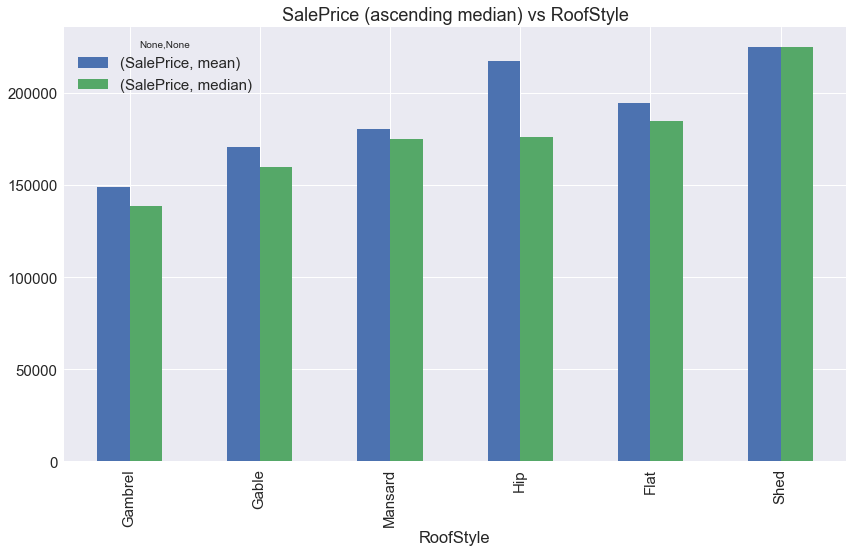

In [270]:
t = train_data.loc[:, ["RoofStyle", "SalePrice"]].groupby("RoofStyle").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs RoofStyle", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs RoofStyle", fontsize=15, figsize=(14, 8))

`'RoofStyle'` should not be removed.

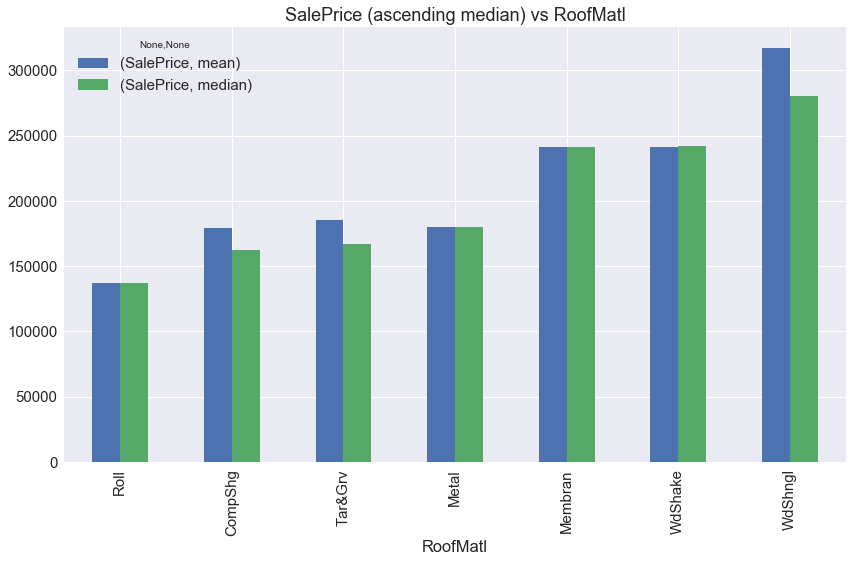

In [271]:
t = train_data.loc[:, ["RoofMatl", "SalePrice"]].groupby("RoofMatl").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs RoofMatl", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs RoofMatl", fontsize=15, figsize=(14, 8))

`'RoofMatl'` should not be removed.

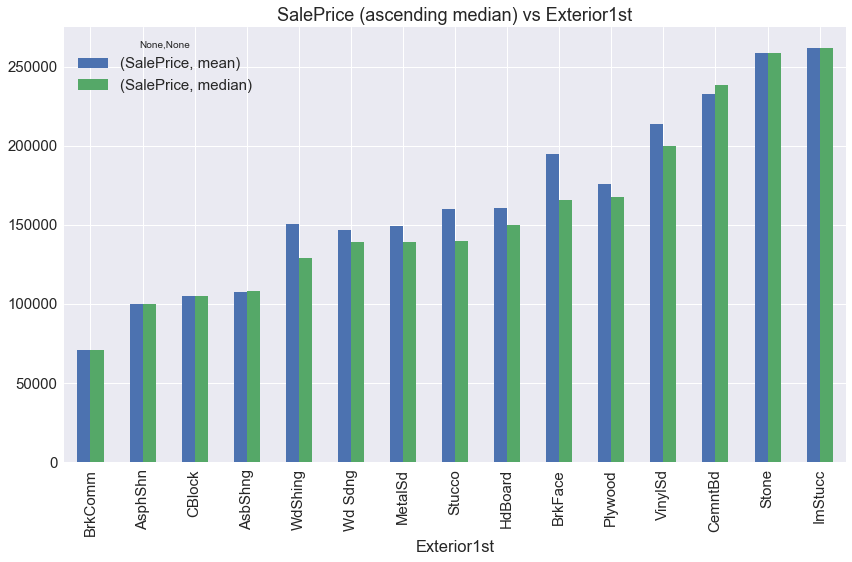

In [272]:
t = train_data.loc[:, ["Exterior1st", "SalePrice"]].groupby("Exterior1st").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Exterior1st", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Exterior1st", fontsize=15, figsize=(14, 8))

`'Exterior1st'` should not be removed.

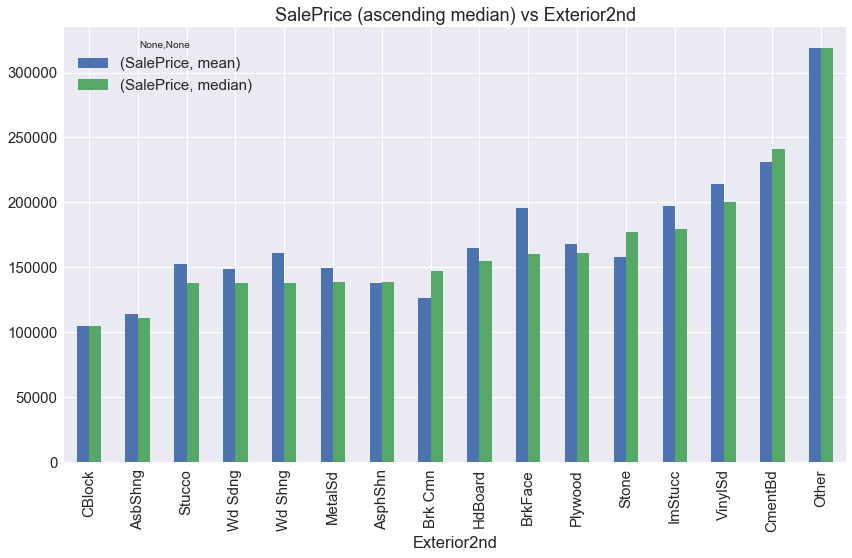

In [273]:
t = train_data.loc[:, ["Exterior2nd", "SalePrice"]].groupby("Exterior2nd").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Exterior2nd", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Exterior2nd", fontsize=15, figsize=(14, 8))

`'Exterior2nd'` should not be removed.

All the features in `'feature_set_exterior_finish'` are kept in the `'reduced_feature_set'`.

In [274]:
reduced_feature_set.extend([ 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond']


**Let's have a look at features that are closely related to the Lot of the House.**

In [275]:
print("feature_set_lot: {}".format(feature_set_lot))

feature_set_lot: ['LotFrontage', 'LotArea', 'LotShape', 'LotConfig']


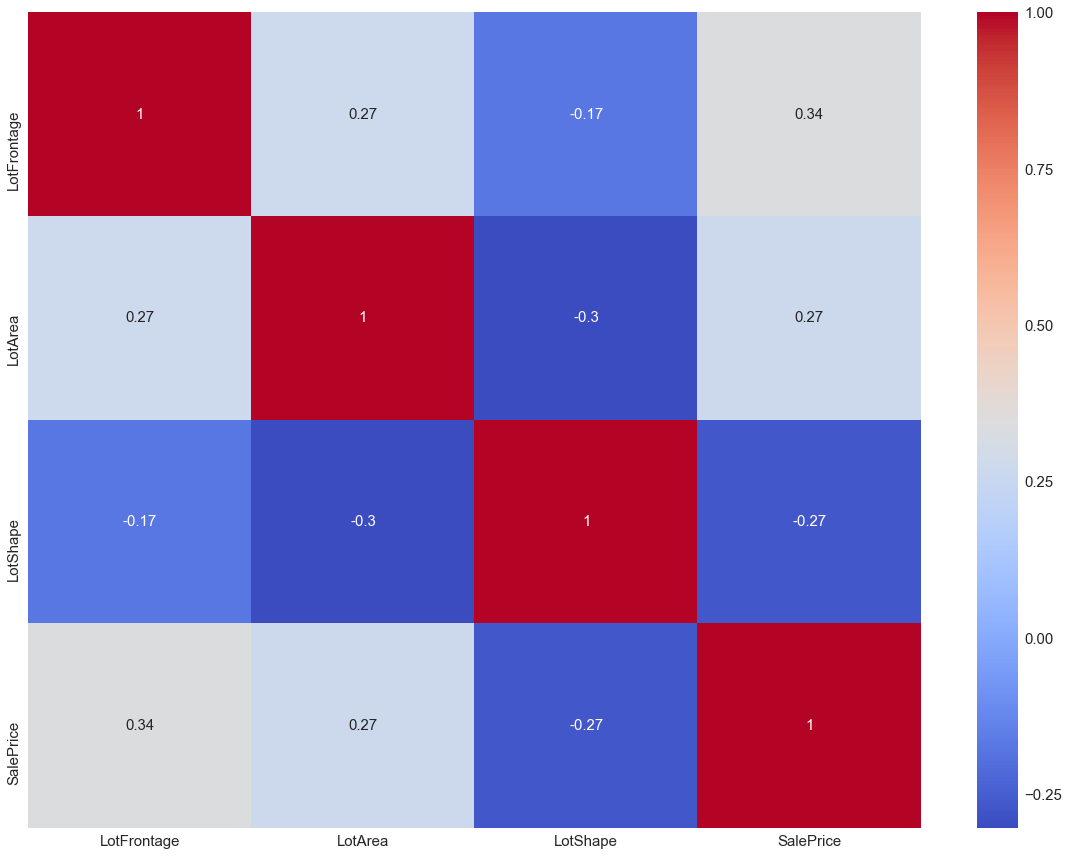

In [276]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_lot:
    feature_set_lot.append("SalePrice")
correlation = train_data[feature_set_lot].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

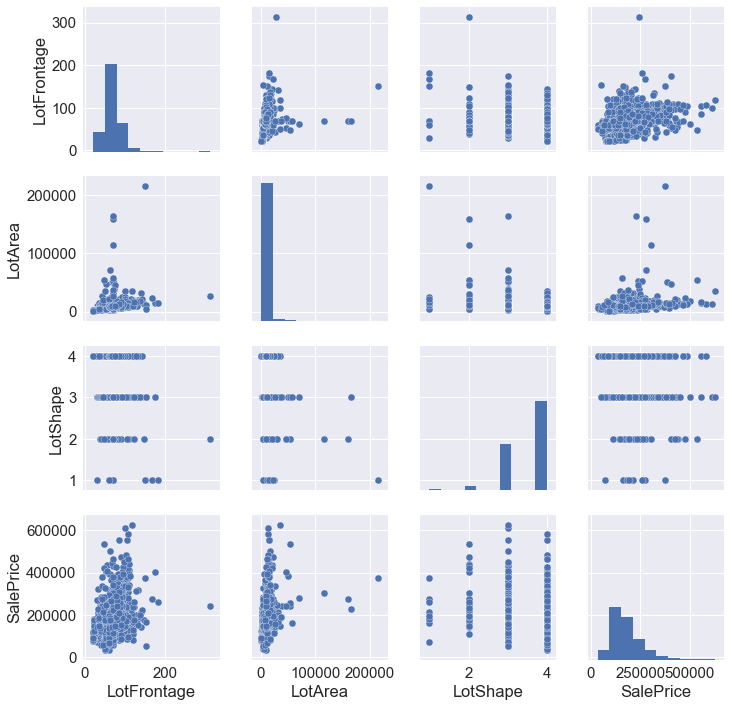

In [277]:
sns.pairplot(train_data[feature_set_lot])

From the above correlation and scatter matrix we can see that none of the features in the current feature set show high correlation with each other. Also `'SalePrice'` seems non linear w.r.t. `'LotShape'`. **Let's see how** `'LotConfig'` **affect house prices.**

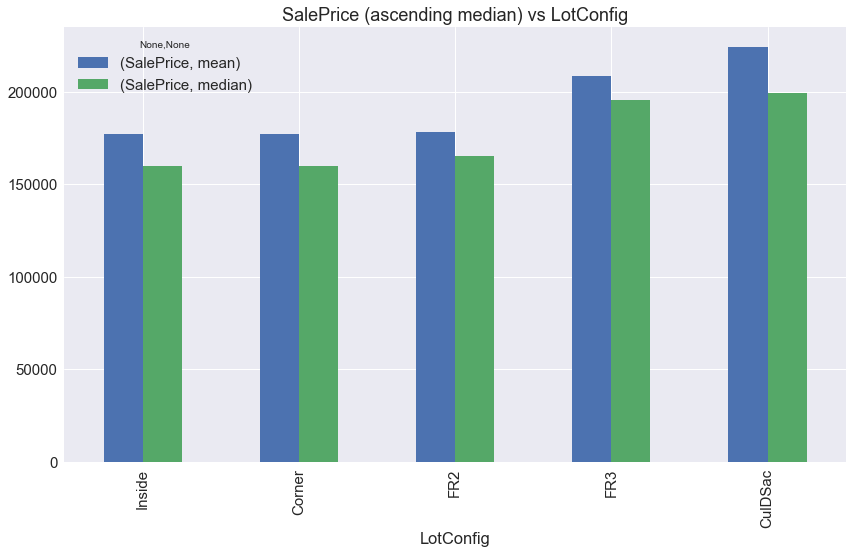

In [278]:
t = train_data.loc[:, ["LotConfig", "SalePrice"]].groupby("LotConfig").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs LotConfig", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs LotConfig", fontsize=15, figsize=(14, 8))

`'LotConfig'` should not be removed.

All the features in '`feature_set_lot`' are kept in the `'reduced_feature_set'`.

In [279]:
reduced_feature_set.extend([ 'LotShape', 'LotFrontage', 'LotArea', 'LotConfig' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'LotShape', 'LotFrontage', 'LotArea', 'LotConfig']


**Let's have a look at the remaining features of the House.**

In [280]:
print("feature_set_miscellaneous: {}".format(feature_set_miscellaneous))

feature_set_miscellaneous: ['PavedDrive', 'Street', 'Alley', 'Fence', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Foundation', 'Functional', 'MasVnrArea', 'MasVnrType', 'LandContour', 'LandSlope']


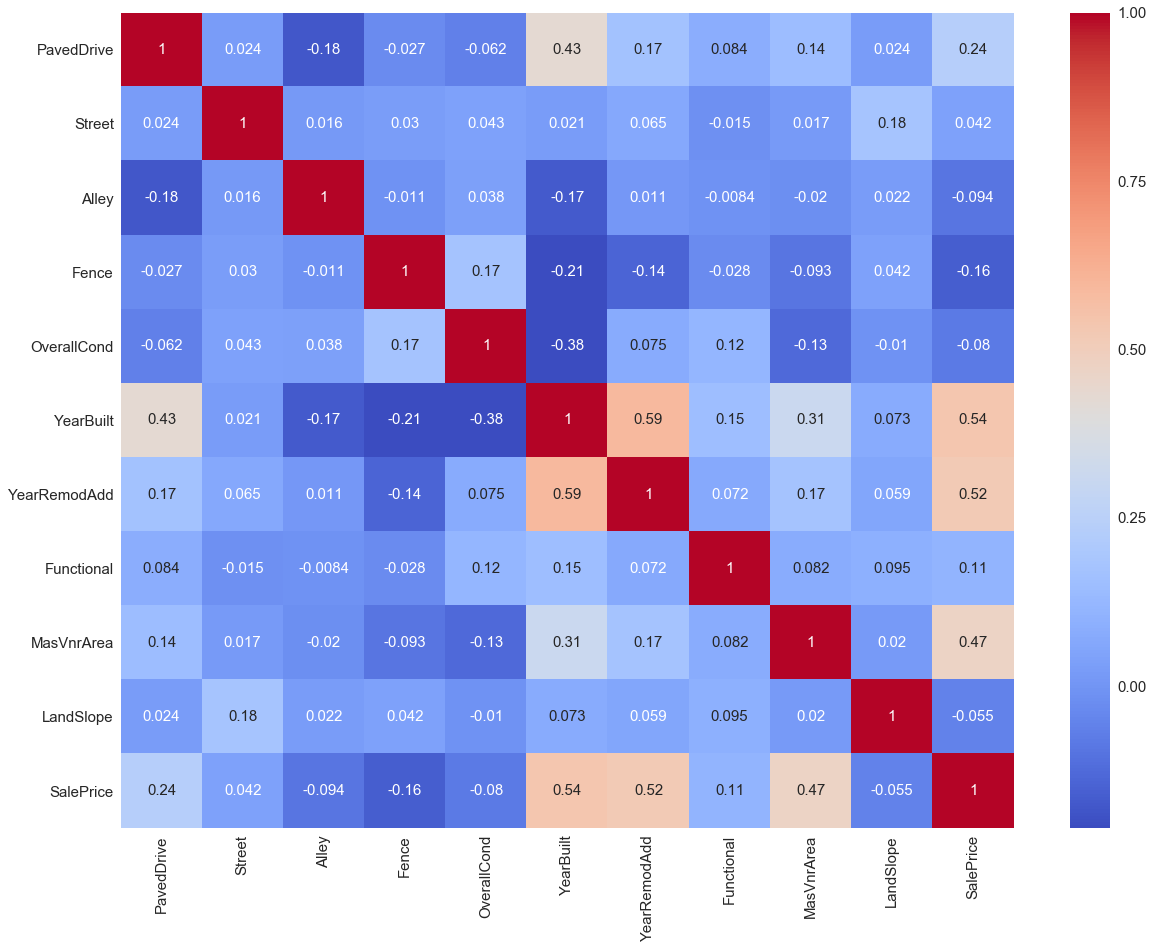

In [281]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in feature_set_miscellaneous:
    feature_set_miscellaneous.append("SalePrice")
correlation = train_data[feature_set_miscellaneous].corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True, annot_kws={"size": 15}, cmap="coolwarm", robust=True)

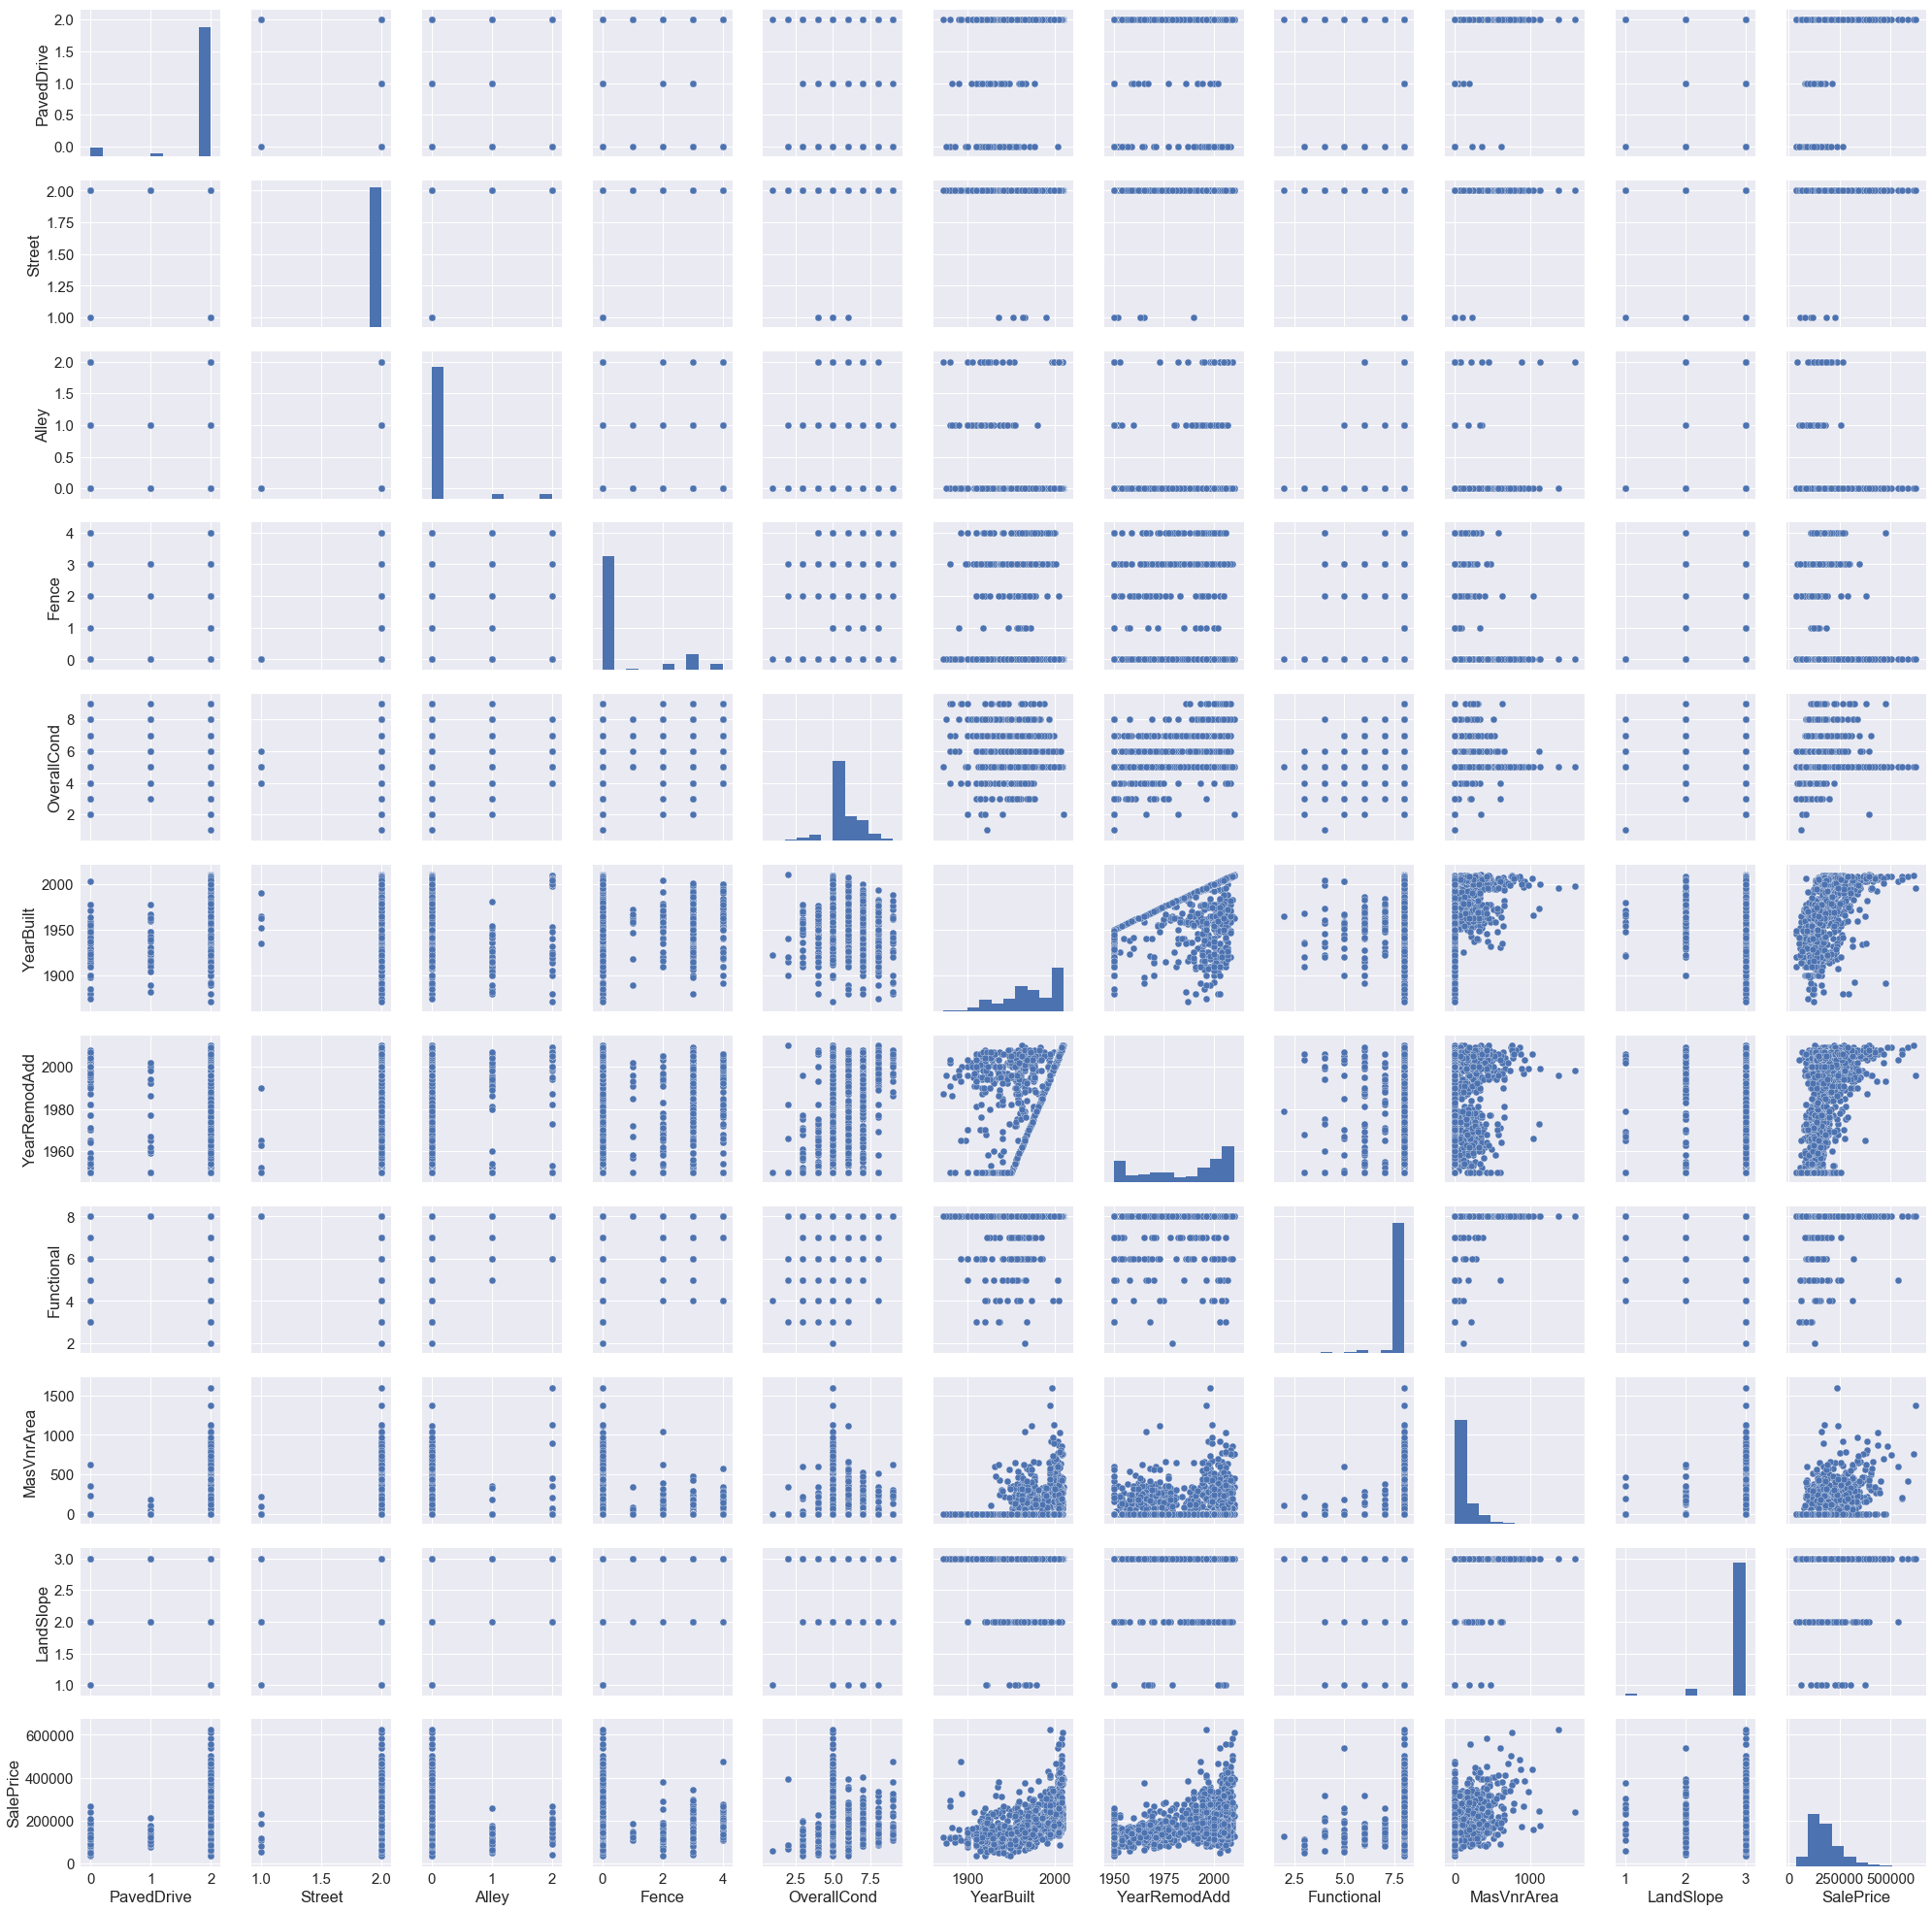

In [282]:
sns.pairplot(train_data[feature_set_miscellaneous])

From the above correlation and scatter matrix we can see that `'PavedDrive'` shows some correlation with `'YearBuilt'` while `'YearRemodAdd'` shows high correlation with `'YearBuilt'`. We can remove '`YearRemodAdd`' from our feature set. Also `'LandSlope'` seems irrelevant when predicting house prices and therefore should be removed. **Let's see how the remaining categorical (nominal) features affect house prices.**

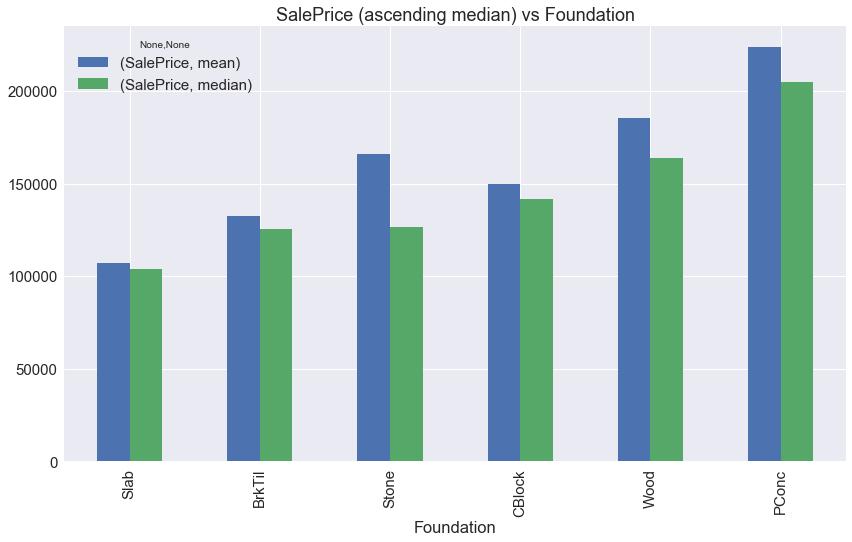

In [283]:
t = train_data.loc[:, ["Foundation", "SalePrice"]].groupby("Foundation").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs Foundation", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs Foundation", fontsize=15, figsize=(14, 8))

`'Foundation'` should not be removed.

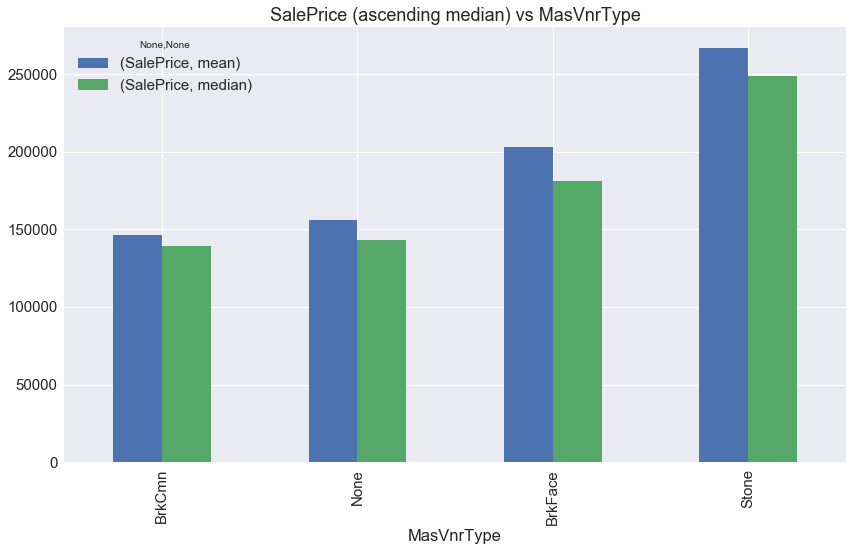

In [284]:
t = train_data.loc[:, ["MasVnrType", "SalePrice"]].groupby("MasVnrType").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs MasVnrType", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs MasVnrType", fontsize=15, figsize=(14, 8))

`'MasVnrType'` should not be removed.

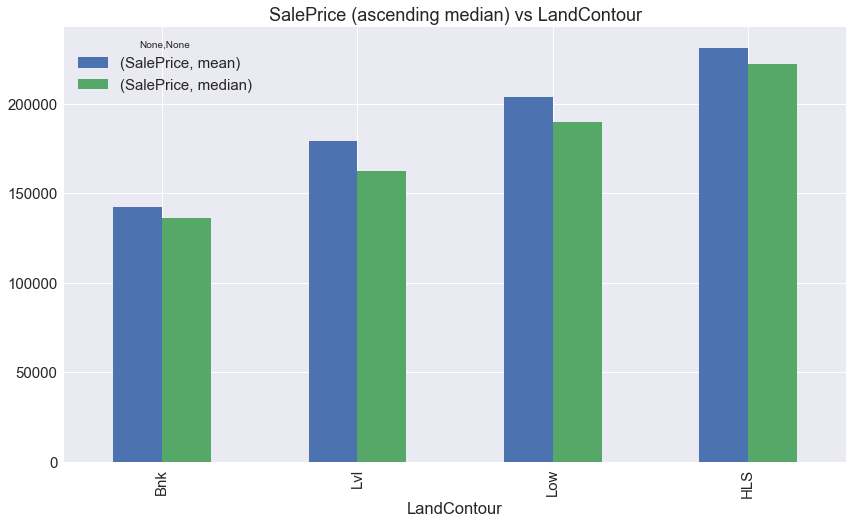

In [285]:
t = train_data.loc[:, ["LandContour", "SalePrice"]].groupby("LandContour").agg(["mean", "median", "count"]).sort_values([("SalePrice", "median")])
t.loc[:, [("SalePrice", "mean"), ("SalePrice", "median")]].plot(kind="bar", title="SalePrice (ascending median) vs LandContour", fontsize=15, figsize=(14, 8))
# t.loc[:, [("SalePrice", "count")]].plot(kind="bar", title="SalePrice (count) vs LandContour", fontsize=15, figsize=(14, 8))

`'LandContour'` should not be removed.

In [286]:
candidate_feature_removal.extend([ 'YearRemodAdd', 'LandSlope' ])

In [287]:
reduced_feature_set.extend([ 'PavedDrive', 'Street', 'Alley', 'Fence', 'OverallCond', 'YearBuilt', 'Foundation', 'Functional', 'MasVnrArea', 'MasVnrType', 'LandContour' ])
print("Reduced feature set: {}".format(reduced_feature_set))

Reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'LotShape', 'LotFrontage', 'LotArea', 'LotConfig', 'PavedDrive', 'Street', 'Alley', 'Fence', 'OverallCond', 'YearBuilt', 'Foundation', 'Functional', 'MasVnrArea', 'MasVnrType', 'LandContour']


**We have reached the end of our first phase of feature reduction.**

In [288]:
print("{} out of {} features selected for removal: {}".format(len(candidate_feature_removal), test_data.shape[1], candidate_feature_removal))
print("-" * 100)
print("Remaining {} out of {} features selected for the reduced feature set: {}".format(len(reduced_feature_set), test_data.shape[1], reduced_feature_set))

21 out of 79 features selected for removal: ['MiscValue', 'YrSold', '2ndFlrSF', 'LowQualFinSF', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType2', 'BsmtUnfSF', 'BedroomAbvGr', 'BsmtHalfBath', 'Utilities', 'Fireplaces', 'PoolQC', 'MiscFeature', 'GarageYrBlt', 'GarageArea', 'GarageCond', '3SsnPorch', 'YearRemodAdd', 'LandSlope']
----------------------------------------------------------------------------------------------------
Remaining 58 out of 79 features selected for the reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'Scre

### Feature Reduction (II)

Note that in the previous section we reduced features in batches with the help of correlation matrix, scatter matrix and barplots. In this section we will run correlation with the `'reduced_feature_set'` as a whole to find correlation between the larger set.

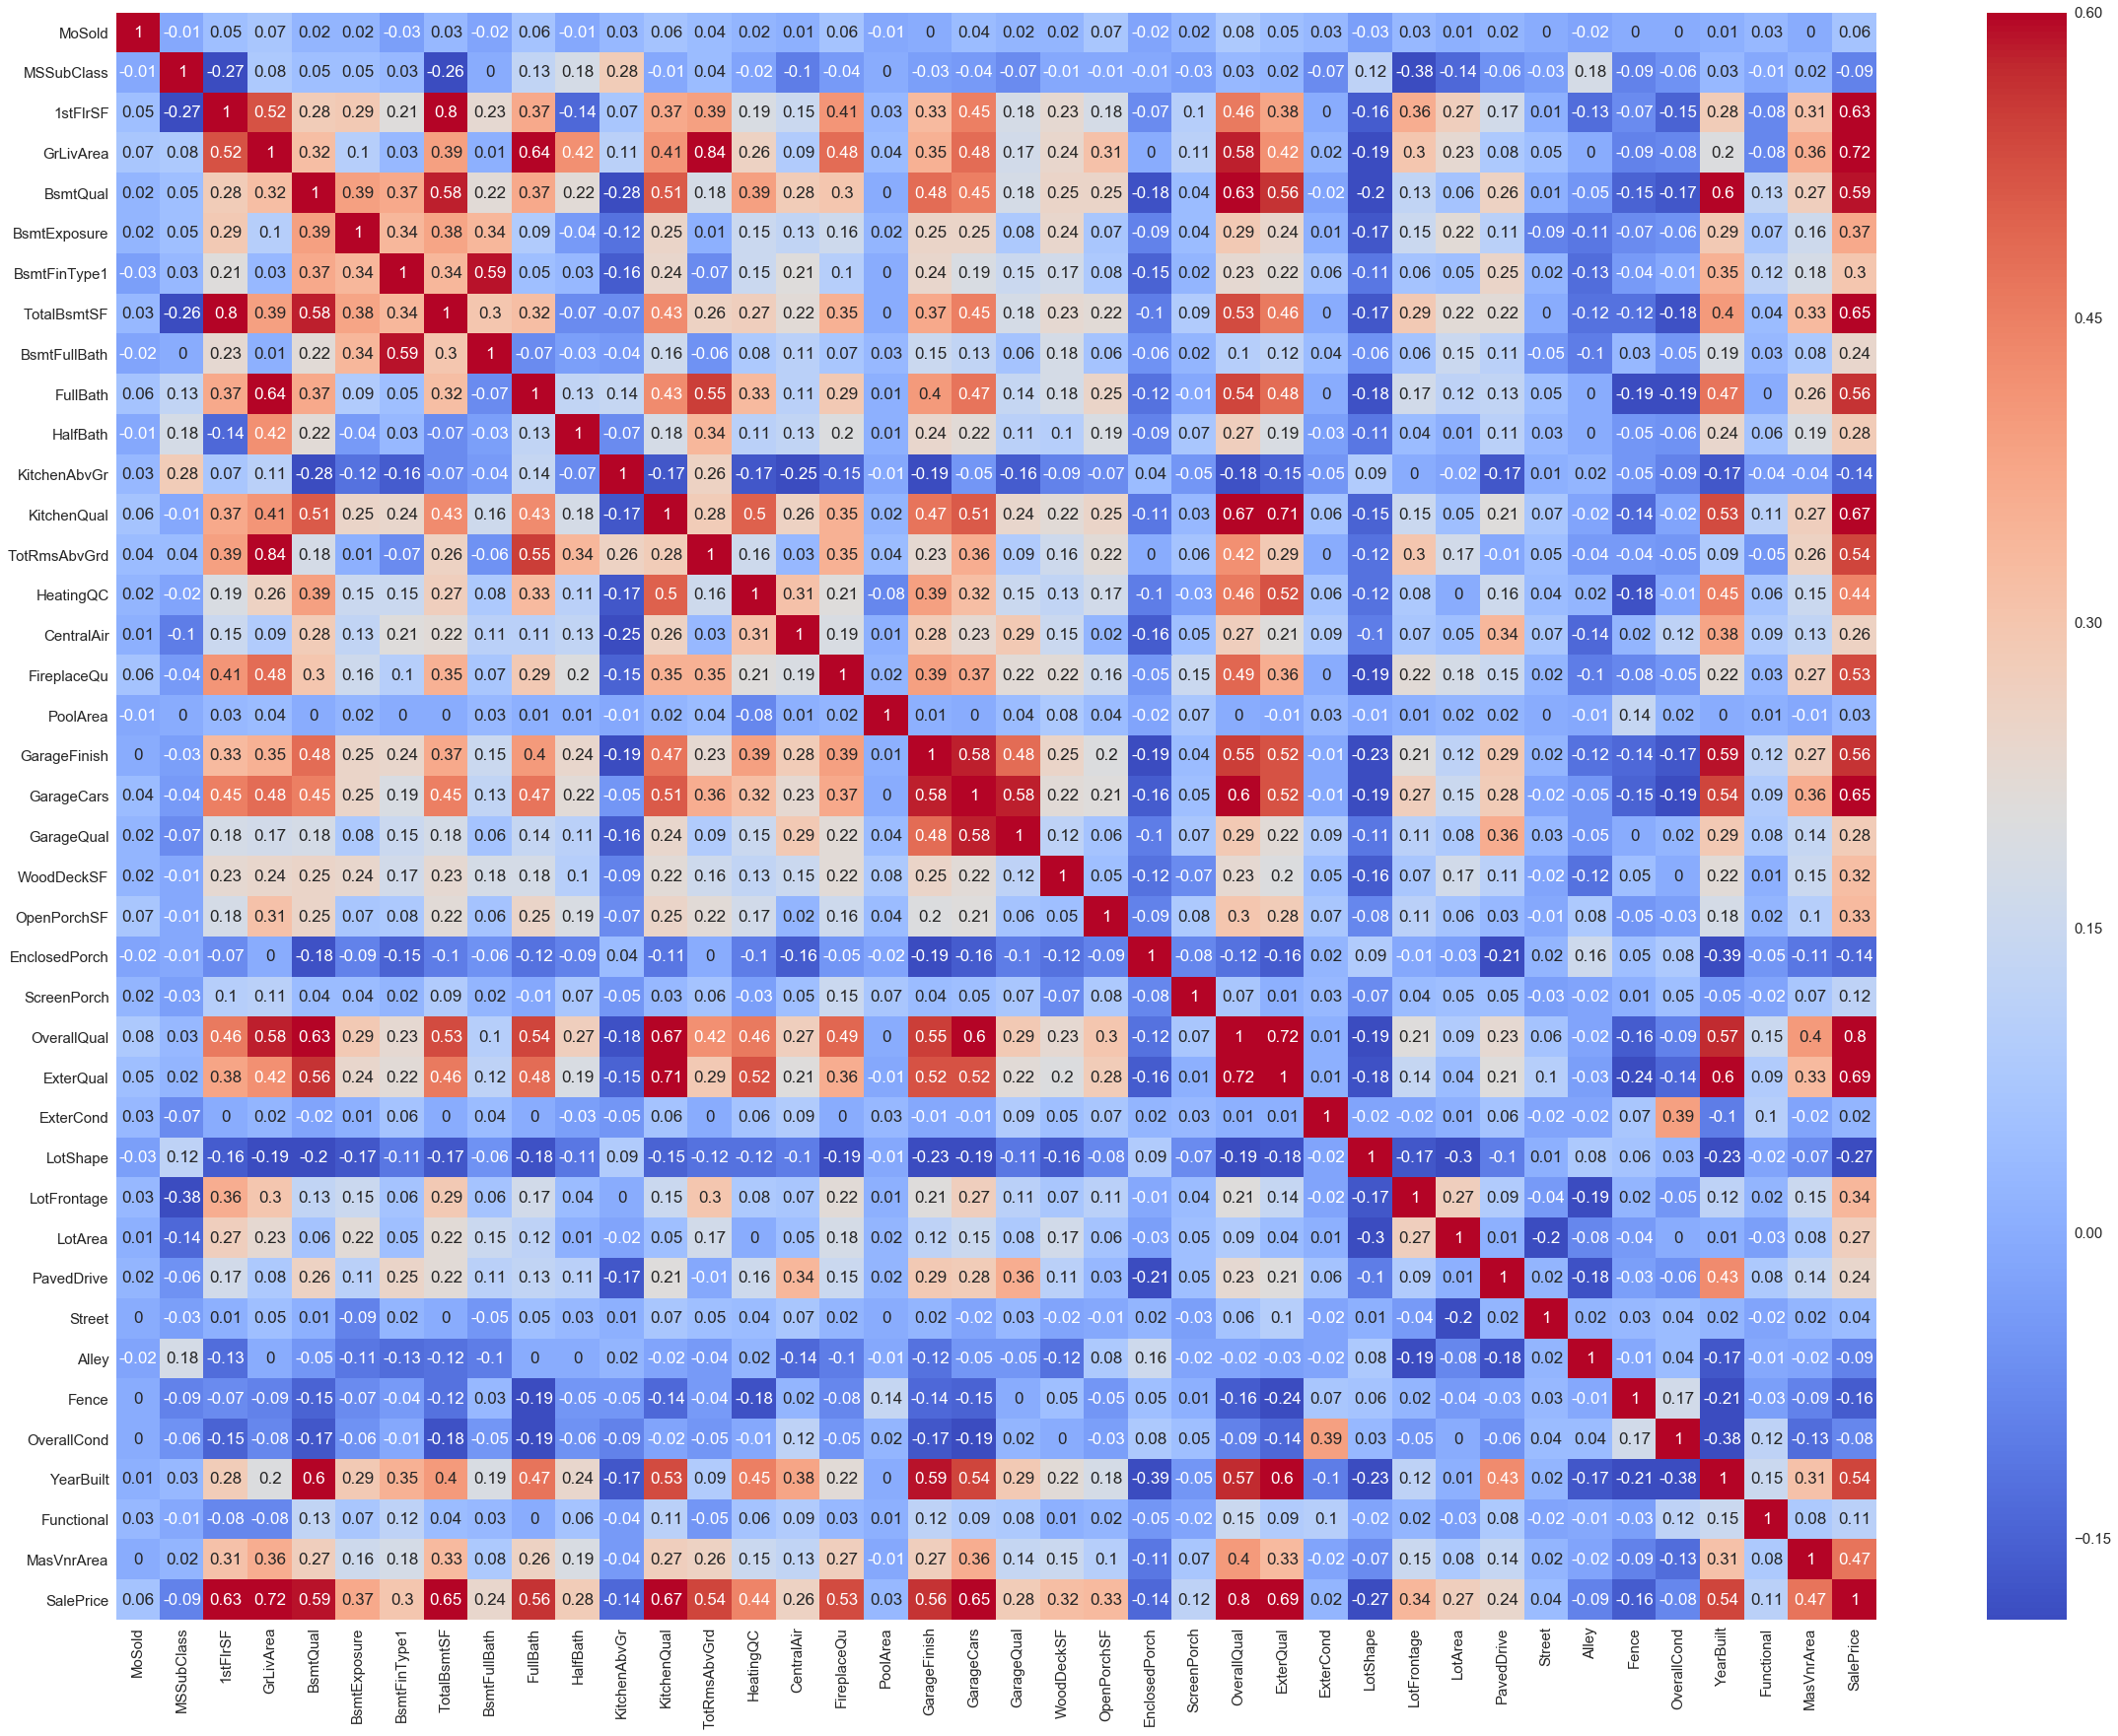

In [289]:
# Append the target variable to get the correlation with the same.
if "SalePrice" not in reduced_feature_set:
    reduced_feature_set.append("SalePrice")
correlation = train_data[reduced_feature_set].corr()
plt.subplots(figsize=(40, 30))
sns.heatmap(correlation.round(2), annot=True, annot_kws={"size": 17}, cmap="coolwarm", robust=True, vmax=0.6)

**Let's arrange the correlation with the target variable** `'SalePrice'` **in descending order.**

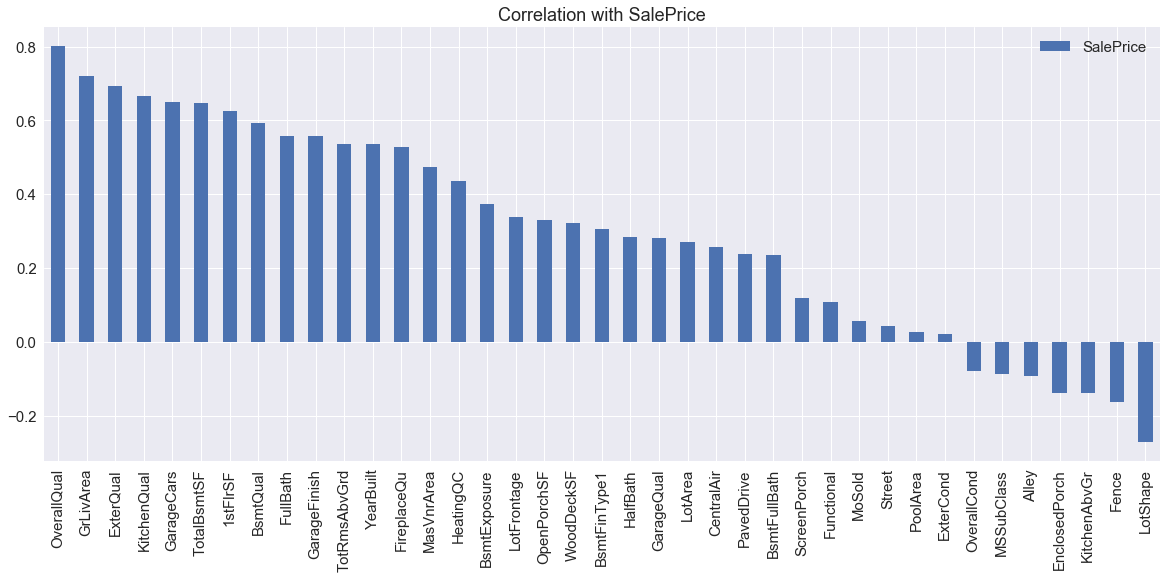

In [290]:
correlation_with_sale_price = correlation.round(4).SalePrice.sort_values(ascending=False).to_frame().drop("SalePrice", axis=0)
correlation_with_sale_price.plot(kind='bar', title="Correlation with SalePrice", fontsize=15, figsize=(20, 8))

**Let's get all the unique pairs of features with correlation greater than 0.5 not including the target variable. We should also include correlation with the target variable such that their difference can identify relative importance between them. This can then be used to remove a feature**
> Note: We should remove a feature in a pair if it's correlation with the target variable is much less than that of the other feature.
>> (A, B) > 0.5; (A, Target) = x; (B, Target) = y; Remove A if x is much less than y and vice versa.

In [291]:
correlation_greater_than_half = []
# Iterate over correlation dataframe and construct a dictionary with relevant details
for feature, row in correlation.round(4).iterrows():
    for col in correlation.columns:
        # Exclude target variable since it's already calculated above.
        if feature != "SalePrice" and col != "SalePrice":
            if feature == col:
                # Avoid duplicates.
                break
            if row[col] > 0.5:
                # Only get correlation pairs with correlation greater than half.
                correlation_feature_one_target = correlation_with_sale_price.loc[feature].values[0]
                correlation_feature_two_target = correlation_with_sale_price.loc[col].values[0]
                matrix_data = {
                    "feature_one" : feature,
                    "feature_two" : col,
                    "correlation_feature_pair" : row[col],
                    "correlation_feature_one_target" : correlation_feature_one_target,
                    "correlation_feature_two_target" : correlation_feature_two_target,
                    "difference_in_correlation_target" : np.abs(correlation_feature_one_target - correlation_feature_two_target)
                }
                correlation_greater_than_half.append(matrix_data)

In [292]:
correlation_greater_than_half_df = pd.DataFrame.from_dict(correlation_greater_than_half)
display(correlation_greater_than_half_df)

correlation_feature_one_target  correlation_feature_pair  \
0                           0.7216                    0.5236   
1                           0.6465                    0.8007   
2                           0.6465                    0.5759   
3                           0.2353                    0.5887   
4                           0.5589                    0.6358   
5                           0.6661                    0.5063   
6                           0.5373                    0.8352   
7                           0.5373                    0.5494   
8                           0.4352                    0.5029   
9                           0.6492                    0.5066   
10                          0.6492                    0.5781   
11                          0.2813                    0.5773   
12                          0.8008                    0.5829   
13                          0.8008                    0.6264   
14                          0.8008                    0.5324   
15                          0.8008                    0.5435   
16                          0.8008                    0.6677   
17                          0.8008                    0.5546   
18                          0.8008                    0.5989   
19                          0.6945                    0.5621   
20                          0.6945                    0.7124   
21                          0.6945                    0.5195   
22                          0.6945                    0.5164   
23                          0.6945                    0.5242   
24                          0.6945                    0.7217   
25                          0.5368                    0.6014   
26                          0.5368                    0.5300   
27                          0.5368                    0.5942   
28                          0.5368                    0.5377   
29                          0.5368                    0.5744   
30                          0.5368                    0.5996   

    correlation_feature_two_target  difference_in_correlation_target  \
0                           0.6251                            0.0965   
1                           0.6251                            0.0214   
2                           0.5925                            0.0540   
3                           0.3047                            0.0694   
4                           0.7216                            0.1627   
5                           0.5925                            0.0736   
6                           0.7216                            0.1843   
7                           0.5589                            0.0216   
8                           0.6661                            0.2309   
9                           0.6661                            0.0169   
10                          0.5574                            0.0918   
11                          0.6492                            0.3679   
12                          0.7216                            0.0792   
13                          0.5925                            0.2083   
14                          0.6465                            0.1543   
15                          0.5589                            0.2419   
16                          0.6661                            0.1347   
17                          0.5574                            0.2434   
18                          0.6492                            0.1516   
19                          0.5925                            0.1020   
20                          0.6661                            0.0284   
21                          0.4352                            0.2593   
22                          0.5574                            0.1371   
23                          0.6492                            0.0453   
24                          0.8008                            0.1063   
25                          0.5925                            0.0557   
26         

In [293]:
# Filter correlation pair which have difference in correlation with target variable greater than 0.2
display(correlation_greater_than_half_df.loc[correlation_greater_than_half_df["difference_in_correlation_target"] > 0.2])

correlation_feature_one_target  correlation_feature_pair  \
8                           0.4352                    0.5029   
11                          0.2813                    0.5773   
13                          0.8008                    0.6264   
15                          0.8008                    0.5435   
17                          0.8008                    0.5546   
21                          0.6945                    0.5195   
29                          0.5368                    0.5744   

    correlation_feature_two_target  difference_in_correlation_target  \
8                           0.6661                            0.2309   
11                          0.6492                            0.3679   
13                          0.5925                            0.2083   
15                          0.5589                            0.2419   
17                          0.5574                            0.2434   
21                          0.4352                            0.2593   
29                          0.8008                            0.2640   

    feature_one   feature_two  
8     HeatingQC   KitchenQual  
11   GarageQual    GarageCars  
13  OverallQual      BsmtQual  
15  OverallQual      FullBath  
17  OverallQual  GarageFinish  
21    ExterQual     HeatingQC  
29    YearBuilt   OverallQual

Using the above table we can further reduce the feature set by removing `'HeatingQC'`, `'GarageQual'`, `'BsmtQual'`, `'FullBath'`, `'GarageFinish'` and `'YearBuilt'`.

In [294]:
candidate_feature_removal = ['HeatingQC', 'GarageQual', 'BsmtQual', 'FullBath', 'GarageFinish', 'YearBuilt' ]
reduced_feature_set = [x for x in reduced_feature_set if x not in candidate_feature_removal]

**Save the reduced training and testing set to the disk.**

In [295]:
# Save the updated training set to file
filename = "chkp03_train.csv"
is_present = glob.glob(filename)
if not is_present:
    train_data[reduced_feature_set].to_csv(filename, index=True)
    print("Reduced training set written to file: {}".format(filename))
else:
    print("File: {} already present. Make sure to delete the same when running the whole notebook.".format(filename))

# Save the updated testing set to file
filename = "chkp03_test.csv"
is_present = glob.glob(filename)
if not is_present:
    test_data.to_csv(filename, index=True)
    print("Testing set written to file: {}".format(filename))
else:
    print("File: {} already present. Make sure to delete the same when running the whole notebook.".format(filename))

Reduced training set written to file: chkp03_train.csv
Testing set written to file: chkp03_test.csv


**This brings us to the end of our second phase of feature reduction.**

In [296]:
# Remove the target variable from reduced feature set since it was added for correlation heatmap.
try:
    reduced_feature_set.remove("SalePrice")
    print("Target variable SalePrice removed from the reduced_feature_set.")
except ValueError as e:
    print("SalePrice already removed from the reduced_feature_set: {}".format(e))

Target variable SalePrice removed from the reduced_feature_set.


In [297]:
print("{} out of {} features selected for removal: {}".format(len(candidate_feature_removal), test_data.shape[1], candidate_feature_removal))
print("-" * 100)
print("Remaining {} out of {} features selected for the reduced feature set: {}".format(len(reduced_feature_set), test_data.shape[1], reduced_feature_set))

6 out of 79 features selected for removal: ['HeatingQC', 'GarageQual', 'BsmtQual', 'FullBath', 'GarageFinish', 'YearBuilt']
----------------------------------------------------------------------------------------------------
Remaining 52 out of 79 features selected for the reduced feature set: ['MoSold', 'SaleType', 'SaleCondition', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 'MSZoning', 'HouseStyle', 'BldgType', '1stFlrSF', 'GrLivArea', 'BsmtExposure', 'BsmtFinType1', 'TotalBsmtSF', 'BsmtFullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Heating', 'CentralAir', 'Electrical', 'FireplaceQu', 'PoolArea', 'GarageType', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'LotShape', 'LotFrontage', 'LotArea', 'LotConfig', 'PavedDrive', 'Street', 'Alley', 'Fence', 'OverallCond', 'Foundation', 'Functional', 'MasVnrArea', 'MasVnrType', 'LandCo

### Checkpoint 3

This checkpoint serves the updated training and testing set with reduced feature set.

### Benchmark Model

In this section we'll evaluate a model learned by a linear regression on `'YrSold'`, `'MoSold'`, `'LotArea'` and `'BedroomAbvGr'` using Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price as specified [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques#evaluation).

**Load the training set with only the required features while explicitly specifying the data type for each feature.**

In [298]:
column_types = { 'Id' : np.int64, 'YrSold' : np.int64, 'MoSold' : np.int64, 'LotArea' : np.float64, 'BedroomAbvGr' : np.int64, 'SalePrice' : np.float64 }
# Read the training set with only the relevant features required by the benchmark model.
try:
    train_data = pd.read_csv("chkp02_train.csv", dtype=column_types, usecols=column_types.keys())
    train_data.set_index('Id', inplace=True)
    print("Training set has {} samples with {} features each.".format(*train_data.shape))
except Exception as e:
    print("Dataset could not be loaded. Error: {}".format(e))
    print("Please make sure the training and the testing set is present.")

Training set has 1455 samples with 5 features each.


**Let's glance at the training data to make sure the data is read properly.**

In [299]:
display(train_data.head())

LotArea  BedroomAbvGr  MoSold  YrSold  SalePrice
Id                                                  
1    8450.0             3       2    2008   208500.0
2    9600.0             3       5    2007   181500.0
3   11250.0             3       9    2008   223500.0
4    9550.0             3       2    2006   140000.0
5   14260.0             4      12    2008   250000.0

**Let's separate our target variable from the training set.**

In [300]:
saleprice = train_data.SalePrice
train_data.drop("SalePrice", axis=1, inplace=True)

**Missing values in the dataset.**

In [301]:
print("There are {} missing values in the training set.".format(train_data.isnull().sum().sum()))

There are 0 missing values in the training set.


**Log transformation for training features.**

In [302]:
# Calculate skewness for numerical features and sort them in descending order.
skewness = train_data.apply(lambda x: np.abs(skew(x))).to_frame(name="skewness_value").sort_values(by="skewness_value", ascending=False)
display(skewness)

skewness_value
LotArea            12.600941
MoSold              0.216672
BedroomAbvGr        0.216216
YrSold              0.092204

In [303]:
# Filter out skewed features which have skewness value greater than 0.75
skewed_features = skewness.loc[skewness.skewness_value > 0.75].index
print("{} feature(s) selected for log transformation: {}".format(len(skewed_features), skewed_features.tolist()))

1 feature(s) selected for log transformation: ['LotArea']


**Apply log transformation for training features.**

In [304]:
train_data[skewed_features] = train_data[skewed_features].apply(lambda x: np.log1p(x))

**Verify log transformation for training features.**

In [305]:
display(train_data.loc[:, skewed_features].sample(5))

LotArea
Id            
1206  9.594582
308   8.977273
35    8.897546
924   8.988821
429   8.819222

**Log transformation for target variable.**

In [306]:
print("Feature: SalePrice, Skewness: {}".format(saleprice.skew()))

Feature: SalePrice, Skewness: 1.56747337288


**Apply log transformation for target variable.**

In [307]:
saleprice = saleprice.apply(lambda x: np.log1p(x))

**Verify log transformation for target variable.**

In [308]:
saleprice.sample(5)

Id
545     12.098855
641     12.520887
1403    12.174995
1211    12.149508
466     12.093693
Name: SalePrice, dtype: float64

**One Hot Encoding for Categorical (Nominal) features.**

Not applicable since there are no such features in the current training set.

**Let's split the training set into training and validation set.**

In [309]:
# 80 percent to training set and 20 percent to validation set.
X_train, X_test, y_train, y_test = train_test_split(train_data, saleprice, test_size = 0.2, random_state = 1729)
print("Training set has {} samples with {} features.".format(*X_train.shape))
print("Validation set has {} samples with {} features.".format(*X_test.shape))

Training set has 1164 samples with 4 features.
Validation set has 291 samples with 4 features.


**Let's build the Linear Regression model and evaluate it using RMSLE.**

In [310]:
start = time()
regressional_model = LinearRegression().fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = regressional_model.predict(X_test)
pred_time = time() - start

In [311]:
# Model metrics will be used to compare models.
model_metrics = []
# Calculate the cross validation score for the current regression model over training set.
cv_scores = np.sqrt(-cross_val_score(regressional_model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
# Calculate the RMSLE for the current regression model over validation set.
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("Benchmark Model: RMSLE on Training set: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std()))
print("Benchmark Model: RMSLE on Validation set: {:.4f}".format(score))
model_metrics.append({ "model" : "Benchmark", "rmsle_training" : cv_scores.mean(), "rmsle_validation" : score,
                                        "training_time": train_time, "predicting_time": pred_time })

Benchmark Model: RMSLE on Training set: 0.3728 (+/- 0.0172)
Benchmark Model: RMSLE on Validation set: 0.3126


### Base Models

In this section we will evaluate the below regression models learned on the reduced feature set using the same metric as above.
- LinearRegression
- GradientBoostingRegressor
- LightGBM

**Load the dataset with explicitly specifying the data types for each feature.**

In [312]:
column_types = {
    'MSSubClass' : np.int64, 'MSZoning' : np.object, 'LotFrontage' : np.float64, 'LotArea' : np.float64, 'Street' : np.int64,
    'Alley' : np.int64, 'LotShape' : np.int64, 'LandContour' : np.object, 'Utilities' : np.int64, 'LotConfig' : np.object,
    'LandSlope' : np.int64, 'Neighborhood' : np.object, 'Condition1' : np.object, 'Condition2' : np.object, 'BldgType' : np.object,
    'HouseStyle' : np.object, 'OverallQual' : np.int64, 'OverallCond' : np.int64, 'YearBuilt' : np.int64, 'YearRemodAdd' : np.int64,
    'RoofStyle' : np.object, 'RoofMatl' : np.object, 'Exterior1st' : np.object, 'Exterior2nd' : np.object, 'MasVnrType' : np.object,
    'MasVnrArea' : np.float64, 'ExterQual' : np.int64, 'ExterCond' : np.int64, 'Foundation' : np.object, 'BsmtQual' : np.int64,
    'BsmtCond' : np.int64, 'BsmtExposure' : np.int64, 'BsmtFinType1' : np.int64, 'BsmtFinSF1' : np.float64, 'BsmtFinType2' : np.int64,
    'BsmtFinSF2' : np.float64, 'BsmtUnfSF' : np.float64, 'TotalBsmtSF' : np.float64, 'Heating' : np.object, 'HeatingQC' : np.int64,
    'CentralAir' : np.int64, 'Electrical' : np.object, '1stFlrSF' : np.float64, '2ndFlrSF' : np.float64, 'LowQualFinSF' : np.float64,
    'GrLivArea' : np.float64, 'BsmtFullBath' : np.int64, 'BsmtHalfBath' : np.int64, 'FullBath' : np.int64, 'HalfBath' : np.int64,
    'BedroomAbvGr' : np.int64, 'KitchenAbvGr' : np.int64, 'KitchenQual' : np.int64, 'TotRmsAbvGrd' : np.int64, 'Functional' : np.int64,
    'Fireplaces' : np.int64, 'FireplaceQu' : np.int64, 'GarageType' : np.object, 'GarageYrBlt' : np.object, 'GarageFinish' : np.int64,
    'GarageCars' : np.int64, 'GarageArea' : np.float64, 'GarageQual' : np.int64, 'GarageCond' : np.int64, 'PavedDrive' : np.int64,
    'WoodDeckSF' : np.float64, 'OpenPorchSF' : np.float64, 'EnclosedPorch' : np.float64, '3SsnPorch' : np.float64, 'ScreenPorch' : np.float64,
    'PoolArea' : np.float64, 'PoolQC' : np.int64, 'Fence' : np.int64, 'MiscFeature' : np.object, 'MiscVal' : np.float64,
    'MoSold' : np.int64, 'YrSold' : np.int64, 'SaleType' : np.object, 'SaleCondition' : np.object, 'SalePrice' : np.float64
}

# Read the training and testing set to pandas dataframes.
try:
    train_data = pd.read_csv("chkp03_train.csv", dtype=column_types)
    test_data = pd.read_csv("chkp03_test.csv", dtype=column_types)
    train_data.set_index('Id', inplace=True)
    test_data.set_index('Id', inplace=True)
    print("Training set has {} samples with {} features each.".format(*train_data.shape))
    print("Testing set has {} samples with {} features each.".format(*test_data.shape))
except Exception as e:
    print("Dataset could not be loaded. Error: {}".format(e))
    print("Please make sure the training and the testing set is present.")

Training set has 1455 samples with 53 features each.
Testing set has 1459 samples with 79 features each.


**Let's separate our target variable from the training set.**

In [313]:
saleprice = train_data.SalePrice
train_data.drop("SalePrice", axis=1, inplace=True)

Since our training and testing set has unequal number of features because of reduction in feature set from the above sections, **we need to get the same subset in the testing set.**

In [314]:
reduced_feature_set = train_data.columns
test_data = test_data.loc[:, reduced_feature_set]
print("Training set has {} samples with {} features each.".format(*train_data.shape))
print("Testing set has {} samples with {} features each.".format(*test_data.shape))

Training set has 1455 samples with 52 features each.
Testing set has 1459 samples with 52 features each.


**Let's have a glance at our training and testing set.**

In [315]:
display(train_data.head())
display(test_data.head())

MoSold SaleType SaleCondition Neighborhood Condition1 Condition2  \
Id                                                                     
1        2       WD        Normal      CollgCr       Norm       Norm   
2        5       WD        Normal      Veenker      Feedr       Norm   
3        9       WD        Normal      CollgCr       Norm       Norm   
4        2       WD       Abnorml      Crawfor       Norm       Norm   
5       12       WD        Normal      NoRidge       Norm       Norm   

    MSSubClass MSZoning HouseStyle BldgType     ...       PavedDrive  Street  \
Id                                              ...                            
1           60       RL     2Story     1Fam     ...                2       2   
2           20       RL     1Story     1Fam     ...                2       2   
3           60       RL     2Story     1Fam     ...                2       2   
4           70       RL     2Story     1Fam     ...                2       2   
5           60       RL     2Story     1Fam     ...                2       2   

    Alley  Fence  OverallCond  Foundation  Functional  MasVnrArea  MasVnrType  \
Id                                                                              
1       0      0            5       PConc           8       196.0     BrkFace   
2       0      0            8      CBlock           8         0.0        None   
3       0      0            5       PConc           8       162.0     BrkFace   
4       0      0            5      BrkTil           8         0.0        None   
5       0      0            5       PConc           8       350.0     BrkFace   

    LandContour  
Id               
1           Lvl  
2           Lvl  
3           Lvl  
4           Lvl  
5           Lvl  

[5 rows x 52 columns]

MoSold SaleType SaleCondition Neighborhood Condition1 Condition2  \
Id                                                                       
1461       6       WD        Normal        NAmes      Feedr       Norm   
1462       6       WD        Normal        NAmes       Norm       Norm   
1463       3       WD        Normal      Gilbert       Norm       Norm   
1464       6       WD        Normal      Gilbert       Norm       Norm   
1465       1       WD        Normal      StoneBr       Norm       Norm   

      MSSubClass MSZoning HouseStyle BldgType     ...       PavedDrive  \
Id                                                ...                    
1461          20       RH     1Story     1Fam     ...                2   
1462          20       RL     1Story     1Fam     ...                2   
1463          60       RL     2Story     1Fam     ...                2   
1464          60       RL     2Story     1Fam     ...                2   
1465         120       RL     1Story   TwnhsE     ...                2   

      Street  Alley  Fence  OverallCond  Foundation  Functional  MasVnrArea  \
Id                                                                            
1461       2      0      3            6      CBlock           8         0.0   
1462       2      0      0            6      CBlock           8       108.0   
1463       2      0      3            5       PConc           8         0.0   
1464       2      0      0            6       PConc           8        20.0   
1465       2      0      0            5       PConc           8         0.0   

      MasVnrType  LandContour  
Id                             
1461        None          Lvl  
1462     BrkFace          Lvl  
1463        None          Lvl  
1464     BrkFace          Lvl  
1465        None          HLS  

[5 rows x 52 columns]

**Missing values in the updated dataset.**

In [316]:
print("There are {} missing values in the training set.".format(train_data.isnull().sum().sum()))
print("There are {} missing values in the testing set.".format(test_data.isnull().sum().sum()))

There are 0 missing values in the training set.
There are 0 missing values in the testing set.


**Log transformation for training features.**

In [317]:
# Get the numerical feature in the reduced feature set.
numerical_features = train_data.select_dtypes(include=np.number).columns
# Calculate skewness for numerical features and sort them in descending order.
skewness = train_data.loc[:, numerical_features].apply(lambda x: np.abs(skew(x))).to_frame(name="skewness_value").sort_values(by="skewness_value", ascending=False)
display(skewness)

skewness_value
PoolArea            19.489988
Street              15.475921
LotArea             12.600941
Functional           4.897781
KitchenAbvGr         4.474988
Alley                4.276470
ScreenPorch          4.109754
CentralAir           3.519324
PavedDrive           3.298402
EnclosedPorch        2.869829
MasVnrArea           2.653697
OpenPorchSF          2.336262
Fence                1.811913
LotFrontage          1.649612
WoodDeckSF           1.548782
MSSubClass           1.405527
ExterCond            1.394736
LotShape             1.288821
BsmtExposure         1.110280
1stFlrSF             0.867178
GrLivArea            0.826353
ExterQual            0.820158
OverallCond          0.690141
HalfBath             0.682425
TotRmsAbvGrd         0.662458
BsmtFullBath         0.592443
TotalBsmtSF          0.487267
KitchenQual          0.382381
GarageCars           0.342410
MoSold               0.216672
OverallQual          0.184995
BsmtFinType1         0.153282
FireplaceQu          0.117080

In [318]:
# Filter out skewed features which have skewness value greater than 0.75
skewed_features = skewness.loc[skewness.skewness_value > 0.75].index
print("{} feature(s) selected for log transformation: {}".format(len(skewed_features), skewed_features.tolist()))

22 feature(s) selected for log transformation: ['PoolArea', 'Street', 'LotArea', 'Functional', 'KitchenAbvGr', 'Alley', 'ScreenPorch', 'CentralAir', 'PavedDrive', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'Fence', 'LotFrontage', 'WoodDeckSF', 'MSSubClass', 'ExterCond', 'LotShape', 'BsmtExposure', '1stFlrSF', 'GrLivArea', 'ExterQual']


**Apply log transformation for training features.**

In [319]:
train_data[skewed_features] = train_data[skewed_features].apply(lambda x: np.log1p(x))

**Verify log transformation for training features.**

In [320]:
display(train_data.loc[:, skewed_features].sample(5))

PoolArea    Street   LotArea  Functional  KitchenAbvGr  Alley  \
Id                                                                    
1213       0.0  1.098612  9.142169    2.197225      0.693147    0.0   
1020       0.0  1.098612  8.011023    2.197225      0.693147    0.0   
513        0.0  1.098612  9.116140    2.197225      0.693147    0.0   
520        0.0  1.098612  9.298260    2.197225      0.693147    0.0   
1386       0.0  1.098612  8.600983    2.197225      0.693147    0.0   

      ScreenPorch  CentralAir  PavedDrive  EnclosedPorch    ...         Fence  \
Id                                                          ...                 
1213     0.000000    0.693147    0.000000            0.0    ...      0.000000   
1020     0.000000    0.693147    1.098612            0.0    ...      0.000000   
513      0.000000    0.693147    1.098612            0.0    ...      0.000000   
520      4.983607    0.693147    1.098612            0.0    ...      1.386294   
1386     0.000000    0.693147    0.000000            0.0    ...      1.386294   

      LotFrontage  WoodDeckSF  MSSubClass  ExterCond  LotShape  BsmtExposure  \
Id                                                                             
1213     3.931826    0.000000    3.433987   1.386294  1.609438      0.693147   
1020     3.784190    4.962845    4.795791   1.386294  1.609438      1.609438   
513      4.262680    0.000000    3.044522   1.386294  1.609438      0.693147   
520      3.988984    0.000000    4.262680   1.386294  1.609438      0.693147   
1386     3.713572    0.000000    3.931826   1.609438  1.609438      0.693147   

      1stFlrSF  GrLivArea  ExterQual  
Id                                    
1213  6.511745   6.511745   1.386294  
1020  7.317876   7.317876   1.609438  
513   6.762730   6.762730   1.386294  
520   7.152269   7.640604   1.609438  
1386  6.680855   7.051856   1.386294  

[5 rows x 22 columns]

**Log transformation for target variable.**

In [321]:
print("Feature: SalePrice, Skewness: {}".format(saleprice.skew()))

Feature: SalePrice, Skewness: 1.56747337288


**Apply log transformation for target variable.**

In [322]:
saleprice = saleprice.apply(lambda x: np.log1p(x))

**Verify log transformation for target variable.**

In [323]:
saleprice.sample(5)

Id
78      11.751950
886     12.703512
822     11.440366
669     12.031725
1196    12.078245
Name: SalePrice, dtype: float64

**One Hot Encoding for Categorical (Nominal) features.**
> Note: Values for a feature can differ in the training and testing set. Therefore one hot encoding may give unequal number of features when run individually on training and testing set. To avoid this combine the training and testing set and then run pd.get_dummies() on the combined dataset. After that reconstruct the training and testing set.

In [324]:
print("Before One Hot Encoding - Training set has {} samples with {} features each.".format(*train_data.shape))
print("Before One Hot Encoding - Testing set has {} samples with {} features each.".format(*test_data.shape))
print("-" * 100)
# Need the number of rows in training set to split the combined dataset properly.
n_rows = train_data.shape[0]
combined_data = combined_data = pd.concat([train_data, test_data])
print("[IN_PROCESS] Before One Hot Encoding - Combined set has {} samples with {} features each.".format(*combined_data.shape))
combined_data = pd.get_dummies(combined_data)
print("[IN_PROCESS] After One Hot Encoding - Combined set has {} samples with {} features each.".format(*combined_data.shape))
train_data = combined_data[:n_rows]
test_data = combined_data[n_rows:]
print("-" * 100)
print("After One Hot Encoding - Training set has {} samples with {} features each.".format(*train_data.shape))
print("After One Hot Encoding - Testing set has {} samples with {} features each.".format(*test_data.shape))

Before One Hot Encoding - Training set has 1455 samples with 52 features each.
Before One Hot Encoding - Testing set has 1459 samples with 52 features each.
----------------------------------------------------------------------------------------------------
[IN_PROCESS] Before One Hot Encoding - Combined set has 2914 samples with 52 features each.
[IN_PROCESS] After One Hot Encoding - Combined set has 2914 samples with 190 features each.
----------------------------------------------------------------------------------------------------
After One Hot Encoding - Training set has 1455 samples with 190 features each.
After One Hot Encoding - Testing set has 1459 samples with 190 features each.


**Let's split the training set into training and testing set.**

In [325]:
# 80 percent to training set and 20 percent to validation set.
X_train, X_test, y_train, y_test = train_test_split(train_data, saleprice, test_size = 0.2, random_state = 1729)
print("Training set has {} samples with {} features.".format(*X_train.shape))
print("Validation set has {} samples with {} features.".format(*X_test.shape))

Training set has 1164 samples with 190 features.
Validation set has 291 samples with 190 features.


Now that we have our dataset ready for regression models, let's build the same.

**LinearRegression**

In [326]:
start = time()
regressional_model = LinearRegression().fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = regressional_model.predict(X_test)
pred_time = time() - start

In [327]:
cv_scores = np.sqrt(-cross_val_score(regressional_model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("LinearRegression Model: RMSLE on Training set: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std()))
print("LinearRegression Model: RMSLE on Validation set: {:.4f}".format(score))
model_metrics.append({ "model" : "LinearRegression", "rmsle_training" : cv_scores.mean(), "rmsle_validation" : score,
                                        "training_time": train_time, "predicting_time": pred_time })

LinearRegression Model: RMSLE on Training set: 0.1271 (+/- 0.0183)
LinearRegression Model: RMSLE on Validation set: 0.1093


**GradientBoostingRegressor**

In [328]:
start = time()
regressional_model = GradientBoostingRegressor(random_state=1729).fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = regressional_model.predict(X_test)
pred_time = time() - start

In [329]:
# Calculate the cross validation score for the current regression model over training set.
cv_scores = np.sqrt(-cross_val_score(regressional_model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
# Calculate the RMSLE for the current regression model over validation set.
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("GradientBoostingRegressor Model: RMSLE on Training set: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std()))
print("GradientBoostingRegressor Model: RMSLE on Validation set: {:.4f}".format(score))
model_metrics.append({ "model" : "GradientBoostingRegressor", "rmsle_training" : cv_scores.mean(), "rmsle_validation" : score,
                                        "training_time": train_time, "predicting_time": pred_time })

GradientBoostingRegressor Model: RMSLE on Training set: 0.1276 (+/- 0.0137)
GradientBoostingRegressor Model: RMSLE on Validation set: 0.1056


**LightGBM**

In [330]:
regressional_model = lgb.LGBMRegressor(objective='regression', random_state=1729, silent=True)
start = time()
regressional_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
train_time = time() - start
start = time()
y_pred = regressional_model.predict(X_test)
pred_time = time() - start

In [331]:
# Calculate the cross validation score for the current regression model over training set.
cv_scores = np.sqrt(-cross_val_score(regressional_model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
# Calculate the RMSLE for the current regression model over validation set.
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("LGBMRegressor Model: RMSLE on Training set: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std()))
print("LGBMRegressor Model: RMSLE on Validation set: {:.4f}".format(score))
model_metrics.append({ "model" : "LGBMRegressor", "rmsle_training" : cv_scores.mean(), "rmsle_validation" : score,
                                        "training_time": train_time, "predicting_time": pred_time })

LGBMRegressor Model: RMSLE on Training set: 0.1348 (+/- 0.0155)
LGBMRegressor Model: RMSLE on Validation set: 0.1076


### Model Selection and Optimization

In this section we will select the best model based and optimize it further using parameter tuning to reduce the RMSLE error even further.

In [332]:
model_metrics_df = pd.DataFrame().from_dict(model_metrics)
model_metrics_df.set_index("model", inplace=True)
display(model_metrics_df.sort_values(by="rmsle_validation").round(4))

predicting_time  rmsle_training  rmsle_validation  \
model                                                                          
GradientBoostingRegressor            0.002          0.1276            0.1056   
LGBMRegressor                        0.009          0.1348            0.1076   
LinearRegression                     0.001          0.1271            0.1093   
Benchmark                            0.001          0.3728            0.3126   

                           training_time  
model                                     
GradientBoostingRegressor          0.691  
LGBMRegressor                      0.696  
LinearRegression                   0.037  
Benchmark                          0.001

From the above table it is clear that **GradientBoostingRegressor** performs the best for our current dataset since it has the lowest RMSLE in both training and validation set. **Let's find the optimal parameters using GridSearchCV.**

In [333]:
regressional_model = GradientBoostingRegressor(random_state=1729)
# Set the values for hyper parameters
hyper_parameters = {
    'n_estimators': [200, 400, 800, 1600, 3200],
    'learning_rate': [1.0, 0.5, 0.05, 0.025, 0.001],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4, 8, 16],
    'max_features': [16, 32, "sqrt"],
}
# Initialize the grid object specifying the above; also add the score to gauge models on.
grid_obj = GridSearchCV(regressional_model, hyper_parameters, scoring="neg_mean_squared_error", n_jobs=2)
# Fit the grid object.
start = time()
grid_fit = grid_obj.fit(X_train, y_train)
train_time = time() - start

In [334]:
print("Time taken for GridSeachCV: {} seconds".format(train_time))
gbr_best_parameters = grid_fit.best_params_
print("GradientBoostingRegressor (Optimized): {}".format(gbr_best_parameters))

Time taken for GridSeachCV: 2918.47399998 seconds
GradientBoostingRegressor (Optimized): {'learning_rate': 0.025, 'min_samples_leaf': 4, 'n_estimators': 3200, 'min_samples_split': 2, 'max_features': 16, 'max_depth': 2}


**GradientBoostingRegressor (Optimized)**

In [335]:
start = time()
regressional_model_best = GradientBoostingRegressor(random_state=1729, n_estimators=3200, learning_rate=0.025,
                                                    max_depth=2, min_samples_leaf=4, min_samples_split=2, max_features=16).fit(X_train, y_train)
train_time = time() - start
# Predict values from the best regressional model.
start = time()
y_pred = regressional_model_best.predict(X_test)
pred_time = time() - start
# Calculate the cross validation score for the current regression model over training set.
cv_scores = np.sqrt(-cross_val_score(regressional_model_best, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
# Calculate the RMSLE for the current regression model over validation set.
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("GradientBoostingRegressor (Optimized) Model: RMSLE on Training set: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std()))
print("GradientBoostingRegressor (Optimized) Model: RMSLE on Validation set: {:.4f}".format(score))
model_metrics.append({ "model" : "GradientBoostingRegressor (Optimized)", "rmsle_training" : cv_scores.mean(), "rmsle_validation" : score,
                                        "training_time": train_time, "predicting_time": pred_time })

GradientBoostingRegressor (Optimized) Model: RMSLE on Training set: 0.1173 (+/- 0.0128)
GradientBoostingRegressor (Optimized) Model: RMSLE on Validation set: 0.0991


In [336]:
model_metrics_df = pd.DataFrame().from_dict(model_metrics)
model_metrics_df.set_index("model", inplace=True)
display(model_metrics_df.sort_values(by="rmsle_validation").round(4))

predicting_time  rmsle_training  \
model                                                                    
GradientBoostingRegressor (Optimized)            0.016          0.1173   
GradientBoostingRegressor                        0.002          0.1276   
LGBMRegressor                                    0.009          0.1348   
LinearRegression                                 0.001          0.1271   
Benchmark                                        0.001          0.3728   

                                       rmsle_validation  training_time  
model                                                                   
GradientBoostingRegressor (Optimized)            0.0991          1.941  
GradientBoostingRegressor                        0.1056          0.691  
LGBMRegressor                                    0.1076          0.696  
LinearRegression                                 0.1093          0.037  
Benchmark                                        0.3126          0.001

**Now that we have our best regressional model let's see which are the most important features for this model.**

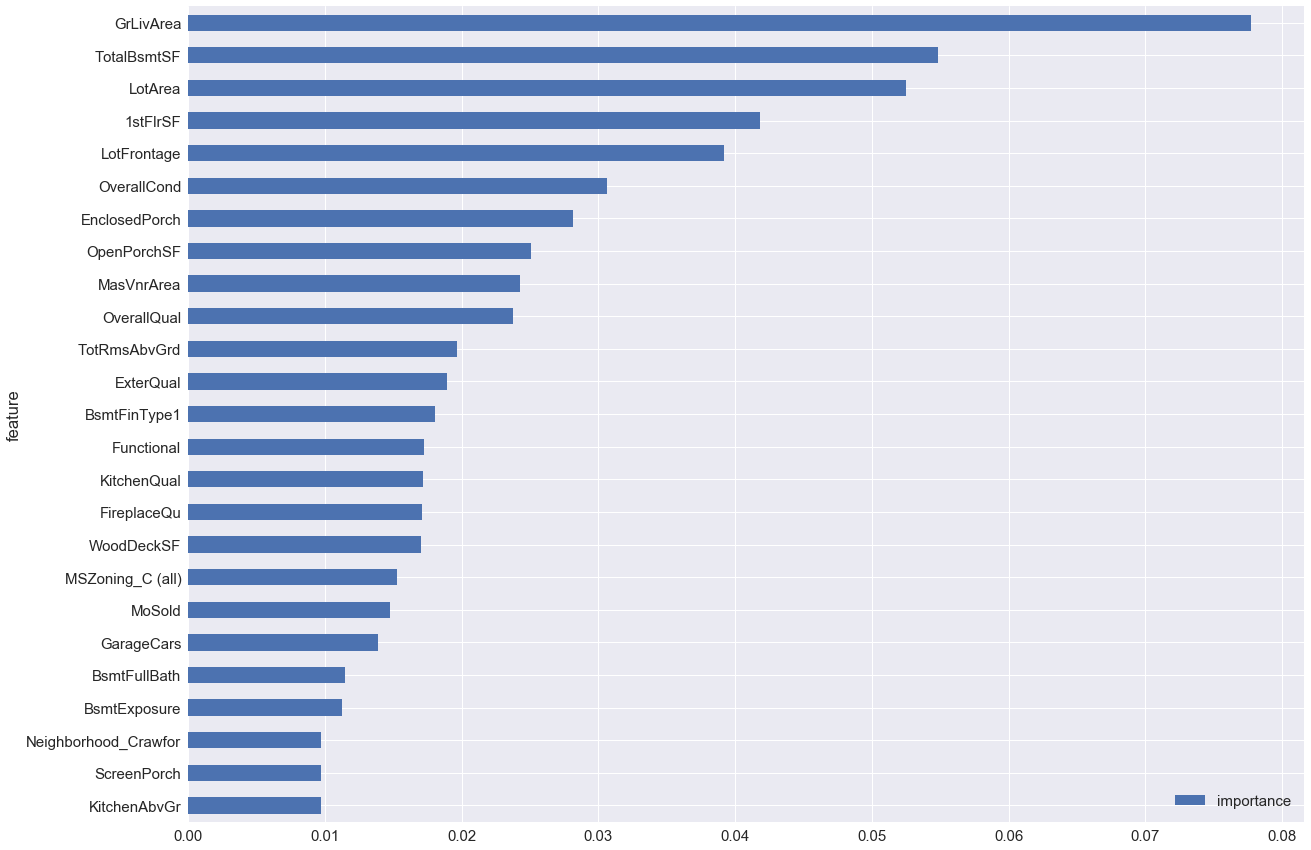

In [337]:
# Get the feature importance weights.
important_features = regressional_model_best.feature_importances_
# Join the features with their appropriate weights.
important_features_df = pd.concat([pd.Series(data=train_data.columns.tolist()), pd.Series(data=important_features)], axis=1, keys=["feature", "importance"])
important_features_df.set_index("feature", inplace=True)
# Sort them in ascending order.
important_features_df = important_features_df.loc[important_features_df.importance > 0].sort_values(by="importance", ascending=True)
# Since the values are sorted in ascending order, plot the last 25 features to get the top 25 most important features.
important_features_df.tail(25).plot(kind="barh", figsize=(20, 15))

**Predicted SalePrice vs. Observed SalePrice**

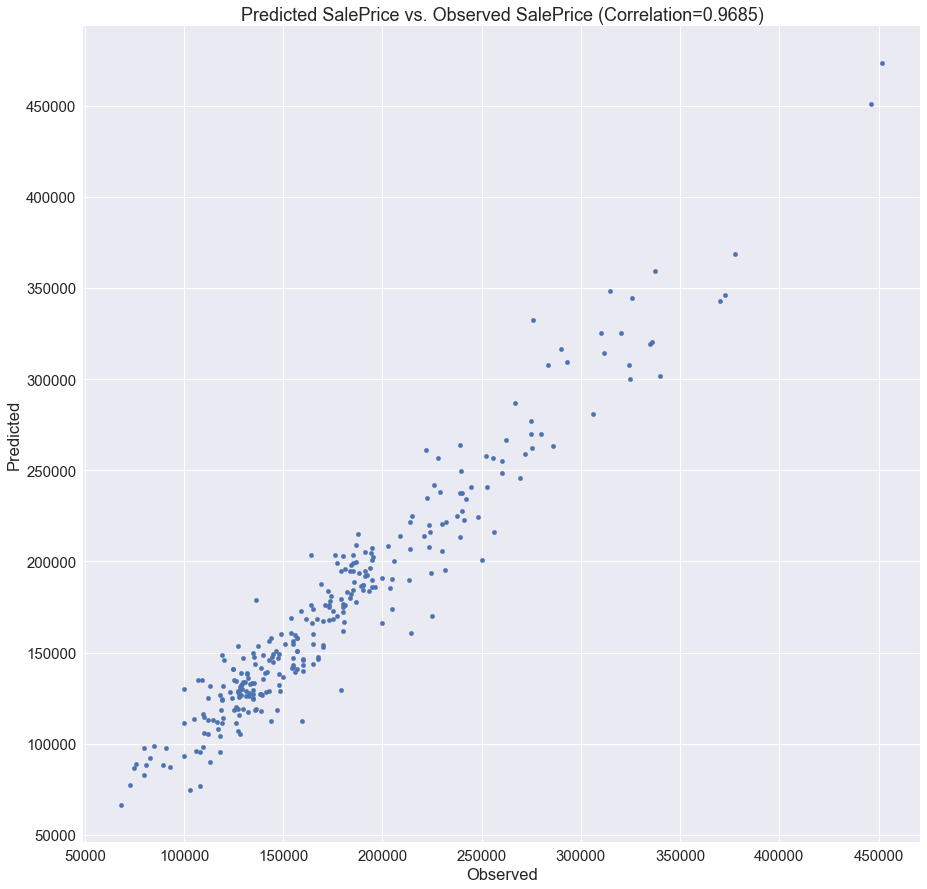

In [338]:
saleprices = pd.DataFrame()
saleprices["Observed"] = np.expm1(y_test)
saleprices["Predicted"] = np.expm1(y_pred)
price_correlation = saleprices["Observed"].corr(saleprices["Predicted"])
saleprices.plot(x="Observed", y="Predicted", kind="scatter", title="Predicted SalePrice vs. Observed SalePrice (Correlation={:.4f})".format(price_correlation), figsize=(15, 15))

**Final prediction on the Testing set.**

In [339]:
# Since the target variable was log transformed use exponentiation function to get the original value.
y_pred_test = np.expm1(regressional_model_best.predict(test_data))

**Let's have a look at 10 samples from the predictions.**

In [340]:
submission_df = pd.concat([pd.Series(data=test_data.index.tolist()), pd.Series(y_pred_test)], axis=1, keys=["Id", "SalePrice"]).round(4)
display(submission_df.sample(10))

Id    SalePrice
410   1871  532240.9815
337   1798  250826.7373
876   2337  346842.2824
275   1736  248295.5269
238   1699  533214.3310
763   2224  401295.7031
698   2159  371451.3942
343   1804  327049.2800
1187  2648  294531.7432
1100  2561  326787.4459

**Save the predictions to disk.**

In [341]:
submission_df.to_csv("gbr_predictions.csv", index=False)

## This brings us to the end of this project. Thank you.